# Enforced Fairness for Machine Learning in Insurance, Criminal Justice, and Other Sensitive Environments
##### Author: Tristan Brigham
##### Course: CPSC 471

The tradeoff between explainability and efficiency in current machine learning models is extreme. I seek to provide a framework and example implementations of how fairness and explainability can be directly integrated into ML both during training as well as in a post-hoc manner for the explanations of outputs.

In this notebook, I explore two different datasets in order to assess whether the proposed strategy for observable and explainable machine learning is viable for sensitive environments. My strategy opens the traditional "black box" model to investigation and auditing without the compromises necessitated by current non-linear machine learning. 

In [ ]:
# install the packages that we need
# !pip install plotly
# !pip install -U scikit-learn
# !pip install shap
# !pip install -U kaleido

In [146]:
%matplotlib inline

In [147]:
## imports for the program
import os
import io
import csv
import zlib
import math
import pickle
import base64
import joblib
import hashlib
import platform
import warnings

import numpy as np
import pandas as pd
import xgboost as xgb
from tqdm import tqdm
from xgboost import plot_importance
from scipy.optimize import fmin_powell
from scipy import stats

# plot information in 3 dimensions
# from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
import kaleido
from PIL import Image

from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, DBSCAN, MeanShift, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.inspection import PartialDependenceDisplay
from sklearn.linear_model import LinearRegression

# the pytorch module
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset

# torch neural network items
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# changing the precision of the floating point operations
from torch.cuda.amp import GradScaler, autocast

# for visualization
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

# lime model evaluation
from lime import lime_tabular

# for encrypting the model and hashing it
from cryptography.hazmat.primitives.kdf.pbkdf2 import PBKDF2HMAC
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.kdf.scrypt import Scrypt
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives import serialization
from cryptography.hazmat.primitives.asymmetric import rsa
from cryptography.hazmat.primitives.asymmetric import padding
from cryptography.fernet import Fernet, MultiFernet




# code for xgboost found at https://www.kaggle.com/code/zeroblue/xgboost-with-optimized-offsets

# defining the device for cuda
if platform.system() == 'Darwin' and torch.backends.mps.is_available():
	
	# check if mps is available on mac
	device = torch.device('mps')  

elif torch.cuda.is_available():
	
	# check if cuda is available
    device = torch.device('cuda')  

else:
	
	# fallback to cpu if cuda is not available
	device = torch.device('cpu')  

# output the selected device
print(f"Using device: {device}")


Using device: mps


In [222]:
# environment and global variables that we want to use for the program

# global directory path
HOME_DIR = os.path.expanduser('~')

# the sub directory from the home direcotry
SUB_DIR = "Desktop/Classes/CPSC 471/Final Project/"

# the path to the generated images directory that we are using
GENERATED_IMAGES_DIR = "models"

# save path
SAVE_MODEL_PATH = os.path.join(HOME_DIR, SUB_DIR, "models_save")
print(f"SAVE PATH: {SAVE_MODEL_PATH}")

AUG_SAVE_FILE_NAME = "aug_model_save.pth"
FULL_INPUT_AUG_SAVE_FILE_NAME = "full_input_aug_model_save.pth"
BASELINE_SAVE_FILE_NAME = "baseline_model_save.pth"
SINGLE_SAVE_FILE_NAME = "single_model_save.pth"
INFO_DICT_NAME = "info_dict.pkl"
RUNTHROUGH_DIR_NAME = "runthroughs"

# defining the batch size
BATCH_SIZE = 40

# whether we should train the model or load the model in this passthrough
TRAIN_MODEL = True

# whether we should sum the weight in the augmented model (alternative is multiply the weight)
SUM_WEIGHT = True
# the amount that we should scale the comcept loss by
SUM_EPSILON = 0.001 	

# whether we should use batches for training or not
USE_BATCHES = True

# whether we should try to create a single 
TESTING_SINGLE_lAYER = False

# PLOT_PALETTE = "viridis"
# PLOT_PALETTE = "rainbow"
# PLOT_PALETTE = "mako"
PLOT_PALETTE = "magma"
PLOT_PALETTE = "icefire"


PLOT_COLOR_1 = "darkorange"
PLOT_COLOR_2 = "dodgerblue"
PLOT_COLOR_3 = "green"
PLOT_COLOR_4 = "firebrick"
TRANSPARENCY = 0.3

# how many output classes
NUM_CLASSES = 8
NUM_TOP_FEATURES_TO_SHOW = 10	

# parameter for how deep into the network we should stop boosting gradients
depth_revert_grad_boost = 0.75
CLUSTER_NUM = 6
MAX_INDICIES_LEN_PLOTTING = 500

# how strong should the explanation regularization be
adj_weight = 3.0
adj_weight = 1.0

# this determines whether we are saving all of the information that is generated in the runthrough
SHOULD_SAVE_OUTPUT = True
RUN_BASE_NAME = "run"

# the number of principal components that we should consider
NUM_PCA_PC = 10

# define the clustering method that we will use
clustering_method_name = 'k_means_centers'


SAVE PATH: /Users/tristanbrigham/Desktop/Classes/CPSC 471/Final Project/models_save


In [149]:
# program state variables
pca_mahalanobis_covariance_matrix = None
total_mahalanobis_covariance_matrix = None


In [150]:
# function for generating and saving the file to a unique file name
def generate_unique_file_dir(base_path, file_base, allow_base=False):
      
	# initialize the full path
	full_path = os.path.join(base_path, file_base)
	
	# if the file does not exist, return this path
	if not os.path.exists(full_path) and allow_base:
		return full_path
	
	# if the file exists, modify it by adding a number suffix
	# file_base, file_extension = os.path.splitext(filename)
	counter = 1  # Start numbering from 1
	
	# loop to find a non-existing file
	while True:

		# format the new file name
		new_filename = f"{file_base}_{counter}"
		full_path = os.path.join(base_path, new_filename)

		# check if the path exists or not
		if not os.path.exists(full_path):
			return full_path
		
		counter += 1  


# if we are saving the output, then we should save all of the information to a new folder
if SHOULD_SAVE_OUTPUT:

	# the path to the directory that we are going to populate
	curr_run_dir = generate_unique_file_dir(os.path.join(HOME_DIR, SUB_DIR, RUNTHROUGH_DIR_NAME), RUN_BASE_NAME)

	# create a directory at the path that we specified
	os.makedirs(curr_run_dir, exist_ok=True)

	# print a status update about the file
	print(f"Saving all files from run to {curr_run_dir}")


# init a new info dictionary data structure
file_path = os.path.join(curr_run_dir, INFO_DICT_NAME)

try:
    # Attempt to load the dictionary from the file
    with open(file_path, 'rb') as file:
        info_dict = pickle.load(file)
except (FileNotFoundError, EOFError, pickle.PickleError) as e:
    # If the file doesn't exist or an error occurs during loading, initialize an empty dictionary
    print(f"Failed to load the file: {e}")
    info_dict = {}
	

Saving all files from run to /Users/tristanbrigham/Desktop/Classes/CPSC 471/Final Project/runthroughs/run_1
Failed to load the file: [Errno 2] No such file or directory: '/Users/tristanbrigham/Desktop/Classes/CPSC 471/Final Project/runthroughs/run_1/info_dict.pkl'


In [151]:
# ensure the directory exists
os.makedirs(SAVE_MODEL_PATH, exist_ok=True)

# suppress the user warnings that are not helpful to us at all
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# make sure that the results are reproducable
torch.manual_seed(0) 

In [152]:
# the base model that we are going to be testing against is an XGBoost Model

# wrapper for performing our evaluations
def eval_wrapper(yhat, y):
    y = np.array(y)
    y = y.astype(int)
    yhat = np.array(yhat)
    yhat = np.clip(np.round(yhat), np.min(y), np.max(y)).astype(int)
    return cohen_kappa_score(yhat, y, weights='quadratic')

# the parameters for the xgboost model
def get_params():
    params = {}
    params["objective"] = "reg:squarederror"  # Updated to 'reg:squarederror' to avoid deprecation warning
    params["eta"] = 0.05
    params["min_child_weight"] = 360
    params["subsample"] = 0.85
    params["colsample_bytree"] = 0.3
    params["silent"] = 1
    params["max_depth"] = 7
    plst = list(params.items())
    return plst

# this is how we are scoring the model
def score_offset(data, bin_offset, sv, scorer=eval_wrapper):
    # data has the format of pred=0, offset_pred=1, labels=2 in the first dim
    data[1, data[0].astype(int)==sv] = data[0, data[0].astype(int)==sv] + bin_offset
    score = scorer(data[1], data[2])
    return score

# function to apply the offset for scoring
def apply_offsets(data, offsets):
    for j in range(NUM_CLASSES):
        data[1, data[0].astype(int)==j] = data[0, data[0].astype(int)==j] + offsets[j]
    return data


In [153]:
# load the data
print("Load the data using pandas")
train = pd.read_csv("../final_471_datasets/train.csv")
test = pd.read_csv("../final_471_datasets/test.csv")

# global variables
columns_to_drop = ['Id', 'Response'] #, 'Medical_History_10','Medical_History_24']
xgb_num_rounds = 720
missing_indicator = -1000

# training and testing temp dataframes
temp_train = train
temp_test = test

# getting all of the data
all_data = pd.concat([temp_train, temp_test], ignore_index=True)

# create new variable for product first and second character
all_data['Product_Info_2'] = all_data.Product_Info_2.astype(str)
all_data['Product_Info_2_char'] = all_data["Product_Info_2"].str[0]
all_data['Product_Info_2_num'] = all_data["Product_Info_2"].str[1]

# factorize the categorical variables
all_data['Product_Info_2'] = pd.factorize(all_data['Product_Info_2'])[0]
all_data['Product_Info_2_char'] = pd.factorize(all_data['Product_Info_2_char'])[0]
all_data['Product_Info_2_num'] = pd.factorize(all_data['Product_Info_2_num'])[0]

# get the combined BMI age variable
all_data['BMI_Age'] = all_data['BMI'] * all_data['Ins_Age']

# checking for how many medical keywords were found in each patient diagnosis
med_keyword_columns = all_data.columns[all_data.columns.str.startswith('Medical_Keyword_')]
all_data['Med_Keywords_Count'] = all_data[med_keyword_columns].sum(axis=1)

# remove the missing values
print('Eliminate missing values')    
all_data.fillna(missing_indicator, inplace=True)

# fix the dtype on the label column
all_data['Response'] = all_data['Response'].astype(int)

# split train and test
train = all_data[all_data['Response']>0].copy()
test = all_data[all_data['Response']<1].copy()

# convert data to xgb data structure
xgtrain = xgb.DMatrix(train.drop(columns_to_drop, axis=1), train['Response'].values, missing=missing_indicator)
xgtest = xgb.DMatrix(test.drop(columns_to_drop, axis=1), label=test['Response'].values, missing=missing_indicator)    

# get the parameters for xgboost
plst = get_params()
print(plst)      

Load the data using pandas
Eliminate missing values
[('objective', 'reg:squarederror'), ('eta', 0.05), ('min_child_weight', 360), ('subsample', 0.85), ('colsample_bytree', 0.3), ('silent', 1), ('max_depth', 7)]


In [154]:
# train the model on the data as a baseline for the information
model = xgb.train(plst, xgtrain, xgb_num_rounds) 

# get preds
train_preds = model.predict(xgtrain)

train_score = eval_wrapper(train_preds, train['Response'])
print('Train score is:', train_score) 
test_preds = model.predict(xgtest)

# now save the model to a new file if we need to
model.save_model(os.path.join(curr_run_dir, 'xgb_model.bin'))

Train score is: 0.6509777181220997


In [155]:
# train offsets 
offsets = np.array([0.1, -1, -2, -1, -0.8, 0.02, 0.8, 1])
offset_preds = np.vstack((train_preds, train_preds, train['Response'].values))
offset_preds = apply_offsets(offset_preds, offsets)
opt_order = [6,4,5,3]

# go through the optimization order and apply the offsets
for j in opt_order:
    train_offset = lambda x: -score_offset(offset_preds, x, j) * 100
    offsets[j] = fmin_powell(train_offset, offsets[j], disp=False)

# return the offset score value to the user of the ml model
print('Offset Train score is:', eval_wrapper(offset_preds[1], train['Response']))

Offset Train score is: 0.7033385099458398


In [156]:
# apply offsets to test
data = np.vstack((test_preds, test_preds, test['Response'].values))
data = apply_offsets(data, offsets)

# clip the final predictions
final_test_preds = np.round(np.clip(data[1], 1, 8)).astype(int)

# get the predictions from the machine learning model
preds_out = pd.DataFrame({"Id": test['Id'].values, "Response": final_test_preds})
preds_out = preds_out.set_index('Id')
# preds_out.to_csv('xgb_offset_submission.csv')

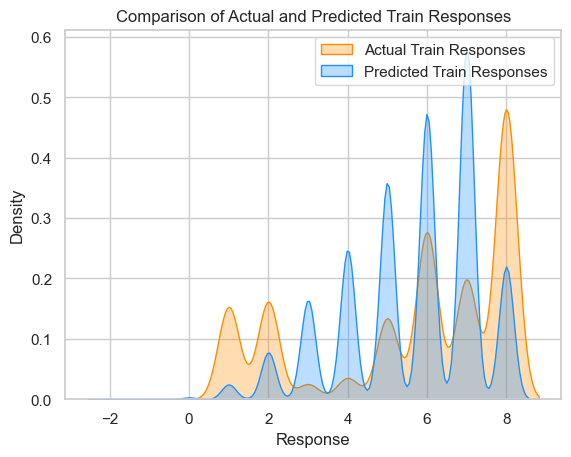

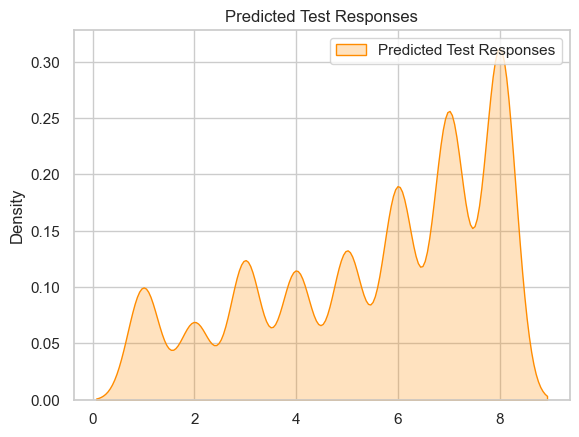

In [157]:
# visualize the output of the XGBoost Model that we used
# sns.kdeplot(train['Response'], label='Actual Train Responses', fill=True, palette=PLOT_PALETTE)
# sns.kdeplot(np.rint(train_preds).astype(int), label='Predicted Train Responses', fill=True, palette=PLOT_PALETTE)
# sns.kdeplot(np.rint(train_preds).astype(int), label='Predicted Train Responses', fill=True, palette=PLOT_PALETTE)
sns.kdeplot(train['Response'], label='Actual Train Responses', fill=True, color=PLOT_COLOR_1, alpha=TRANSPARENCY)
# sns.kdeplot(train['Response'], label='Actual Train Responses', fill=True)
# sns.kdeplot(np.rint(train_preds).astype(int), label='Predicted Train Responses', fill=True)
sns.kdeplot(np.rint(train_preds).astype(int), label='Predicted Train Responses', fill=True, color=PLOT_COLOR_2, alpha=TRANSPARENCY)
plt.title('Comparison of Actual and Predicted Train Responses')
plt.legend()

# save the figure and then show it
plt.savefig(os.path.join(HOME_DIR, SUB_DIR, GENERATED_IMAGES_DIR, "xgb_actual_train.png"), dpi=300)

if SHOULD_SAVE_OUTPUT:
	plt.savefig(os.path.join(curr_run_dir, "xgb_actual_train.png"), dpi=300)


plt.show()

# for test predictions, assuming you have actual test responses
# sns.kdeplot(test['Response'], label='Actual Test Responses', fill=True, palette=PLOT_PALETTE)
# sns.kdeplot(final_test_preds, label='Predicted Test Responses', fill=True, palette="plasma")
sns.kdeplot(final_test_preds, label='Predicted Test Responses', fill=True, color=PLOT_COLOR_1)
plt.title('Predicted Test Responses')
plt.legend()

# save the figure and then show it
plt.savefig(os.path.join(HOME_DIR, SUB_DIR, GENERATED_IMAGES_DIR, "xgb_pred_test.png"), dpi=300)

if SHOULD_SAVE_OUTPUT:
	plt.savefig(os.path.join(curr_run_dir, "xgb_pred_test.png"), dpi=300)


plt.show()

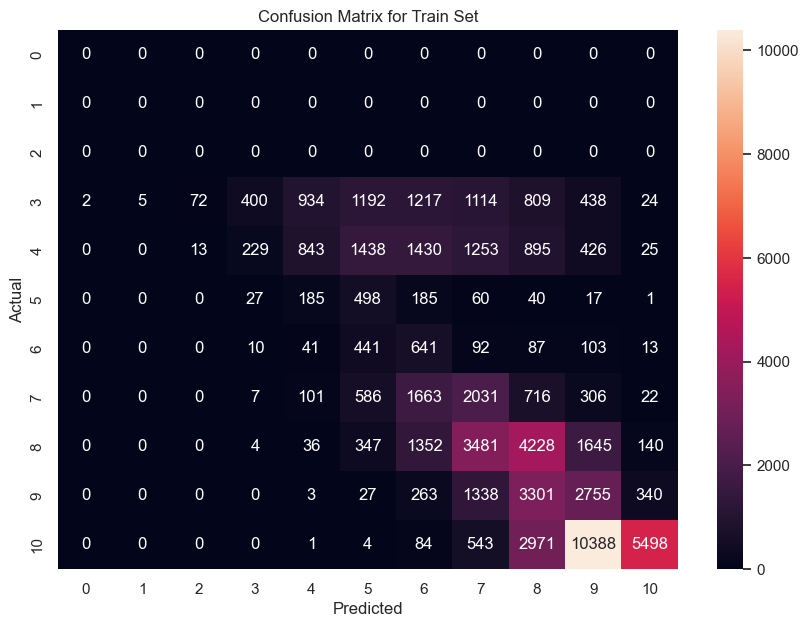

In [158]:
# get the confusion matrix
cm = confusion_matrix(train['Response'], np.round(train_preds))

# show the plot
plt.figure(figsize=(10, 7))
# sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm')
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix for Train Set')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig(os.path.join(HOME_DIR, SUB_DIR, GENERATED_IMAGES_DIR, "xgb_conf_matrix.png"), dpi=300)

# save the confusion matrix output to a png file
if SHOULD_SAVE_OUTPUT:
	plt.savefig(os.path.join(curr_run_dir, "xgb_conf_matrix.png"), dpi=300)

plt.show()

<Figure size 1000x800 with 0 Axes>

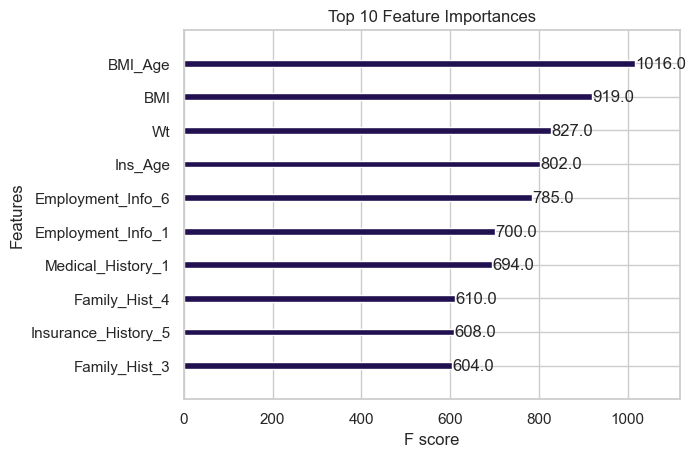

In [159]:
# plot the final importances
plt.figure(figsize=(10, 8))

# show the top NUM_TOP_FEATURES_TO_SHOW
plot_importance(model, max_num_features=NUM_TOP_FEATURES_TO_SHOW) 
plt.title('Top 10 Feature Importances')
plt.savefig(dpi=300, fname=os.path.join(HOME_DIR, SUB_DIR, GENERATED_IMAGES_DIR, "xgb_top_features.png"))

# save the top model features to a bar graph
if SHOULD_SAVE_OUTPUT:
	plt.savefig(dpi=300, fname=os.path.join(curr_run_dir, "xgb_top_features.png"))

plt.show()

In [160]:
# getting the metrics for the test data
accuracy = accuracy_score(train['Response'], np.rint(train_preds).astype(int))
print("Train Accuracy: {:.2f}%".format(accuracy * 100))
print("Kappa Cohen: {:.2f}".format(train_score * 100))
print()

# getting the metrics for the training data
# accuracy = accuracy_score(final_test_preds, np.rint(test_preds).astype(int))
# print("Test Accuracy: {:.2f}%".format(accuracy * 100))
# print("Kappa Cohen: {:.2f}".format(eval_wrapper(final_test_preds, test_preds) * 100))

Train Accuracy: 28.45%
Kappa Cohen: 65.10



### XGBoost nn_model Results

As we can see above, the result of the XGBoost model is not stellar. The model seems to have a difficult time nailing down the relative frequencies of the data. On average, the model achieves the following metrics. 

| Metric            |   Value    |
|:------------------|:----------:|
| Train Accuracy    |   28.45%   |
| Kappa Cohen (Train) |   65.10    |


# Baseline Neural Network

We are now going to create a baseline neural network that we can compare the results of the xgboost and the resulting node importance manipulation against.


In [161]:
# these are helper functions that help us to monitor the output of the neural network layers and 
# attach hooks to the neural network that helps us get the forward pass values
network_layer_outputs = []
current_pass_through = []

# define the hook to get the forward pass through the neural network
def get_layer_output_hook(module, input, output):

    global current_pass_through

    # append the output of this passthrough to the total array
    current_pass_through.append(output.cpu().detach())  

# register the hooks with the network
def register_hooks(model):

    print(f"Registering hooks...")

    # check each of the layers for somewhere where we can register a hook
    for layer in model.children():

        # check for an instance of a layer
        if isinstance(layer, nn.Module):

            # register a forward hook
            layer.register_forward_hook(get_layer_output_hook)

            # give the staus
            # print(f"Registered a forward hook at: {layer}")

# start a new pass of the model that we are running
def start_new_pass_through():
    global current_pass_through
    current_pass_through = []

# clear the current pass through
def save_and_clear_current_pass_through():
    global network_layer_outputs, current_pass_through
    network_layer_outputs.append(current_pass_through)

    start_new_pass_through()

# this function entirely wipes the storage of the intermediate values
def clear_total_run():
    global network_layer_outputs
    network_layer_outputs = []

# function to return and clear the entire training series
def retrieve_and_return_entire_network_outputs():
    global network_layer_outputs
    t_ret = network_layer_outputs
    network_layer_outputs = []
    return t_ret

In [162]:
# now create a neural network without any of the explainability features that we want to integrate

# just pull the data from before
train_data = all_data[all_data['Response'] > 0].copy()
test_data = all_data[all_data['Response'] < 1].copy()

# split the data into training and validation
X_train, X_val, y_train, y_val = train_test_split(
    train_data.drop(columns=columns_to_drop, axis=1),
    train_data['Response'],
    test_size=0.2,
    random_state=42
)

In [163]:
# scale the data appropriately
scaler = StandardScaler()

# fit and transform the data
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [164]:
# load the insurance dataset in 
class InsuranceDataset(Dataset):

    # initialize the features and the labels
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    # define the length function
    def __len__(self):
        return len(self.features)

    # get the item defined by an index
    def __getitem__(self, idx):
        return torch.tensor(self.features[idx], dtype=torch.float), torch.tensor(self.labels[idx], dtype=torch.long) - 1  # Assuming labels are 1-indexed


# define an object for the insurance test and train datasets
train_dataset = InsuranceDataset(X_train_scaled, y_train.values)
val_dataset = InsuranceDataset(X_val_scaled, y_val.values)

# include the validation dataset
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)






# compute the principal components of the data that we are trying to train the machine learning model on 
# all_data: this is all of the data that we are going to run the principal component analysis on
# n_components: the number of components that the PCA should generate for us
# should_scale: this defines whether we should scale the data that we are considering or not using the standard scaler
def compute_PCA(all_data, n_components=NUM_PCA_PC, scale_data=False):

    # check the data type to make sure that it is good
    if not isinstance(all_data, torch.Tensor):
        all_data = torch.tensor(all_data, dtype=torch.float)

    # compute the principal components
    if scale_data:
        std_scaler = StandardScaler()
        all_data = std_scaler.fit_transform(all_data)

    # run the pca
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(all_data)

    # return the principal components
    return pca, torch.from_numpy(principal_components).float()




# function for getting all of the features of the data together for computation
def get_all_features(train_loader):

    # get the matrix that we are going to be using to compute the mahalanobis distance
    # start by getting all of the data from the loader
    features_list = []
    labels_list = []

    for features, labels in tqdm(train_loader, desc="Retrieving data from loader"):
        features_list.append(features)
        labels_list.append(labels)

    # concatenate all of the inputs that we are going to be using together
    all_features = torch.cat(features_list, dim=0)

    # get a tensor out of it
    all_features = all_features.clone().detach()
    
    # concatenate all of the inputs that we are going to be using together
    all_labels = torch.cat(labels_list, dim=0)
    all_labels = all_labels.clone().detach()

    return (all_features, all_labels)


# function to visualize the PCA so that we can better understand the data that we are training on
def visualize_pca(pca_features, labels, centroids):

    # transfer the labels to numpy
    labels = np.array(labels)
    
    # class colors
    matplotlib_colors = [
        'b',  
        'g',  
        'r',  
        'c',  
        'm',  
        'y',  
        'orange',
        'purple',
        'brown',
        'pink',
        'gray',
        'olive',
        'cyan',
        'lime',
        'maroon',
        'navy',
        'teal',
        'coral'
    ]

    # get the number of labels that we are going to plot
    # print(f"Number of labels: {len(set(labels))}")

    # get the number of components that we are ploting
    num_components = pca_features.shape[1]
    num_plots = num_components // 3

    # create subplots
    for plot_index in range(num_plots):
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')

        # getting the compoennts that we ar egoing to be plotting
        component_start = plot_index * 3
        component_end = component_start + 3

        # create the figure
        fig = go.Figure()

        # plot the PCA figures
        for label in tqdm(set(labels), desc=f"Plotting labeled data points in subplot {plot_index}"):

            # get all of the points from a certain label
            indices = np.where(labels == label)[0]

            # sample a maximum number of the points
            if len(indices) > MAX_INDICIES_LEN_PLOTTING:
                indices = np.random.choice(indices, MAX_INDICIES_LEN_PLOTTING, replace=False)

            # print(f"Plotting {len(indices)} points for label {label} in subplot {plot_index}...")

            # fix the label features to fix it if we had too. many
            label_features = pca_features[indices, component_start:component_end]

            # plot the dots
            try:
                # plt.scatter(label_features[:, 0], 
                #             label_features[:, 1], 
                #             color=matplotlib_colors[label], 
                #             label=f'Class {label}', 
                #             s=10)

                fig.add_trace(go.Scatter3d(
                    x=label_features[:, 0], 
                    y=label_features[:, 1], 
                    z=label_features[:, 2],
                    mode='markers',
                    marker=dict(size=3),
                    name=f'Class {label}'
                ))
            except Exception as e:
                print(f"Failed: {e}")
        
        # plot the centroids to show where they are
        for i, centroid in enumerate(centroids):
            if centroid.shape[0] > component_end:
                fig.add_trace(go.Scatter3d(
                    x=[centroid[component_start]],
                    y=[centroid[component_start+1]],
                    z=[centroid[component_start+2]],
                    mode='markers',
                    marker=dict(symbol='x', size=5, color='black'),
                    name=f'Centroid {i + 1}'
                ))
                # print(f'Centroid {i + 1} at {centroid[component_start]} {centroid[component_start+1]} {centroid[component_start+2]}')

        # put the information on the plots
        # ax.set_title(f'3D PCA Plot of Components {component_start+1} to {component_end}')
        # ax.set_xlabel('Component {}'.format(component_start + 1))
        # ax.set_ylabel('Component {}'.format(component_start + 2))
        # ax.set_zlabel('Component {}'.format(component_start + 3))
        # ax.legend()

        fig.update_layout(
            title=f'3D PCA Plot of Components {component_start+1} to {component_end}',
            scene=dict(
                xaxis_title=f'Component {component_start + 1}',
                yaxis_title=f'Component {component_start + 2}',
                zaxis_title=f'Component {component_start + 3}'
            ),
            legend_title="Legend",
            autosize=False,
            width=700,
            height=700,
        )

        # plot the title as neede
        # plt.title('PCA of Training Data')
        # plt.xlabel('Principal Component 1')
        # plt.ylabel('Principal Component 2')
        # plt.legend()
        # plt.grid(True)
        fig.show()

        # now save the plot to a png
        # fig.write_image(os.path.join(HOME_DIR, SUB_DIR, GENERATED_IMAGES_DIR, f"pca_subplot_{plot_index}.png"))

        # display the image
        # display(Image(filename=os.path.join(HOME_DIR, SUB_DIR, GENERATED_IMAGES_DIR, f"pca_subplot_{plot_index}.png")))



# prepare the test data (normalize and load into DataLoader)
X_test_scaled = scaler.transform(test_data.drop(columns=['Response', 'Id'] + columns_to_drop, axis=1))
test_dataset = InsuranceDataset(X_test_scaled, np.zeros((X_test_scaled.shape[0],)))
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


# getting all of the data
(all_train_features, all_train_labels) = get_all_features(train_loader)
(all_val_features, all_val_labels) = get_all_features(val_loader)
(all_test_features, all_test_labels) = get_all_features(test_loader)


# pca_model, pca_train_features = compute_PCA(all_train_features)
# pca_val_features = torch.from_numpy(pca_model.transform(all_val_features)).float()

# saving the model if we have trained it
if TRAIN_MODEL:
   
    # run PCA on the data
    pca_model, pca_train_features = compute_PCA(all_train_features)
    pca_val_features = torch.from_numpy(pca_model.transform(all_val_features)).float()
    pca_test_features = torch.from_numpy(pca_model.transform(all_test_features)).float()

else:
   
    # load the PCA model in 
    pca_model = joblib.load(os.path.join(curr_run_dir, 'pca_model.joblib'))

# check if we should save the model to a runthrough
if SHOULD_SAVE_OUTPUT:
    print(f"Saving PCA")
    joblib.dump(pca_model, os.path.join(curr_run_dir, 'pca_model.joblib'))




Retrieving data from loader: 100%|██████████| 495/495 [00:00<00:00, 2644.88it/s]


Saving PCA


In [165]:

# checking the shapes
# print(f"all_train_features shape: {all_train_features.shape}")
# print(f"pca_components shape: {pca_train_features.shape}")
# print(f"inverse transform shape: {pca_model.inverse_transform(pca_train_features).shape}")
# print(f"all_train_labels shape: {all_train_labels.shape}")







# turn the training data into a dataset
pca_train_dataset = TensorDataset(pca_train_features, all_train_labels)
pca_val_dataset = TensorDataset(pca_val_features, all_val_labels)
pca_test_dataset = TensorDataset(pca_test_features, all_test_labels)

# define the loaders
pca_train_loader = DataLoader(pca_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
pca_val_loader = DataLoader(pca_val_dataset, batch_size=BATCH_SIZE, shuffle=False)
pca_test_loader = DataLoader(pca_test_dataset, batch_size=BATCH_SIZE, shuffle=False)


# turn the training data into a dataset
full_train_dataset = TensorDataset(all_train_features, all_train_labels)
full_val_dataset = TensorDataset(all_val_features, all_val_labels)
full_test_dataset = TensorDataset(all_test_features, all_test_labels)

# define the loaders
full_train_loader = DataLoader(full_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
full_val_loader = DataLoader(full_val_dataset, batch_size=BATCH_SIZE, shuffle=False)
full_test_loader = DataLoader(full_test_dataset, batch_size=BATCH_SIZE, shuffle=False)



# define a dataset class that returns the actual data with the pca
class PCA_Full_Dataset(Dataset):
    def __init__(self, d1, d2):
        assert len(d1) == len(d2), "Datasets must be the same length"
        self.d1 = d1
        self.d2 = d2

	# return thelength of the dataset
    def __len__(self):
        return len(self.d1)

	# pull an item from thecombined dataset
 	# that is at index idx
    def __getitem__(self, idx):
        x1, y1 = self.d1[idx]
        x2, y2 = self.d2[idx]
        return (x1, x2), y1

# create the combined dataset
pca_full_train_dataset = PCA_Full_Dataset(pca_train_dataset, full_train_dataset)
pca_full_train_loader = DataLoader(pca_full_train_dataset, batch_size=BATCH_SIZE, shuffle=True)

pca_full_val_dataset = PCA_Full_Dataset(pca_val_dataset, full_val_dataset)
pca_full_val_loader = DataLoader(pca_full_val_dataset, batch_size=BATCH_SIZE, shuffle=True)

pca_full_test_dataset = PCA_Full_Dataset(pca_test_dataset, full_test_dataset)
pca_full_test_loader = DataLoader(pca_full_test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# now get the k centroids that would represent the center of the clusters that
# I would get if I ran a k-means clustering algorithm
print(f"Computing theoretical clustering centroids...")

Computing theoretical clustering centroids...


In [166]:
# neural network for the insurance dataset
# as a baseline for the model
class InsuranceNN(nn.Module):

    # initialize the insurance neural network item
    def __init__(self):
        super(InsuranceNN, self).__init__()
        self.fc1 = nn.Linear(pca_train_features.shape[1], 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, NUM_CLASSES)  

    # go forward through the neural network
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    # this function returns the probabilities for different classes from the neural network model
    def predict_proba(self, x, device='cpu'):
        
        # set the network to evaluation mode
        self.eval()  
        
        with torch.no_grad():
        
            # pass through the model
            x = x.to(device)
            outputs = self(x)

            # get the probabilities
            out_probs = F.softmax(outputs, dim=1)

            return out_probs

    # defining a fit function to appease the marginal probability regression function
    def fit(self, train_loader, epochs, optimizer, criterion, device='cpu'):
        
        # move everything to devices
        self.to(device)
        self.train()

        # iterate through some amount of epochs to train the model
        for epoch in range(epochs):

            for inputs, labels in train_loader:
            
                # move everything to the right devices
                inputs = inputs.to(device) 
                labels = labels.to(device)

                # reset the optimizer that we are using
                optimizer.zero_grad()
                outputs = self(inputs)

                # calc the loss
                loss = criterion(outputs, labels)
                
                # backprop the loss
                loss.backward()
                optimizer.step()
            
            # print epoch information
            print(f'epoch: {epoch+1}/{epochs} | loss: {loss.item():.4f}')

# initialize the model
baseline_model = InsuranceNN()

# register the hooks that are going to keep track of the outputs of the model activations
register_hooks(baseline_model)

Registering hooks...


Epoch 1, Loss: 1.5651501038861195, Val Loss: 1.5403386948485969
Epoch 2, Loss: 1.5143612201767738, Val Loss: 1.5251055462191803
Epoch 3, Loss: 1.5036067228124599, Val Loss: 1.5211661805207481
Epoch 4, Loss: 1.49867726405863, Val Loss: 1.512360317939861
Epoch 5, Loss: 1.4934782689870005, Val Loss: 1.5108420672240082
Epoch 6, Loss: 1.489278262111073, Val Loss: 1.5067104614944973
Epoch 7, Loss: 1.4856474257077432, Val Loss: 1.50448883302284
Epoch 8, Loss: 1.4831352179700679, Val Loss: 1.5031165623102927
Epoch 9, Loss: 1.4794548666637755, Val Loss: 1.4977238760251388
Epoch 10, Loss: 1.4775448487663911, Val Loss: 1.5019219074185046
Epoch 11, Loss: 1.474553669943954, Val Loss: 1.4943823549482558
Epoch 12, Loss: 1.4723551652648232, Val Loss: 1.4986756285433014
Epoch 13, Loss: 1.4705315204682174, Val Loss: 1.4973588407240332
Epoch 14, Loss: 1.4686077569771294, Val Loss: 1.4924120124341662
Epoch 15, Loss: 1.4670131664083461, Val Loss: 1.493086405073352
Epoch 16, Loss: 1.464783117325619, Val Los

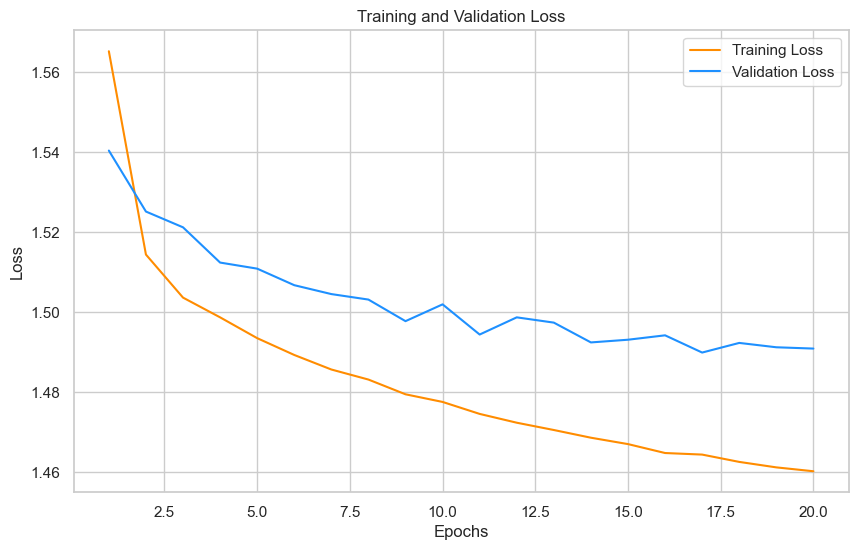

In [167]:

##
# this function is used to train the neural network that we are going to be using for classification of the items that 
# we are considering for insurance and for prisoners
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10, patience=2):
    best_val_loss = float('inf')
    patience_counter = 0

    # lists to store loss values for plotting
    train_losses = []
    val_losses = []
    epochs_list = []


    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        epoch_val_loss = val_loss / len(val_loader)
        # print(f'Epoch {epoch+1}, Loss: {epoch_loss}, Val Loss: {epoch_val_loss}')

        train_losses.append(epoch_loss)
        val_losses.append(epoch_val_loss)
        epochs_list.append(epoch + 1)

        # check if the validation loss improved
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            patience_counter = 0
        
        else:
            patience_counter += 1

        # check for early stopping
        if patience_counter > patience:
            print("Stopping early due to increasing validation loss.")
            break

        # print the statistics from this epoch
        print(f'Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}, Val Loss: {val_loss / len(val_loader)}')

    # plotting the training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs_list, train_losses, label='Training Loss', color=PLOT_COLOR_1)
    plt.plot(epochs_list, val_losses, label='Validation Loss', color=PLOT_COLOR_2)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    if SHOULD_SAVE_OUTPUT:
        plt.savefig(os.path.join(curr_run_dir, "nn_loss.png"))

    plt.show()


# define the criteria and optimizer that we are going to be using to train the neural network
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(baseline_model.parameters(), lr=0.001)

# training the model
train_model(baseline_model, pca_train_loader, pca_val_loader, criterion, optimizer, epochs=30)

# saving the model to a state dictionary
if SHOULD_SAVE_OUTPUT:
    torch.save(baseline_model, os.path.join(curr_run_dir, BASELINE_SAVE_FILE_NAME))

In [168]:
# get the predictions of the validation data
def predict(model, data_loader):

    # set the model to evaluate
    model.eval()
    predictions = []

    model = model.to(device)

    # no gradients on this torch item
    with torch.no_grad():

        # all items in the data loader
        for inputs, _ in data_loader:

            inputs = inputs.to(device)
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            predictions.extend((predicted.cpu() + 1).numpy())

    # return the predictions on the validation dataset
    return predictions



# fix it so that we get the pca version
# actually run the predictions of the model
test_preds = predict(baseline_model, pca_test_loader)

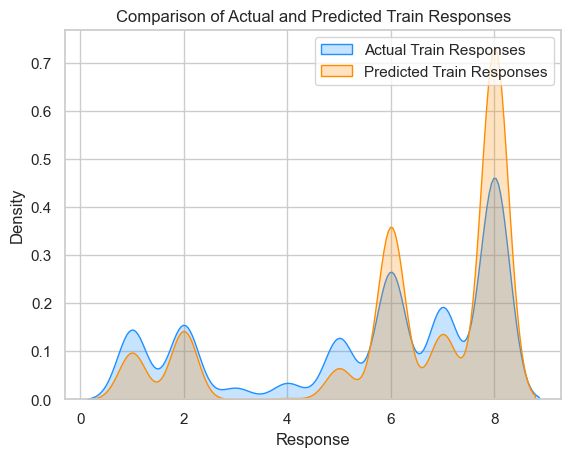

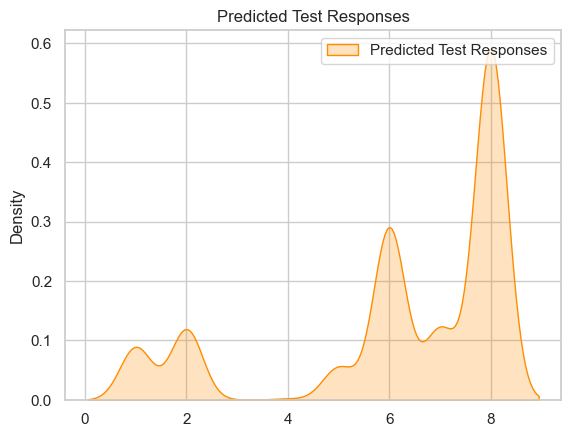

In [169]:
# get the distribution of the predicted values
y_train_pred = predict(baseline_model, pca_train_loader) 

sns.kdeplot(y_train, label='Actual Train Responses', fill=True, color=PLOT_COLOR_2)
sns.kdeplot(y_train_pred, label='Predicted Train Responses', fill=True, color=PLOT_COLOR_1)
plt.title('Comparison of Actual and Predicted Train Responses')
plt.legend()

if SHOULD_SAVE_OUTPUT:
	plt.savefig(dpi=300, fname=os.path.join(curr_run_dir, "base_nn_predicted_train.png"))

plt.show()

# For test predictions, assuming you have actual test responses
# sns.kdeplot(test['Response'], label='Actual Test Responses', fill=True, palette=PLOT_PALETTE)
sns.kdeplot(test_preds, label='Predicted Test Responses', fill=True, color=PLOT_COLOR_1)
plt.title('Predicted Test Responses')
plt.legend()

if SHOULD_SAVE_OUTPUT:
	plt.savefig(dpi=300, fname=os.path.join(curr_run_dir, "base_nn_predicted_test.png"))

plt.show()

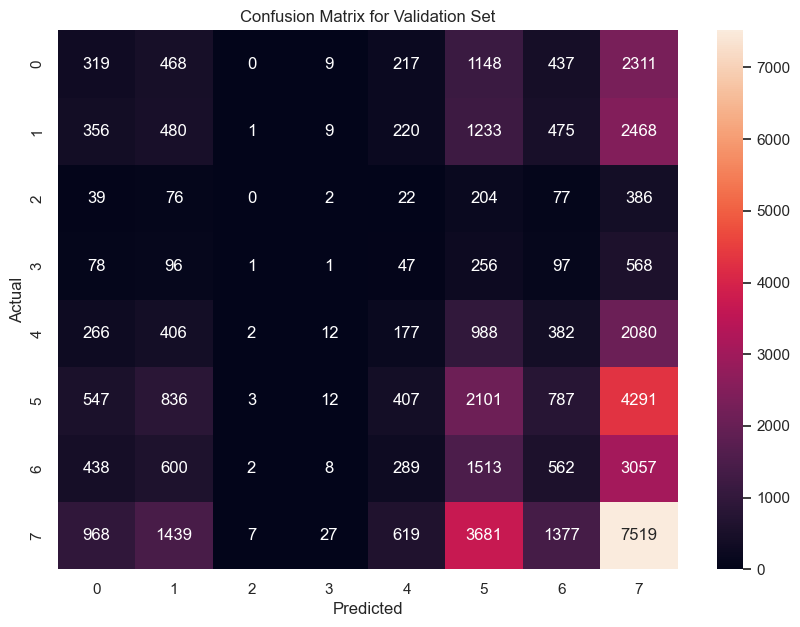

In [170]:
# confusion matrix
cm = confusion_matrix(y_train, y_train_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix for Validation Set')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# save the confusion matrix output to a png file
if SHOULD_SAVE_OUTPUT:
	plt.savefig(os.path.join(curr_run_dir, "nn_conf_matrix.png"))

plt.show()

In [171]:
# getting the metrics for the test data
accuracy = accuracy_score(y_train, np.rint(y_train_pred).astype(int))
print("Train Accuracy: {:.2f}%".format(accuracy * 100))
print("Kappa Cohen: {:.2f}".format(eval_wrapper(y_train, y_train_pred) * 100))
print()

# getting the metrics for the training data
# accuracy = accuracy_score(final_test_preds, np.rint(test_preds).astype(int))
# print("Test Accuracy: {:.2f}%".format(accuracy * 100))
# print("Kappa Cohen: {:.2f}".format(eval_wrapper(final_test_preds, test_preds) * 100))

Train Accuracy: 23.49%
Kappa Cohen: 0.51



In [172]:
# # define a prediction function of probabilities for the model
# def predict_proba(data):
    
#     # set the model to eval mode
#     baseline_model.eval()  

#     # turn off the gradient
#     with torch.no_grad():
        
#         # apply the softmax to get the class output probabilities
#         m_output = baseline_model(torch.tensor(data, dtype=torch.float))
#         probabilities = torch.softmax(m_output, dim=0)
#         return probabilities.numpy()

# # initialize the explainer
# explainer = lime_tabular.LimeTabularExplainer(
#     training_data=np.array(X_train),
#     feature_names=X_train.columns.tolist(),
#     class_names=['1', '2', '3', '4', '5', '6', '7', '8'],  
#     mode='classification'  
# )

# # explain a prediction from the validation set
# data_batch, labels_batch = next(iter(pca_train_loader))
# data_row = data_batch[0]

# for data_batch, labels_batch in pca_train_loader:
#     print("Batch data shape:", data_batch.shape)
#     print("Batch label shape:", labels_batch.shape)
#     break

# # convert the array to numpy if it is not already
# if hasattr(data_row, "numpy"):
#     data_row = data_row.numpy()

# # reshape it
# # data_row = data_row.reshape(1, -1)

# # get the shape
# print(f"data row shape: {data_row.shape}")

# # check with the proba
# # print(predict_proba(data_row))

# explanation = explainer.explain_instance(
#     data_row=data_row, 
#     predict_fn=predict_proba 
# )

# # visualize the explanation
# explanation.show_in_notebook(show_table=True, show_all=False)

# # Extracting explanation details
# exp_list = explanation.as_list()
# print(f"Explanation for instance {pred_idx_to_explain}:\n")
# for feature, effect in exp_list:
#     print(f"{feature}: {effect:.4f}")

# # Optionally, summarize the effect in terms of top features
# print("\nSummary:")
# print("Positive features (pushing towards class 1):")
# for feature, effect in filter(lambda x: x[1] > 0, exp_list):
#     print(f"  {feature}: {effect:.4f}")

# print("Negative features (pushing towards class 0):")
# for feature, effect in filter(lambda x: x[1] < 0, exp_list):
#     print(f"  {feature}: {effect:.4f}")


In [173]:
# define a function that can find the inverse matrix that we use for the mahalanobis distance over
# the entire dataset that we are currently considering
def mahalanobis_distance_matrix(all_data):

    # print status
    print("Computing Mahalanobis Matrix...")

    # check the data type to make sure that it is good
    if not isinstance(all_data, torch.Tensor):
        all_data = torch.tensor(all_data, dtype=torch.float)
    
    # # get the mean of all of the data that we are considering
    # mean = torch.mean(all_data, dim=0)
    
    # calculate the covariance matrix and its inverse
    cov_matrix = torch.cov(all_data.t())
    inv_cov_matrix = torch.inverse(cov_matrix)
    
    # return the inverse covariance matrix 
    return inv_cov_matrix

# function that computes the mahalanobis distance between two data points
# make sure that you pass a mahalanobis_cov_matrix matrix
# the mahalanobis_cov_matrix matrix should be the inverse covariance matrix
def compute_mahalanobis(data_1, data_2, mahalanobis_cov_matrix, verbose=0):

    data_1 = data_1.to('cpu')
    data_2 = data_2.to('cpu')

    # print the shapes
    if verbose:
        print(f"Shape of data_1: {data_1.shape}")
        print(f"Shape of data_2: {data_2.shape}")

    # compute the delta that we are going to put into the equation
    t_delta = data_2 - data_1 

    # get whether we should be verbose with this function or not
    if verbose:
        print(f"Shape of t_delta: {t_delta.shape}")
        print(f"mahalanobis_cov_matrix: {mahalanobis_cov_matrix.shape}")
        print()
    
    # compute Mahalanobis distance from the selected point to all other points
    part_1 = torch.matmul(t_delta, mahalanobis_cov_matrix)

    # get the second part of the equation
    part_2 = torch.matmul(part_1, t_delta.t())

    # if this is a float then return that
    if part_2.dim() > 0:
        diagonal = torch.diag(part_2)
    else:
        # if it is a matrix then return the matrix
        diagonal = part_2

    # get the sqrt
    m_distances = torch.sqrt(diagonal)
        
    # check if it is an instance of a tensor or not
    if not isinstance(m_distances, torch.Tensor):
        m_distances = torch.tensor(m_distances)

    if verbose:
        print(f"diagonal: {diagonal}")
        print(f"m_distances: {m_distances}")

    return m_distances


# define a function that gets the centroids of k clusters that I would get 
# if I ran a k-means clustering algorithm
def k_means_centers(input_features, cluster_num = 5):

    # convert all_features tensor to numpy for k-means
    features_np = input_features.cpu().detach().numpy()

    # run k-means clustering
    print(f"Computing KMeans...")
    kmeans = KMeans(n_clusters=cluster_num, random_state=0).fit(features_np)

    # extract centroids
    centroids = kmeans.cluster_centers_

    # convert centroids back to PyTorch tensor
    centroids_tensor = torch.tensor(centroids, dtype=torch.float32)

    # return the centroids that we get from the model that we have run
    return centroids_tensor


# getting the hierarchical clustering of the data which in some cases can prove to provide more information and 
# fidelity than k means clustering alone
def hierarchical_clustering(input_features, n_clusters=5):
    
    print(f"Computing Hierarchical Clustering...")

    # define the model and fit it
    clustering_model = AgglomerativeClustering(n_clusters=n_clusters)
    clustering_model.fit(input_features)

    # get the labels for the clusters (the centroids)
    labels = torch.tensor(clustering_model.labels_, dtype=torch.float32)

    return labels


# getting the dbscan centroids for the clustering of the data
def dbscan_clustering(input_features, eps=0.5, min_samples=5):
    
    print(f"Computing DBScan Clustering...")

    # define a model that we can use
    clustering_model = DBSCAN(eps=eps, min_samples=min_samples)
    clustering_model.fit(input_features)

    # return the labels (centroids)
    labels = torch.tensor(clustering_model.labels_, dtype=torch.float32)
    return labels


# another clustering method for finding blobs in a smooth density of samples
def mean_shift_clustering(input_features, bandwidth=None):
    
    print(f"Computing Mean Shift Clustering...")

    # def model for shifting the mean
    clustering_model = MeanShift(bandwidth=bandwidth)
    clustering_model.fit(input_features)

    # get the centroids of the data
    labels = torch.tensor(clustering_model.labels_, dtype=torch.float32)
    return labels

In [174]:
# now plot the regression histogram for the base model
# start correlation analysis with just a plain node correlation
# empty list for features
features_list = []

# keep track of the max distance
max_mahalanobis = 0


# getting all of the training data for correlation analysis
for features, _ in pca_train_loader:

    # move the features to the device
    # features = features.to(device)

    # add it to the features list
    features_list.append(features)


# concatenate all of the inputs that we are going to be using together
all_features = torch.cat(features_list, dim=0)



# get the centroids with that method
if clustering_method_name == 'k_means_centers':
    k_means_centers_variable = k_means_centers(pca_train_features, cluster_num=CLUSTER_NUM)



# move the covariance matrix to the right device
pca_mahalanobis_covariance_matrix = mahalanobis_distance_matrix(pca_train_features)
# pca_mahalanobis_covariance_matrix = pca_mahalanobis_covariance_matrix.to('cpu')

# array of all of the m distances that we are going to use
all_mahalanobis = []

# use tqdm to wrap the outer loop for a progress bar
for t_feature in tqdm(all_features, desc="Computing Mahalanobis distances"):

    # temp arr for mahalanobis distances corresponding to the distance from each of the K points from the clustering above
    t_m_arr = []

    # append all of the mahalanobis values
    for t_m_dist in k_means_centers_variable:

        # get the mahalanobis distance
        m_dist = compute_mahalanobis(t_m_dist, t_feature, pca_mahalanobis_covariance_matrix)

        # check whether this is a new max distance or not
        max_mahalanobis = max(abs(max_mahalanobis), m_dist)

        t_m_arr.append(m_dist)

    # store the distances
    all_mahalanobis.append(t_m_arr) 

# clear all of the intermediates in the model
global network_layer_outputs
clear_total_run()


Computing KMeans...
Computing Mahalanobis Matrix...


Computing Mahalanobis distances:  90%|█████████ | 42948/47504 [00:03<00:00, 11778.13it/s]

Computing Mahalanobis distances: 100%|██████████| 47504/47504 [00:04<00:00, 11283.43it/s]


Creating regression between variables...: 100%|██████████| 32/32 [00:11<00:00,  2.82it/s]


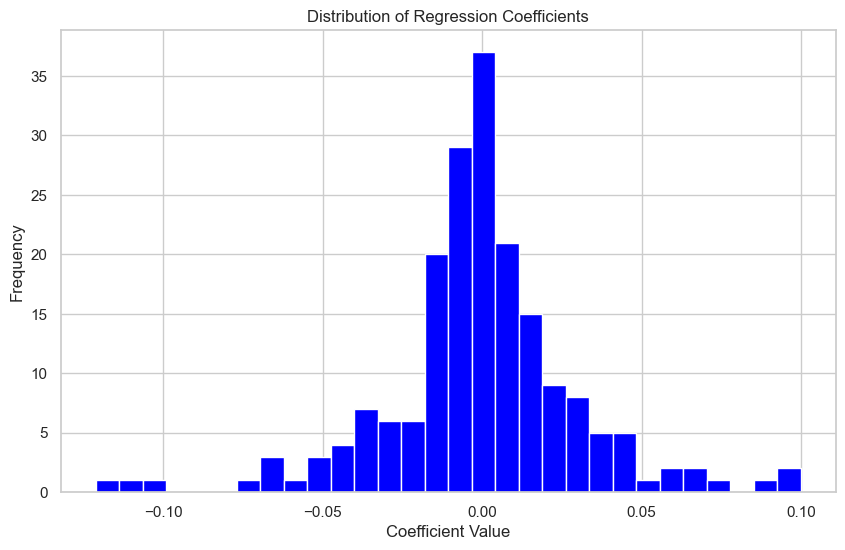

Coefficients Shape: (32, 6)


Plotting regression coefficients:  62%|██████▎   | 20/32 [00:05<00:03,  3.52it/s]/var/folders/d2/lsvbp7p92gnc5ql59sc72rx40000gn/T/ipykernel_85285/2495674400.py:148: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.

Plotting regression coefficients: 100%|██████████| 32/32 [00:08<00:00,  3.61it/s]


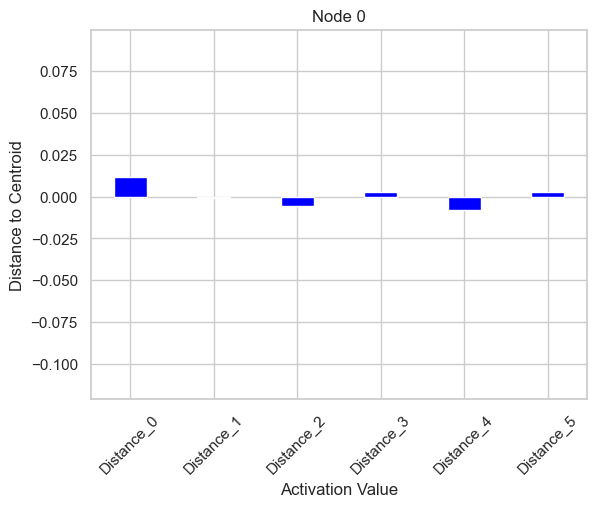

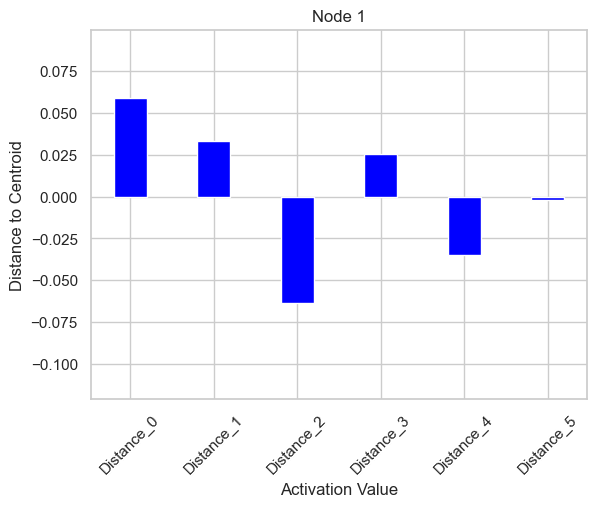

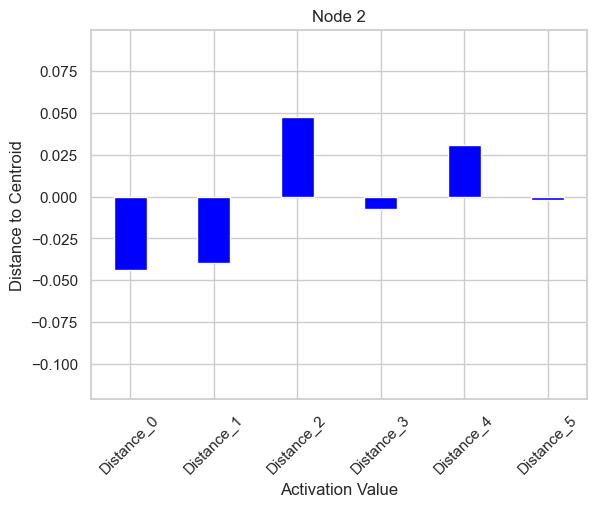

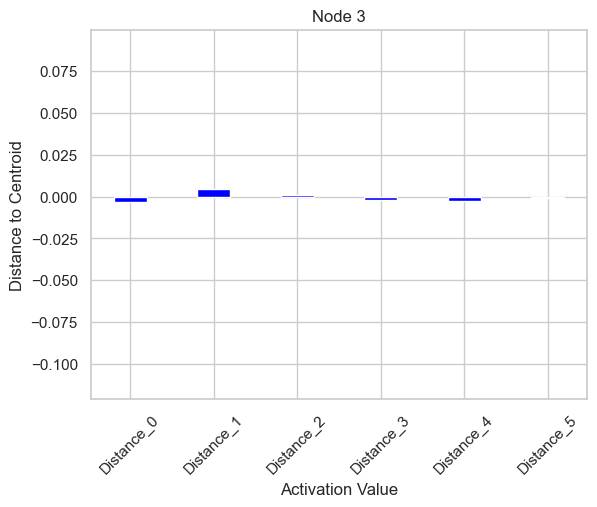

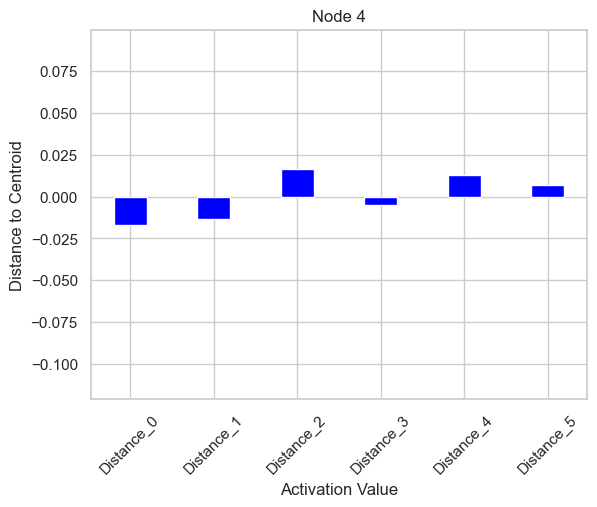

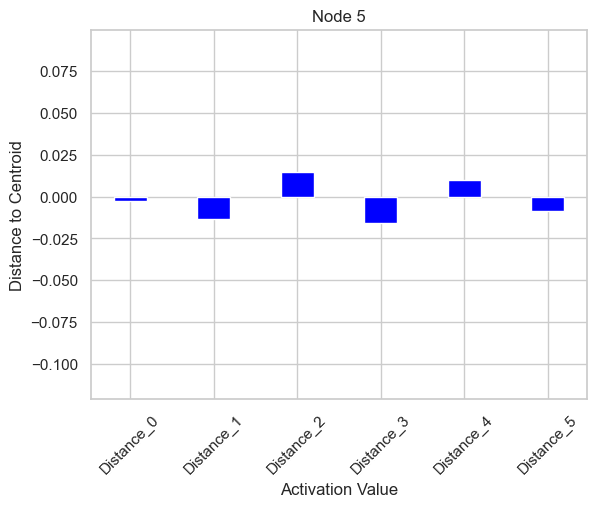

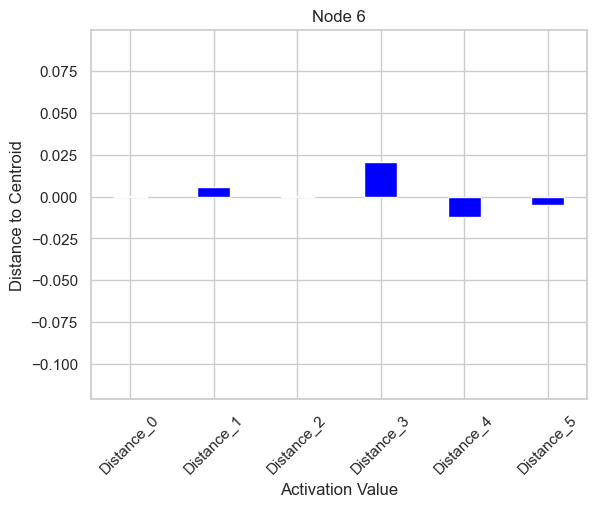

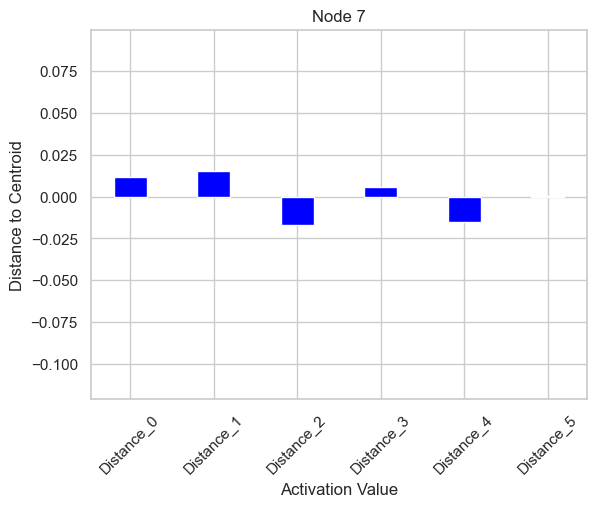

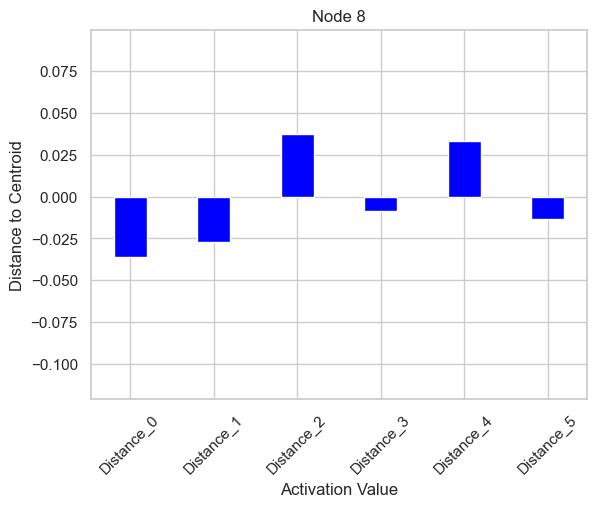

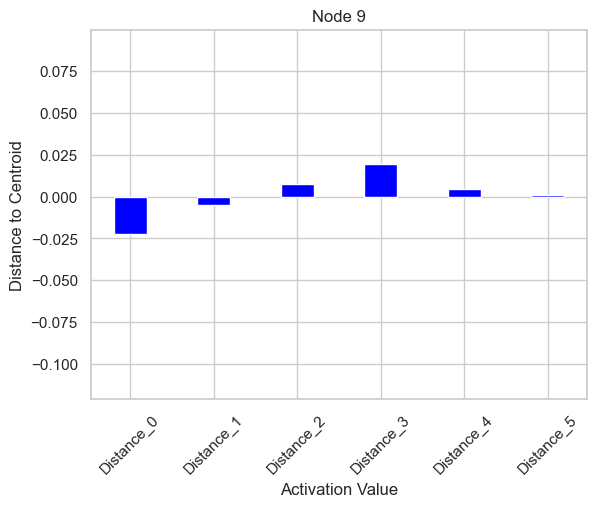

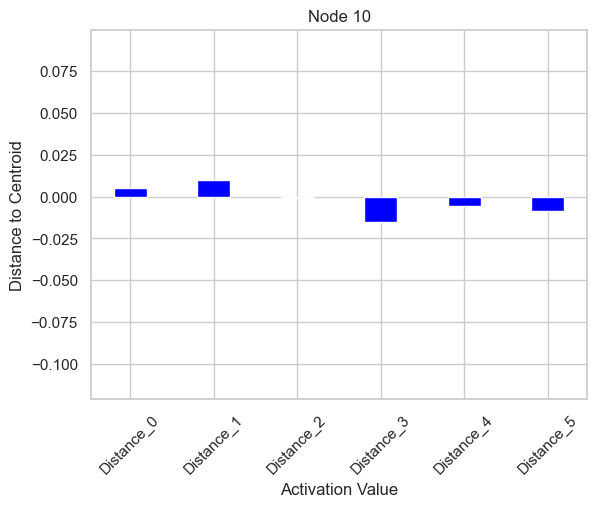

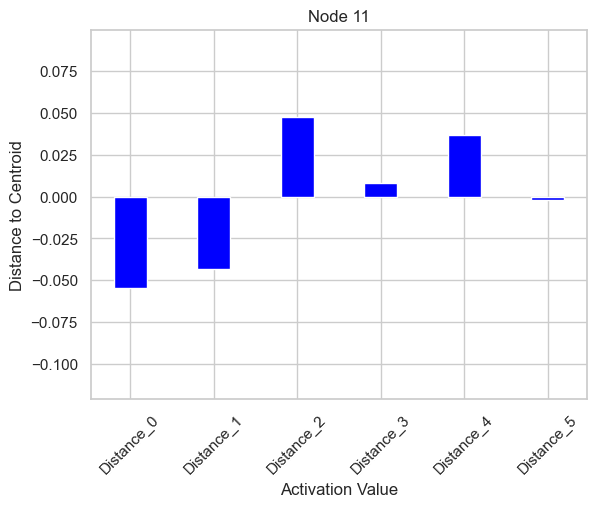

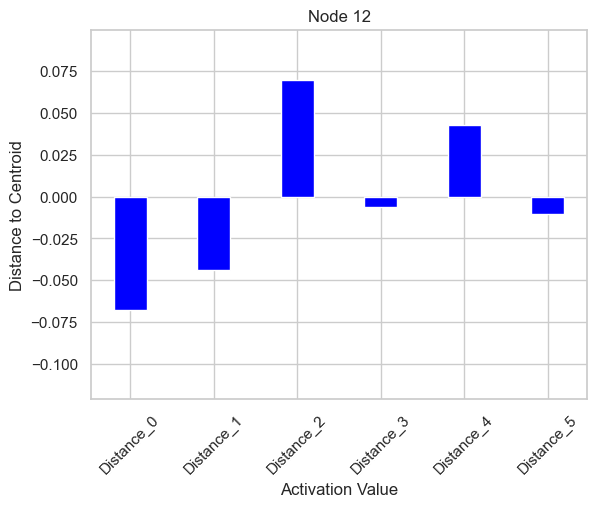

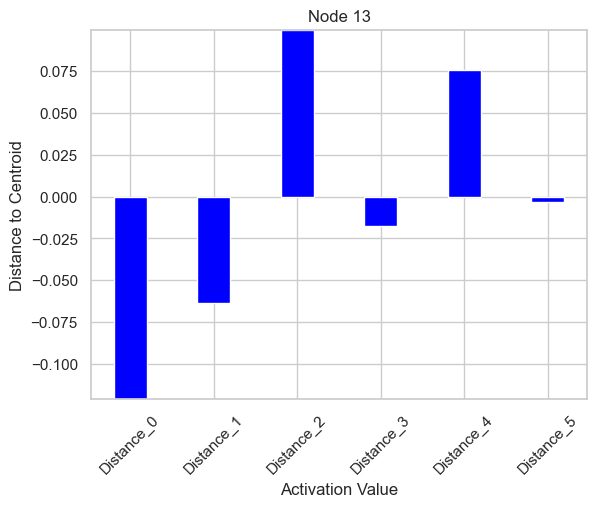

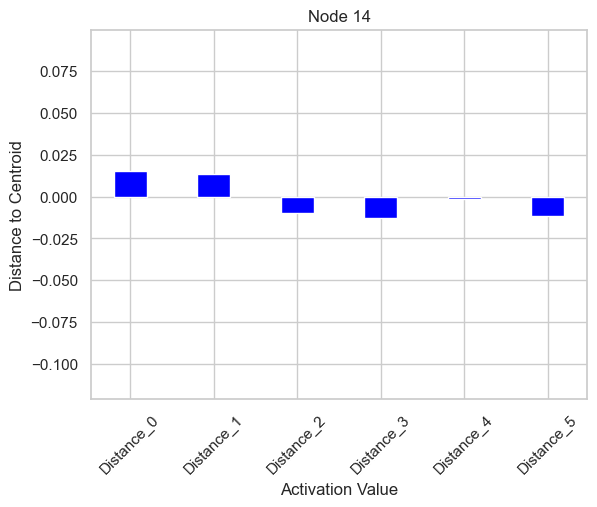

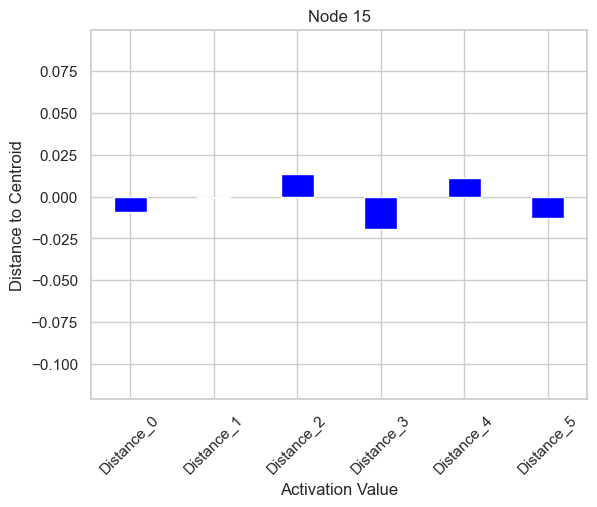

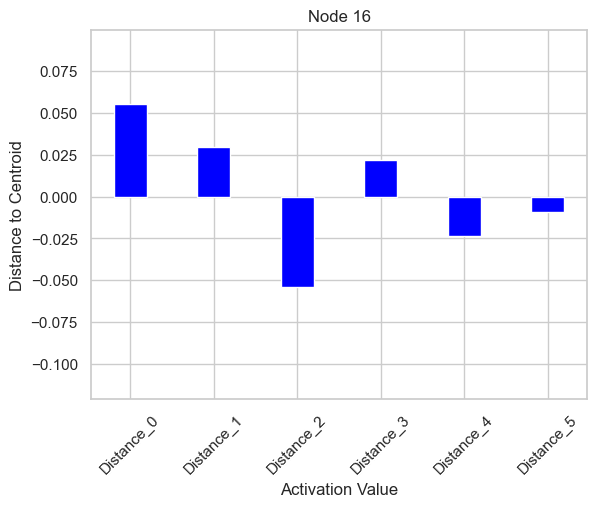

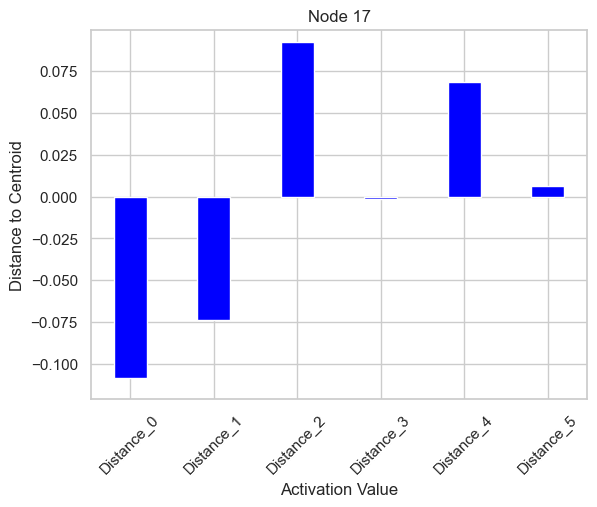

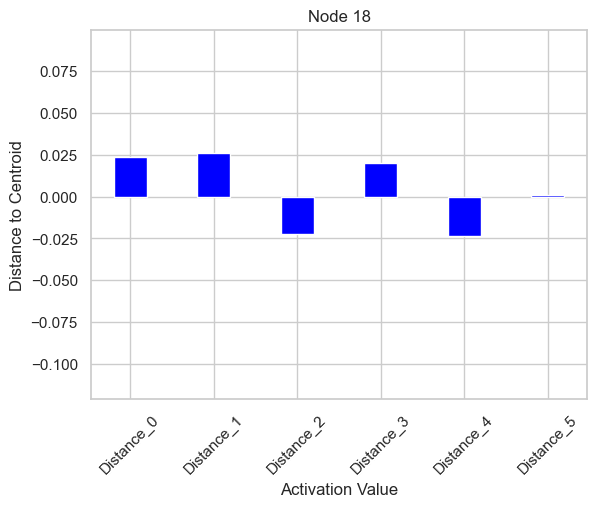

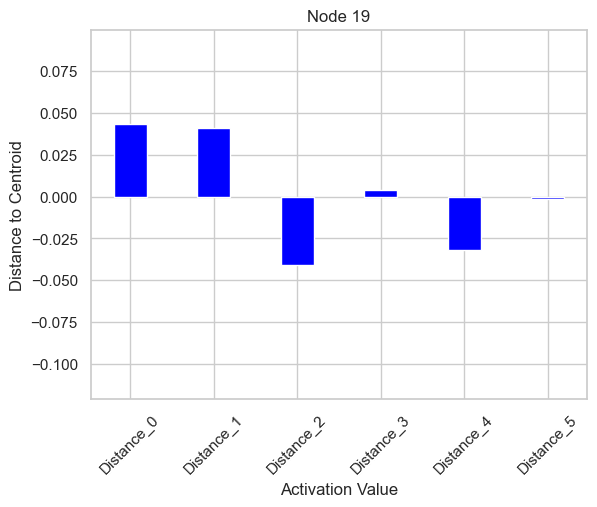

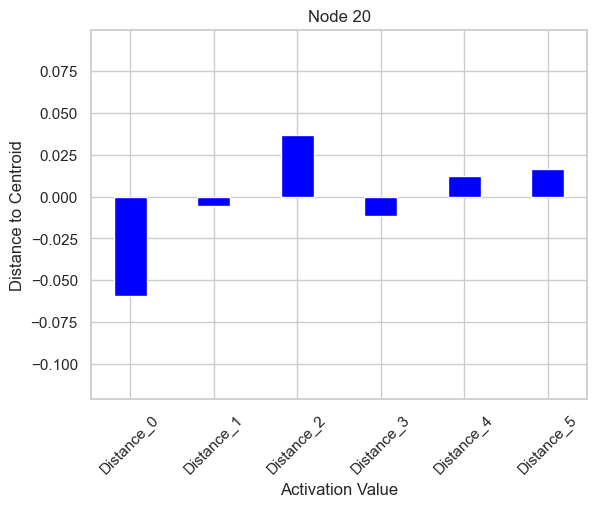

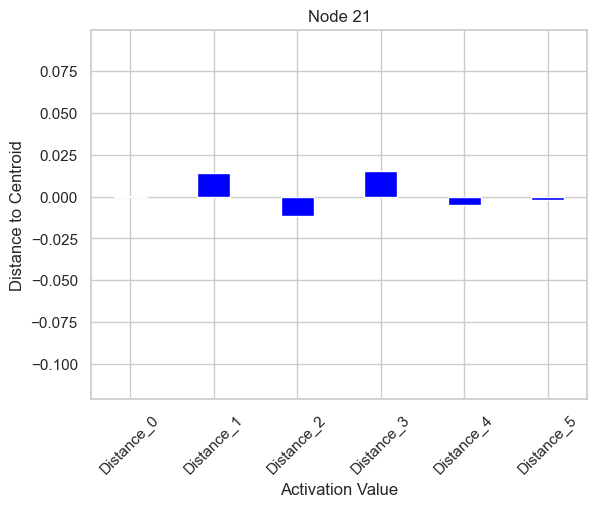

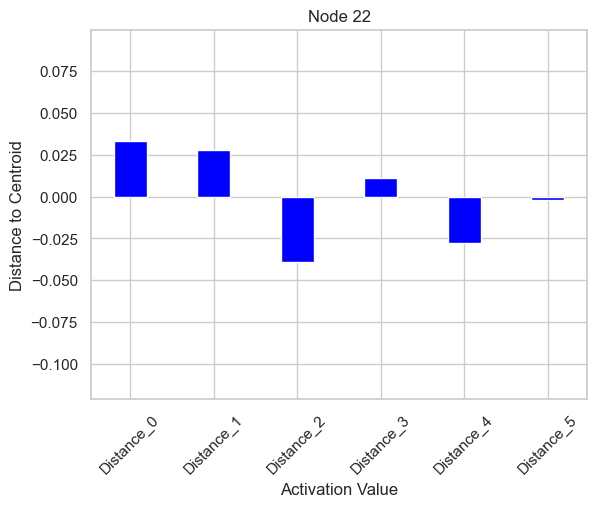

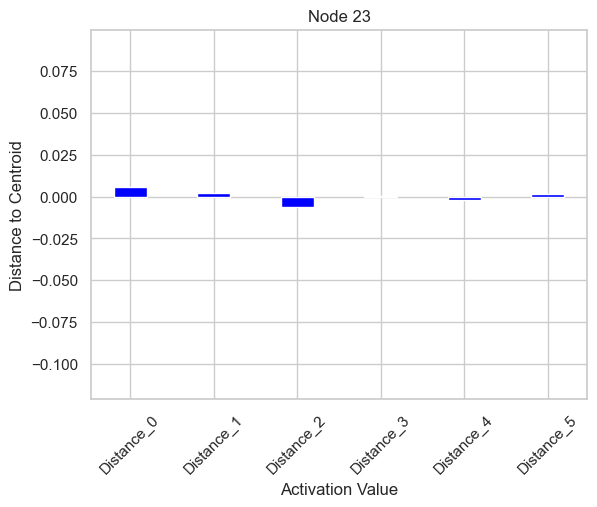

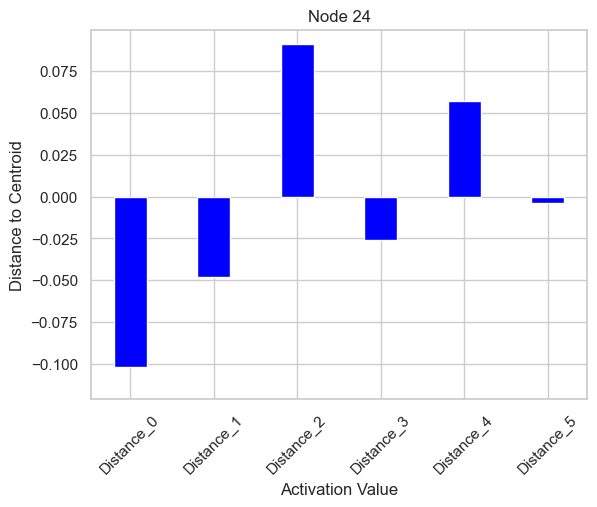

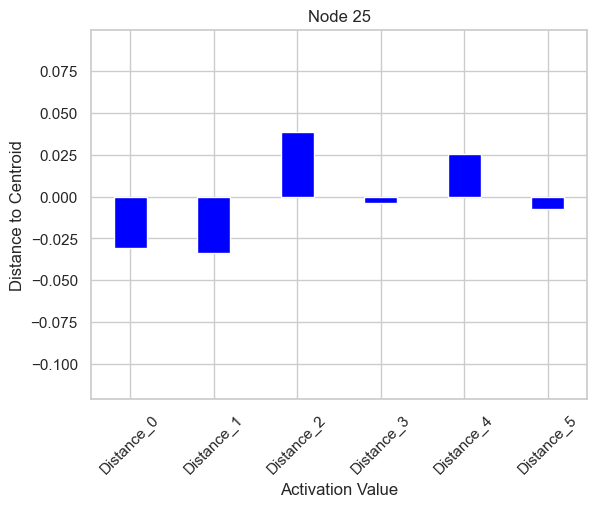

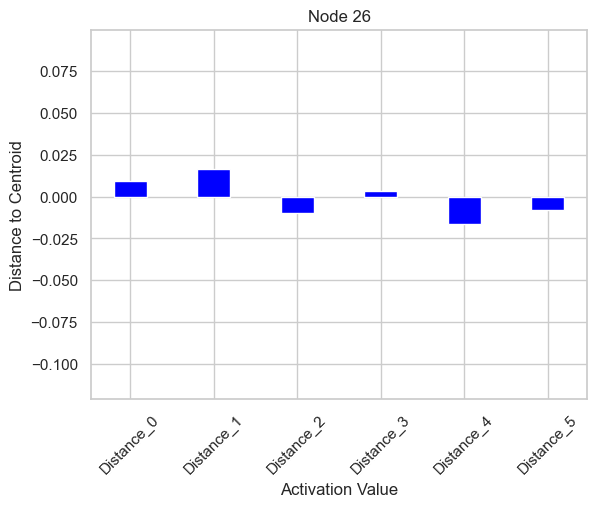

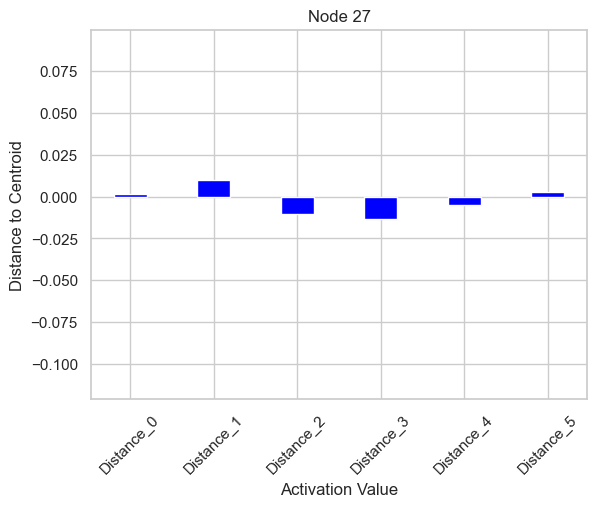

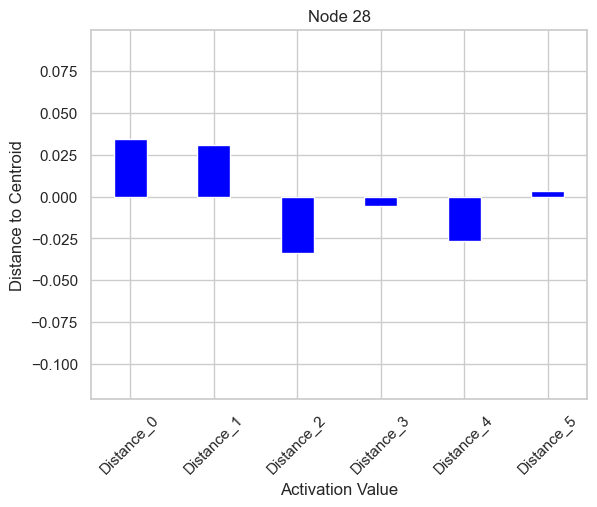

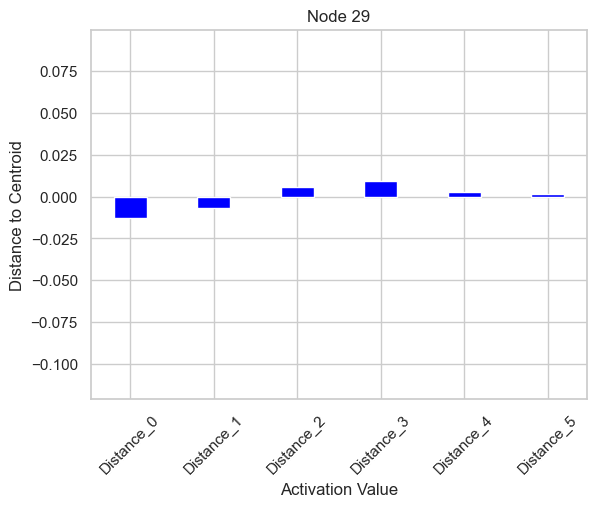

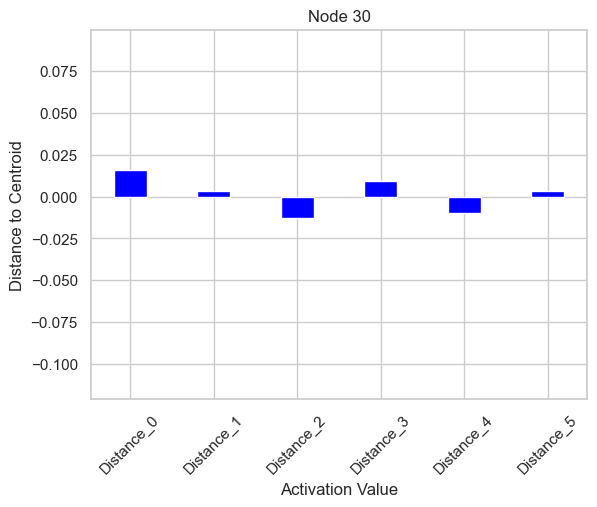

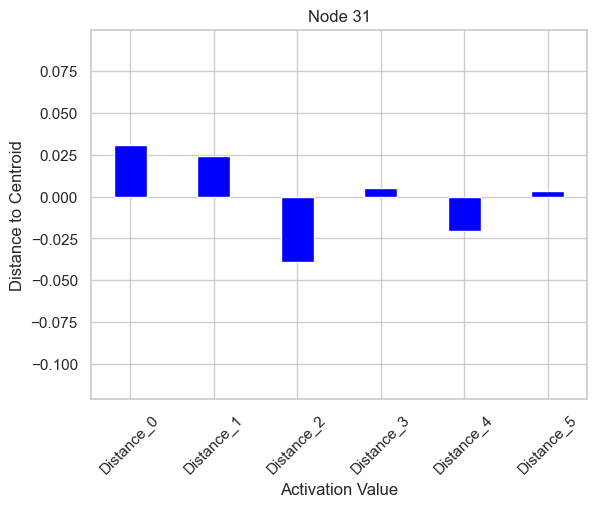

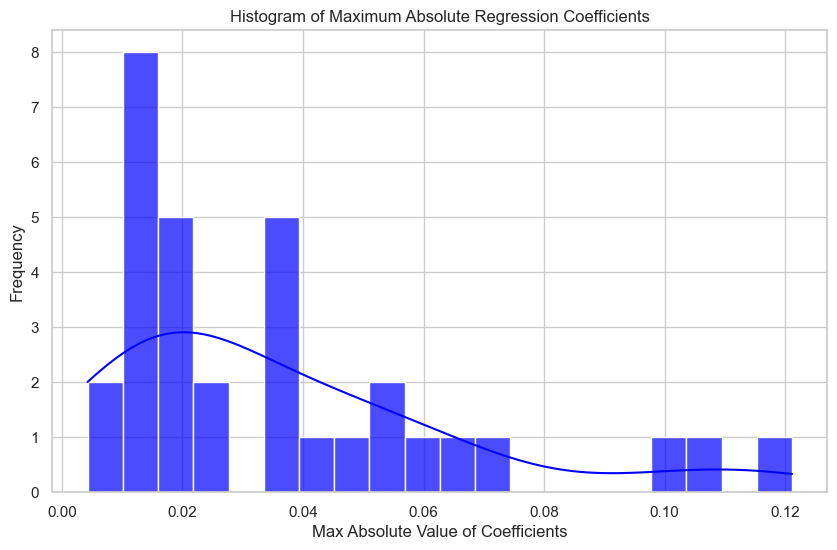

In [175]:


# keep track of the max distance
max_mahalanobis = 0

# move the model
baseline_model = baseline_model.to(device)

features_list = []

# getting all of the training data for correlation analysis
for features, _ in pca_train_loader:

    # move the features to the device
    # features = features.to(device)

    # add it to the features list
    features_list.append(features)

    # pipe it through the model
    outputs = baseline_model(features.to(device))
    
    # save the current passthrough to the list
    save_and_clear_current_pass_through()

# now get all of the outputs
baseline_model_intermediates = network_layer_outputs
clear_total_run()


# layer that we are considering
LAYER_IDX = 1

# the coefficients for the regressions that I am running
coefficients = []  
lower_bounds = []
max_abs_coefficients = []
upper_bounds = []

# go through each of the intermediate variables in the model and collect them
for i in tqdm(range(len(baseline_model_intermediates[0][LAYER_IDX][0])), desc="Creating regression between variables..."):

    # now we are going to get the ith element of the array
    current_node = []

    # adding all of the model intermediate values in 
    for j in range(len(baseline_model_intermediates)):
        for t_element in baseline_model_intermediates[j][LAYER_IDX][:, i]:
            current_node.append(t_element)


    # perform a regression between this element and the centroid distances

    # initialize a Linear Regression model
    linrg_model = LinearRegression()

    # convert the arrays to np arrays
    all_mahalanobis = np.array(all_mahalanobis)
    current_node = np.array(current_node)

    # print an update
    # print(f"Performing regression {i} between all_mahalanobis and current_node...")
    # print(f"Current Dimensions:\nall_mahalanobis shape{all_mahalanobis.shape}\ncurrent_node shape{current_node.shape}")

    # fit the regression
    linrg_model.fit(all_mahalanobis, current_node)


    # getting the maximum coefficient in the model
    max_abs_coef_index = np.argmax(np.abs(linrg_model.coef_))
    max_abs_model_coefficient = np.abs(linrg_model.coef_[max_abs_coef_index])
    max_abs_coefficients.append(max_abs_model_coefficient)
    
    
    # get the residuals and the standard error
    bound_preds = linrg_model.predict(all_mahalanobis)
    resid_vals = np.sum((current_node - bound_preds)**2)
    model_standard_error = np.sqrt(resid_vals / (len(current_node) - 2)) /  np.sqrt(np.sum((all_mahalanobis - np.mean(all_mahalanobis))**2))

    # now compute the 95% confidence bound for the model
    df = len(current_node) - 2
    t_critical = stats.t.ppf(1-0.025, df)

    # append the upper and lower bounds to the arrays that we are using to keep track
    ci_lower = max_abs_model_coefficient - t_critical * model_standard_error
    ci_upper = max_abs_model_coefficient + t_critical * model_standard_error

    lower_bounds.append(ci_lower)
    upper_bounds.append(ci_upper)
        
        
    # store the coefficient
    coefficients.append(linrg_model.coef_)





# plot the regression coefficients so that we can see what they are doing in the model
coefficients = np.array(coefficients)  

# flatten the array to get a single visualization
flat_coefficients = coefficients.flatten()

sns.set_theme(style="whitegrid")
sns.set_palette("magma")

# plot the information that we got
plt.figure(figsize=(10, 6))
plt.hist(flat_coefficients, bins=30, color='blue')
plt.title('Distribution of Regression Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Frequency')

if SHOULD_SAVE_OUTPUT:
    os.makedirs(os.path.join(curr_run_dir, "baseline_coeff_hist_plots"), exist_ok=True)
    plt.savefig(dpi=300, fname=os.path.join(curr_run_dir, "baseline_coeff_hist_plots", "reg_coeff_dist_hist.png"))

plt.show()


# now go through and make subplots for everything that we are doing
print(f"Coefficients Shape: {coefficients.shape}")

# get the number of coefficients for creating subplots
n_coeffs = coefficients.shape[1]

# labels of the coefficients
coeff_labels = [f"Distance_{x}" for x in range(coefficients.shape[1])]

# getting the minimum and the maximum value of the regressions
ymin = np.min(coefficients)
ymax = np.max(coefficients)

# create arrays that have the maximum absolute value coefficien tfrom each of them
# sort the arrays on the max vals now
baseline_max_abs_values = np.array(max_abs_coefficients)
baseline_sorted_indices = np.argsort(-baseline_max_abs_values)


# sort the elements on the argument order
baseline_sorted_max_abs_values = baseline_max_abs_values[baseline_sorted_indices]
baseline_sorted_lower_bounds = np.array([lower_bounds[i] for i in baseline_sorted_indices])
baseline_sorted_upper_bounds = np.array([upper_bounds[i] for i in baseline_sorted_indices])


# iterate through each of the possible coefficients that we are going to consider
for coeffs_idx in tqdm(range(coefficients.shape[0]), desc="Plotting regression coefficients"):
    
    plt.figure()

    # get the coefficients for that node in the matrix
    # plot on some subplot
    plt.bar(coeff_labels, coefficients[coeffs_idx], color ='blue', width = 0.4)
    
    # get the labeling information for the graph
    plt.title(f'Node {coeffs_idx}')
    plt.xlabel('Activation Value')
    plt.ylabel('Distance to Centroid')
    plt.xticks(rotation=45)

    # scale the y axis
    plt.ylim(ymin, ymax)

    if SHOULD_SAVE_OUTPUT:
        os.makedirs(os.path.join(curr_run_dir, "baseline_coeff_hist_plots"), exist_ok=True)
        plt.savefig(dpi=300, fname=os.path.join(curr_run_dir, "baseline_coeff_hist_plots", f"plt_coeff_{coeffs_idx}_node.png"))

    

# show the figure that we constructed
plt.show()


# plot the histrogram
plt.figure(figsize=(10, 6))
sns.histplot(baseline_sorted_max_abs_values, bins=20, kde=True, color='blue', alpha=0.7)
plt.title('Histogram of Maximum Absolute Regression Coefficients')
plt.xlabel('Max Absolute Value of Coefficients')
plt.ylabel('Frequency')  

if SHOULD_SAVE_OUTPUT:
	plt.savefig(dpi=300, fname=os.path.join(curr_run_dir, "baseline_coeff_hist_plots", "baseline_abs_coeff.png"))
     
plt.show()


In [176]:
# getting the difference in standard error bar sizes
delta = baseline_sorted_upper_bounds - baseline_sorted_lower_bounds

print(f"Mean error bar size: {delta.mean()}")

Mean error bar size: 0.009470126292565285


### Baseline Neural Network Results

The neural network does substantially better on the training data. We can see in the distribution of the data above that the predicted and the actual values match one another much more closely than the XGBoost model. Empirically, we have verified the commonly held belief that neural networks are better able to capture complex, nonlinear data which supports the need for more metrics specifically adapted to neural networks explainability. 

| Metric            |   Value    |
|:------------------|:----------:|
| Train Accuracy    |   52.89%   |
| Kappa Cohen (Train) |   65.10    |

Additionally, the LIME calculation for the model does not yield much actionable insight that we can use. Many of the results that the LIME model gives us have such extreme values with low numbers of data points informing their creation that I would be hesitant to apply their results. 

# Start of Custom Loss Function

This is the start of the custom loss function that we are going to integrate for the explainability of the neural network. Recall from the proposal that the format for this loss function will be 

$$L(i) = L_{\text{base}} + \lambda \times e^{\alpha^{i}} \times L_{\text{layer-wise}} + \beta \times L_{\text{contrastive}}(i)$$

where the values of the equation are as follows:


- $L(i)$ represents the total loss corresponding to the $i^{th}$ layer.
- $L_{\text{base}}$ stands for the model's basic training loss over all the data.
- $\lambda$ is a factor to control for the strength of the loss term.
- $e^{\alpha^i}$ is an exponential factor that helps us change the outcome with the depth of the model.
- $\alpha$ is a value controlling the strength of the layer number's influence.
- $i$ is the index of the viewed layer.
- $L_{\text{contrastive}}(i)$ is a value that represents the contrast between items of separate classes in later layers.

In [177]:
# # change the structure of the surface
# from matplotlib import cm
# from matplotlib.ticker import LinearLocator

# # turn it on so that we can move the graph around
# # %matplotlib widget

# # plot the loss landscape that we are using to adjust the hyperparameters
# k = 2
# p = 1
# l_max = 10
# m_max = 10
# num_nodes = 100

# # loss equation
# # r_inputs = np.floor((1 / k) * ((l / l_max) ** p) * (m / m_max))

# # plot the landscape
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# # make data
# X = np.arange(0, l_max, 0.25)
# Y = np.arange(0, m_max, 0.25)
# X, Y = np.meshgrid(X, Y)

# # corrected loss equation calculation
# nodes_ceil = (1 / k) * num_nodes
# Z = np.floor(nodes_ceil * (np.sin((np.pi / 2) * np.power((X / l_max), p)) * (np.sin((np.pi / 2) * (Y / m_max)))))

# # plot the surface
# surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# # customize the z axis
# z_min, z_max = Z.min(), Z.max()
# ax.set_zlim(z_min, z_max)

# # set the axes
# ax.zaxis.set_major_locator(LinearLocator(10))
# ax.zaxis.set_major_formatter('{x:.02f}')

# # add a color bar which maps values to colors.
# fig.colorbar(surf, shrink=0.5, aspect=5)

# plt.show()








### Extra code for faster network output visualization:

# modification: use a dictionary to store outputs with layer names as keys
# network_layer_outputs = {}

# # update the hook function to store outputs in a dictionary
# def get_layer_output_hook(module, input, output):
#     # use the module's name as the key. if the module doesn't have a name, use its type.
#     layer_name = id(module)  # or use module.__class__.__name__ for type name as key
#     if module not in network_layer_outputs:
#         network_layer_outputs[layer_name] = []
#     network_layer_outputs[layer_name].append(output.cpu().detach())

# # modification in hook registration to handle inhomogeneous layer outputs
# def register_hooks(model):
#     for layer in model.children():
#         if isinstance(layer, nn.Module):
#             layer.register_forward_hook(get_layer_output_hook)
#             print(f"registered a forward hook at: {layer}")



#### extra code to make it so that we keep track of the mean and variance of each of the layer outputs
# layer_stats = {
#     'fc1': {'mean': None, 'variance': None, 'count': 0},
#     'fc2': {'mean': None, 'variance': None, 'count': 0},
#     'fc3': {'mean': None, 'variance': None, 'count': 0}
# }

# def update_running_stats(layer_name, new_data):
#     stats = layer_stats[layer_name]
#     count, mean, M2 = stats['count'], stats['mean'], stats['variance']
#     count += new_data.shape[0]  # Assuming new_data is a batch, update count per sample
#     delta = new_data - mean
#     mean += delta.sum(dim=0) / count
#     delta2 = new_data - mean
#     M2 += (delta * delta2).sum(dim=0)
#     variance = M2 / count if count > 1 else torch.zeros_like(M2)

#     # Update stats
#     layer_stats[layer_name] = {'mean': mean, 'variance': variance, 'count': count}

# def get_layer_output_hook(module, input, output):
#     layer_name = module._get_name()
#     if layer_stats[layer_name]['mean'] is None:
#         # Initialize mean and variance with the same shape as output
#         layer_stats[layer_name]['mean'] = torch.zeros_like(output.data.mean(dim=0))
#         layer_stats[layer_name]['variance'] = torch.zeros_like(output.data.var(dim=0, unbiased=False))

#     # Assuming output is a tensor where the first dimension is the batch size
#     update_running_stats(layer_name, output.data)


In [178]:

# this function computes the step up of the loss that we are going to be using
# make sure that the input has not been put through a sigmoid or anything along those lines yet
def get_m_adjusted_value(mahalanobis_distance_arr, g_mahalanobis_arr, g_current, current_layer_idx, total_layers):

    # print(f"mahalanobis_distance_arr shape: {mahalanobis_distance_arr[0].shape}")
    # print(f"mahalanobis_distance_arr: {mahalanobis_distance_arr}")

    # first make sure that the mahalanobis distance is normalized within the allowed bounds
    # using the sigmoid function
    mahalanobis_distance_arr = [1 / (1 + math.exp(-m_dist)) for m_dist in mahalanobis_distance_arr]

    # now get the step up
    sum_term = sum([t_m_dist * (1 / torch.abs(g_current - g_mahalanobis)**2) + (1 - t_m_dist) * torch.abs(g_current - g_mahalanobis)**2 for (t_m_dist, g_mahalanobis) in zip(mahalanobis_distance_arr, g_mahalanobis_arr)])

    # multiply the loss by the index of the layer that we are considering
    weighted_loss = torch.sqrt(np.abs(total_layers / (np.abs(depth_revert_grad_boost * total_layers - current_layer_idx) + 1))) * sum_term

    # normalize for the length of the distance array
    weighted_loss = mahalanobis_distance_arr / len(mahalanobis_distance_arr)

    # now put it through the hyperbolic tangent function
    hyperbolic_loss = np.tanh(weighted_loss)

    # return the powers
    powered_loss = np.power(2, hyperbolic_loss)

    # put the losses to a power so that we can change the impact
    return powered_loss








# define a neural network that we can customize the inputs and outputs for each layer for
class NodeImportanceNN(nn.Module):

    # initialize the insurance neural network item
    def __init__(self):
        super(NodeImportanceNN, self).__init__()
        
        # define the layers that we are going to use for the neural network
        self.fc1 = nn.Linear(pca_train_features.shape[1], 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, NUM_CLASSES)  

    # go forward through the neural network
    def forward(self, x):

        global current_pass_through
        
        # append the initial input to the pass-through array
        current_pass_through.append(x.cpu().detach())

        # define a dictionary that we are going to be using to keep track of the losses
        # output_dict = {}
        # curr_idx = 0

        x = F.relu(self.fc1(x))
        # output_dict[str(curr_idx)] = x
        # curr_idx += 1

        x = F.relu(self.fc2(x))
        # output_dict[str(curr_idx)] = x
        # curr_idx += 1

        x = self.fc3(x)
        # output_dict[str(curr_idx)] = x
        # curr_idx += 1

        # return the overall loss dictionary with the output
        return x

    # this function returns the probabilities for different classes from the neural network model
    def predict_proba(self, x, device='cpu'):
        
        # set the network to evaluation mode
        self.eval()  
        
        with torch.no_grad():
        
            # pass through the model
            x = x.to(device)
            outputs = self(x)

            # get the probabilities
            out_probs = F.softmax(outputs, dim=1)

            return out_probs

    # defining a fit function to appease the marginal probability regression function
    def fit(self, train_loader, epochs, optimizer, criterion, device='cpu'):
        
        # move everything to devices
        self.to(device)
        self.train()

        # iterate through some amount of epochs to train the model
        for epoch in range(epochs):

            for inputs, labels in train_loader:
            
                # move everything to the right devices
                inputs = inputs.to(device) 
                labels = labels.to(device)

                # reset the optimizer that we are using
                optimizer.zero_grad()
                outputs = self(inputs)

                # calc the loss
                loss = criterion(outputs, labels)
                
                # backprop the loss
                loss.backward()
                optimizer.step()
            
            # print epoch information
            print(f'epoch: {epoch+1}/{epochs} | loss: {loss.item():.4f}')




# initialize the model
augmented_model = NodeImportanceNN()

# initializing a gradient scaler for the training loop
scaler = GradScaler()

# actually register the hooks on the model
register_hooks(augmented_model)





Registering hooks...


In [226]:


# this function computes the distances and centroids for the data
# it follows the scheme that we have defined above that computes the distance between the centroid
# and the data that we give it
def mahalanobis_forward_pass(nn_model, all_features, centroids):

    # move the model to the right device
    nn_model.to(device)

    # getting the covariance matrix
    print(f"Computing mahalanobis matrix...")
    global pca_mahalanobis_covariance_matrix
    # global total_mahalanobis_covariance_matrix

    # check which one we need
    # if all_features.shape[1] == NUM_PCA_PC:
    m_mat = pca_mahalanobis_covariance_matrix
    # else:
    #     m_mat = total_mahalanobis_covariance_matrix

    # move the covariance matrix to the right tool
    # m_mat = m_mat.to('cpu')

    # mahalanobis_covariance_matrix = mahalanobis_distance_matrix(all_features)
    # mahalanobis_covariance_matrix = mahalanobis_covariance_matrix.to(device)

    print(f"Getting the mahalanobis distances...")

    # array of all of the m distances that we are going to use
    global all_mahalanobis
    all_mahalanobis = []

    # use tqdm to wrap the outer loop for a progress bar
    for t_feature in tqdm(all_features, desc="Computing Mahalanobis distances"):

        # move it to the right device
        # t_feature = t_feature.to(device)

        # temp arr for mahalanobis distances corresponding to the distance from each of the K points from the clustering above
        t_m_arr = []

        # append all of the mahalanobis values
        for t_m_dist in centroids:

            # move it to the right device
            # t_m_dist = t_m_dist.to(device)

            # get the distance and append it
            m_dist = compute_mahalanobis(t_m_dist, t_feature, m_mat)
            t_m_arr.append(m_dist)

        # store the distances
        all_mahalanobis.append(t_m_arr) 


    # do a forward pass on the model for each of the centroids
    for t_center in centroids:
        _ = nn_model(t_center.to(device).unsqueeze(0))
        save_and_clear_current_pass_through()

    # store the outputs of the centroid
    global network_layer_outputs
    centroid_passes = network_layer_outputs

    # clear the outputs
    clear_total_run()

    return (all_mahalanobis, centroid_passes)



# custom training function to incorporate the custom loss function that we are using
# that tries to increase the variance of each of the layers
# intensity_val increases the intensity of tanh to ensure that the output is closer to -1, 1 with higher intensity
def train_model_with_variance(nn_model, train_loader, val_loader, variance_criterion, optimizer, all_mahalanobis, centroid_coords, centroid_passes, m_cov_mat=None, epochs=10, patience=2, verbose=0, percent_way_through_model_emphasize=0.75, intensity_val=5, limit_layers=False, training_pca_and_full=False, sum_epsilon=None):

    # move everything to devices
    nn_model = nn_model.to(device)

    # move the centroids
    centroid_coords = centroid_coords.to(device)

    # keep track of the cov matrix
    global pca_mahalanobis_covariance_matrix
    # global total_mahalanobis_covariance_matrix

    # check which one we need
    i_dat, _ = next(iter(train_loader))
    # if i_dat.shape[1] == NUM_PCA_PC:
    m_mat = pca_mahalanobis_covariance_matrix
    # else:
    #     m_mat = total_mahalanobis_covariance_matrix

    # best validation loss that we have seen so far
    best_val_loss = float('inf')

    # how long are we waiting for the validation to improve
    patience_counter = 0

    # keep track of the largest mahalanobis distance
    max_mahalanobis = max(abs(val) for sublist in all_mahalanobis for val in sublist)

    # keep track of how many layers are in our network
    num_layers_learnable = sum(1 for _ in nn_model.children())

    # get the global passthrough variable
    global current_pass_through

    # keeping track of the losses
    train_losses = []
    val_losses = []
    epochs_list = []

    # TEMPORARY
    # keeping track of the min and max
    # min_values = []
    # max_values = []

    # train for some amount of epochs
    for epoch in range(epochs):

        # clear all of the information from the network
        clear_total_run()

        # model in training mode
        nn_model.train()
        running_loss = 0.0

        # go through each of the inputs
        for (inputs, labels) in tqdm(train_loader, desc="Processing data for epoch"):
            
            # turn the gradient to zero
            optimizer.zero_grad()

            # check if we are operating with one or two outputs from the loader
            if training_pca_and_full:
                
                pca_inputs = inputs[0]
                pca_inputs = pca_inputs.to(device)
                
                inputs = inputs[1]

            # move inputs to device
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # initialize a scaler that can get the loss    
            with autocast():
                outputs = nn_model(inputs)
                loss = variance_criterion(outputs, labels)
            
            # back propogate the loss
            scaler.scale(loss).backward()

            # update the scaler as well
            scaler.step(optimizer)
            scaler.update()
            

            # initial_gradients = {}
            # for name, param in model.named_parameters():
            #     if param.requires_grad:
            #         # Make sure gradients exist by performing a backward pass wherever needed
            #         # This line assumes gradients have already been computed
            #         initial_gradients[name] = param.grad.clone()

            # keep track of the layer that we are currently looking at 
            current_layer_idx = 0

            # # track whether we have done a full layer pass
            # full_model_grad_adj = False
            # total_gradients = []

            # adjust the gradients so that they reflect the mahalanobis distances
            with torch.no_grad():

                # change the gradients
                for layer_idx, (name, param) in enumerate(nn_model.named_parameters()):
                    
                    # # initialize a test gradient
                    # try:
                    #     test_grad_adj = torch.ones_like(gradient_adjustment_final)
                    # except:
                    #     test_grad_adj = None

                    # check if this is a weights matrix that we are changing
                    if "weight" in name:  

                        # get the passthroughs of the most recent pass
                        intermediate_outputs = current_pass_through[current_layer_idx + 1].to(device)

                        if verbose:
                            print(f"intermediate_outputs shape: {intermediate_outputs.shape}")

                        # keeping track of the distance of each of the random points that we choose
                        # mahalanobis_distance_arr = []

                        if verbose:
                            print(f"inputs: {inputs.shape}")

                        # compute the denominator
                        layer_normalization = np.exp(-(np.power(((current_layer_idx / num_layers_learnable) - percent_way_through_model_emphasize), 2)))

                        # normalize for the number of centers that we have
                        centroid_len_norm = (1 / len(centroid_coords))

                        # init the denominator exponent
                        summation_result = 0


                        # go through each of the mahalanobis values, getting the intermediate values
                        for centroid_number, t_centroid in enumerate(centroid_coords):

                            # get the m-distance
                            # print(f"t_centroid: {t_centroid.shape}")
                            if training_pca_and_full:
                                m_dist = compute_mahalanobis(t_centroid, pca_inputs, m_mat, verbose=verbose)
                            
                            else:
                                m_dist = compute_mahalanobis(t_centroid, inputs, m_mat, verbose=verbose)
                            # m_dist = compute_mahalanobis(t_centroid, inputs, mahalanobis_covariance_matrix, verbose=1)
                            # mahalanobis_distance_arr.append(m_dist)

                            # change the gradients by whether they are helping or hurting us

                            # get the adjusted mahalanobis distance
                            mahalanobis_norm = m_dist / max_mahalanobis

                            # get the differences of the outputs
                            abs_output_diff = np.abs(current_pass_through[current_layer_idx + 1] - centroid_passes[centroid_number][current_layer_idx + 1])

                            # multiply the matrices
                            # reshape mahalanobis_norm for broadcasting
                            # mahalanobis_norm_expanded = mahalanobis_norm.unsqueeze(1) 
                            mahalanobis_norm_expanded = mahalanobis_norm.to(device)

                            # transform it to sigmoid
                            sigmoid_difference = 1 / (1 + np.exp(-abs_output_diff))
                            sigmoid_difference = sigmoid_difference.to(device)

                            # get the positive mahalanobis portion
                            positive_mahalanobis = (mahalanobis_norm_expanded) * sigmoid_difference.T

                            # get the negative mahalanobis portion
                            negative_mahalanobis = (1 - mahalanobis_norm_expanded) * (1 - sigmoid_difference).T

                            # get the centroid adjustment
                            centroid_adjustment = negative_mahalanobis + positive_mahalanobis
                            
                            if verbose:
                                print(f"current_pass_through {current_pass_through}")
                                print(f"centroid_adjustment: {centroid_adjustment}")
                                print(f"centroid_adjustment shape: {centroid_adjustment.shape}")
                            
                            # check and adjust the number of dimensionsions in the tensors
                            tensor_1 = (current_pass_through[current_layer_idx])
                            tensor_2 = (current_pass_through[current_layer_idx + 1] - centroid_passes[centroid_number][current_layer_idx + 1])

                            # check the dimensions of the tensors                    
                            if tensor_1.dim() == 1:
                                tensor_1 = tensor_1.unsqueeze(1)

                            # check the dimensions of the tensors                                        
                            if tensor_2.dim() == 1:
                                tensor_2 = tensor_2.unsqueeze(0)


                            # compute the sign that we are going to permute
                            # print(f"param.data.shape: {param.data.shape}")

                            if USE_BATCHES:
                                tensor_1 = tensor_1.T

                            # print(f"tensor_1: {tensor_1.shape} tensor_2: {tensor_2.shape} ")

                            sign_vector = torch.sign(torch.matmul(tensor_1, tensor_2)).to(device)
                            
                            if verbose:
                                print(f"sign_vector shape: {sign_vector.shape}")
                            

                            # multiply by the sign vector multiplied element-wise with a normalized weights matrix to attribute push
                            # perform the multiplication to normalize
                            modified_weights = torch.mul(param.data, sign_vector.T).to(device)

                            column_sums = modified_weights.sum(dim=0, keepdim=True)
                            normalized_weights = modified_weights / column_sums
                            if verbose:
                                print(f"normalized_weights shape: {normalized_weights.shape}")

                            # get the means for each of the batches
                            centroid_adjustment = centroid_adjustment.T.mean(dim=0, keepdim=True)
                            if verbose:                            
                                print(f"centroid_adjustment shape: {centroid_adjustment.shape}")

                            # add the result to the sum of all of the results
                            # print(f"normalized_weights.T: {normalized_weights.T.shape}")
                            # print(f"centroid_adjustment: {centroid_adjustment.shape}")
                            # print(f"(normalized_weights.T * centroid_adjustment).T: {(normalized_weights.T * centroid_adjustment).T.shape}")
                            summation_result += adj_weight * (normalized_weights.T * centroid_adjustment).T
                            # summation_result += torch.matmul(normalized_weights.T, centroid_adjustment.T)


                            # # get the negative mahalanobis portion
                            # negative_mahalanobis = (1 - mahalanobis_norm_expanded) * abs_output_diff

                            # # get the positive mahalanobis portion
                            # positive_mahalanobis = (mahalanobis_norm_expanded) * (1 / (abs_output_diff + 0.0000000001))
                            
                            # # get the summated denominator
                            # denom_exponent += (positive_mahalanobis + negative_mahalanobis)

                            # normalize for the layer count and the number of centroids
                            # denom_exponent *= layer_normalization
                            # denom_exponent *= centroid_len_norm

                            # # get the final denominator
                            # final_denominator = 1 + np.exp(-denom_exponent)

                            # # figure out the numerator
                            # grad_delta = 1 + (sign_vector / final_denominator)


                        # adjust the simulation gradient delta
                        summation_result *= layer_normalization
                        summation_result *= centroid_len_norm

                        # compute the sigmoid of the summation
                        summation_result = torch.tanh(intensity_val * summation_result)

                        # get the new gradient adjustment
                        gradient_adjustment_final = 1 + summation_result

                        # print(f"grad_delta: {gradient_adjustment_final}")
                        # min_val = torch.min(gradient_adjustment_final).item()
                        # max_val = torch.max(gradient_adjustment_final).item()
                        # min_values.append(min_val)
                        # max_values.append(max_val)

                        if verbose:
                            min_val = torch.min(gradient_adjustment_final).item()
                            max_val = torch.max(gradient_adjustment_final).item()
                            print(f"Max: {max_val}, Min: {min_val}")
                            print(f"layer_normalization: {layer_normalization}")
                            print(f"centroid_len_norm: {centroid_len_norm}")

                        # print(f"param.grad.data: {param.grad.data.shape}")
                        # print(f"gradient_adjustment_final: {gradient_adjustment_final.shape}")

                        # adjust the weights matrix to reflect the corrected gradients
                        if not limit_layers or (limit_layers and layer_idx == 2):
                            # print(gradient_adjustment_final)
                            if SUM_WEIGHT:
                                if sum_epsilon is None:
                                    param.grad.data += SUM_EPSILON * (gradient_adjustment_final - 1)
                                    pass
                                else:
                                    param.grad.data += sum_epsilon * (gradient_adjustment_final - 1)
                            else:
                                param.grad.data *= gradient_adjustment_final
                                pass

                        # if test_grad_adj is not None:
                        #     print(f"test_grad_adj: {test_grad_adj}")
                        #     print(f"gradient_adjustment_final: {gradient_adjustment_final}")
                        #     test_grad_adj *= gradient_adjustment_final
                        # else:
                        #     test_grad_adj = gradient_adjustment_final

                        # increment the layer
                        current_layer_idx += 1

                # # change it to true
                # full_model_grad_adj = True

            # # print the optimizer value
            # print(f"test_grad_adj: {test_grad_adj}") 
                        
            # gradient_changes = {}
            # for name, param in model.named_parameters():
            #     if param.requires_grad:
            #         new_grad = param.grad
            #         initial_grad = initial_gradients[name]
            #         # Avoid division by zero errors
            #         with torch.no_grad():
            #             change = new_grad / (initial_grad + 1e-8)
            #             gradient_changes[name] = (torch.min(change), torch.max(change))

            # print("GRADIENT CHANGES: ")
            # for name, (min_change, max_change) in gradient_changes.items():
            #     print(f"{name} - Smallest Change: {min_change.item()}, Largest Change: {max_change.item()}")


            # apply the changes to all of the weight matrices
            # and bias values within the neural network
            optimizer.step()

            # append to the running loss
            running_loss += loss.item()

            # save the current passthrough
            save_and_clear_current_pass_through()


        # put the model in evaluation mode
        nn_model.eval()

        # keep track of the validation loss
        val_loss = 0.0

        # get the validation of the model
        with torch.no_grad():

            for inputs, labels in val_loader:

                # check if we are operating with one or two outputs from the loader
                if training_pca_and_full:
                    
                    pca_inputs = inputs[0]
                    pca_inputs = pca_inputs.to(device)
                    
                    inputs = inputs[1]

                # move them to device
                inputs = inputs.to(device)
                labels = labels.to(device)

                # get the loss
                outputs = nn_model(inputs)
                loss = variance_criterion(outputs, labels)
                val_loss += loss.item()

        # update the loss
        epoch_loss = running_loss / len(train_loader)
        epoch_val_loss = val_loss / len(val_loader)

        train_losses.append(epoch_loss)
        val_losses.append(epoch_val_loss)
        epochs_list.append(epoch + 1)

        # check if the validation loss improved
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            patience_counter = 0
        
        else:
            patience_counter += 1

        # check for early stopping
        if patience_counter > patience:
            print("Stopping early due to increasing validation loss.")
            break

        # print(f'Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}, Val Loss: {val_loss / len(val_loader)}')
            
        # print the statistics from this epoch
        print(f'Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}, Val Loss: {val_loss / len(val_loader)}')


    # plotting the training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs_list, train_losses, label='Training Loss', color=PLOT_COLOR_1)
    plt.plot(epochs_list, val_losses, label='Validation Loss', color=PLOT_COLOR_2)
    plt.title('Training and Validation Loss (X-NN)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    if SHOULD_SAVE_OUTPUT and not limit_layers:
        plt.savefig(dpi=300, fname=os.path.join(curr_run_dir, "aug_nn_loss.png"))
    if SHOULD_SAVE_OUTPUT and limit_layers:
        plt.savefig(dpi=300, fname=os.path.join(curr_run_dir, "single_layer_loss.png"))

    plt.show()









Computing mahalanobis matrix...
Getting the mahalanobis distances...


Plotting labeled data points in subplot 0: 100%|██████████| 8/8 [00:00<00:00, 1929.64it/s]


Plotting labeled data points in subplot 1: 100%|██████████| 8/8 [00:00<00:00, 2010.57it/s]


Plotting labeled data points in subplot 2: 100%|██████████| 8/8 [00:00<00:00, 2114.73it/s]


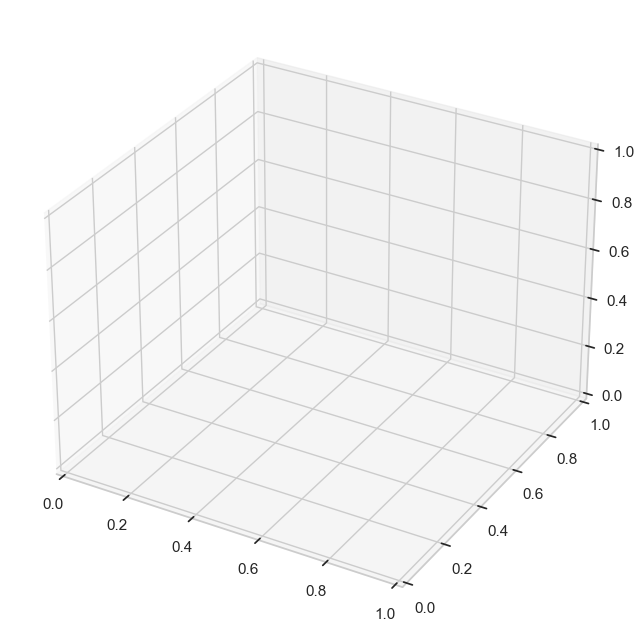

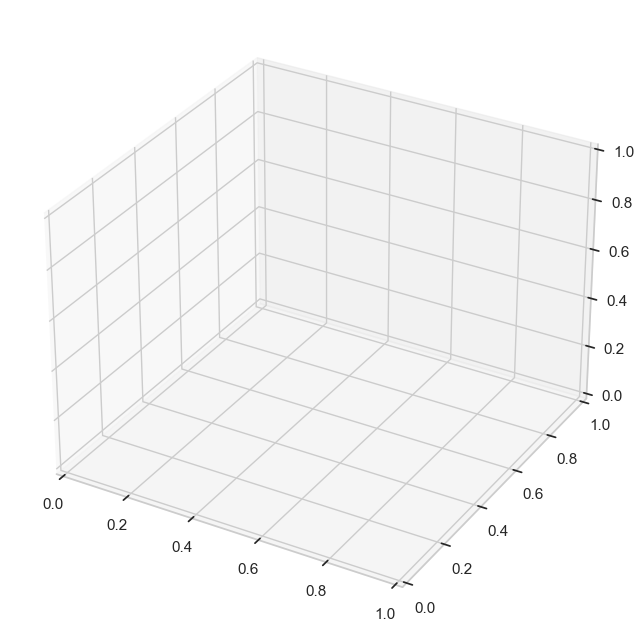

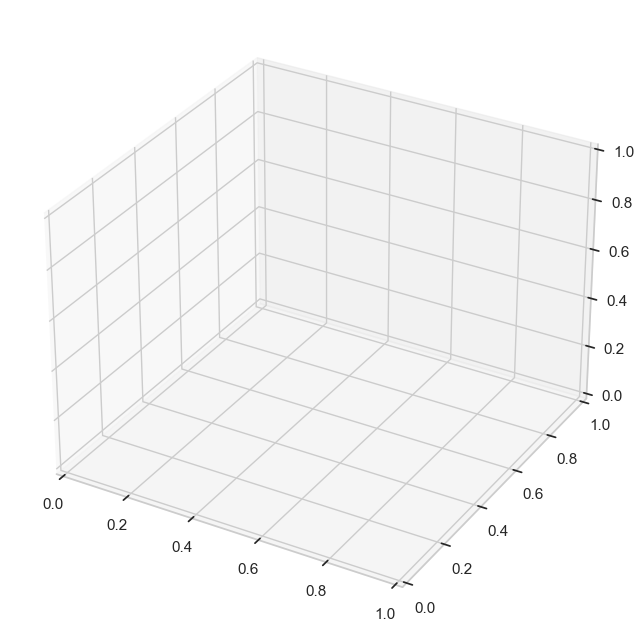

In [179]:

# getting the most recently saved file so that we can 
# use that as the model that we are analyzing
def get_most_recent_file(model_directory):
    
    # getting the files in the directory that we are considering
    files = [os.path.join(model_directory, f) for f in os.listdir(model_directory) if os.path.isfile(os.path.join(model_directory, f))]
    
    # check whether the list of files that exist in the directory is empty or not
    if not files:
        return None  

    # sort and return the first of the files sorted by how recently they were modified
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    return files[0]


# iterate through each of the clustering methods 
# for clustering_method in [k_means_centers, hierarchical_clustering, dbscan_clustering, mean_shift_clustering]:
# for clustering_method in [k_means_centers]:


# k_means_centers_variable = [t_cent.to(device) for t_cent in k_means_centers_variable]

# define the criteria and optimizer that we are going to be using to train the neural network
variance_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(augmented_model.parameters(), lr=0.001)

# get the centroids and the mahalanobis values
(all_mahalanobis, centroid_passes) = mahalanobis_forward_pass(augmented_model, pca_train_features, k_means_centers_variable)

# get the pca labels
pca_labels = [t.item() for t in all_train_labels]

# print the labels
# print(f"Label set: {set(pca_labels)}")

# show me the PCA clustering
visualize_pca(pca_train_features, pca_labels, k_means_centers_variable)


Processing data for epoch:   1%|          | 8/1188 [00:00<01:04, 18.40it/s]

Processing data for epoch: 100%|██████████| 1188/1188 [01:07<00:00, 17.62it/s]


Epoch 1, Loss: 1.5543770162946848, Val Loss: 1.5316518296296349


Processing data for epoch: 100%|██████████| 1188/1188 [01:08<00:00, 17.27it/s]


Epoch 2, Loss: 1.5122638718046324, Val Loss: 1.5251409686374344


Processing data for epoch: 100%|██████████| 1188/1188 [01:07<00:00, 17.57it/s]


Epoch 3, Loss: 1.501421648544896, Val Loss: 1.5168221618992712


Processing data for epoch: 100%|██████████| 1188/1188 [01:08<00:00, 17.33it/s]


Epoch 4, Loss: 1.4934430024539582, Val Loss: 1.5157008074750804


Processing data for epoch: 100%|██████████| 1188/1188 [01:08<00:00, 17.28it/s]


Epoch 5, Loss: 1.4899340358246056, Val Loss: 1.5095351569178932


Processing data for epoch: 100%|██████████| 1188/1188 [01:08<00:00, 17.44it/s]


Epoch 6, Loss: 1.4857254129668278, Val Loss: 1.504231880810927


Processing data for epoch: 100%|██████████| 1188/1188 [01:08<00:00, 17.24it/s]


Epoch 7, Loss: 1.481966870401042, Val Loss: 1.5030463175340132


Processing data for epoch: 100%|██████████| 1188/1188 [01:08<00:00, 17.26it/s]


Epoch 8, Loss: 1.4794602759358055, Val Loss: 1.5119006188228876


Processing data for epoch: 100%|██████████| 1188/1188 [01:09<00:00, 17.11it/s]


Epoch 9, Loss: 1.4784035958625652, Val Loss: 1.5037844197115915


Processing data for epoch: 100%|██████████| 1188/1188 [01:09<00:00, 17.16it/s]


Epoch 10, Loss: 1.4749673994301946, Val Loss: 1.502795615180173


Processing data for epoch: 100%|██████████| 1188/1188 [01:07<00:00, 17.52it/s]


Epoch 11, Loss: 1.474387926084024, Val Loss: 1.5060267159433076


Processing data for epoch: 100%|██████████| 1188/1188 [01:08<00:00, 17.36it/s]


Epoch 12, Loss: 1.4734152379862788, Val Loss: 1.5001855386226668


Processing data for epoch: 100%|██████████| 1188/1188 [01:08<00:00, 17.43it/s]


Epoch 13, Loss: 1.4699590023519213, Val Loss: 1.5038284781805995


Processing data for epoch: 100%|██████████| 1188/1188 [01:08<00:00, 17.39it/s]


Epoch 14, Loss: 1.4747467692753282, Val Loss: 1.5069335177289918


Processing data for epoch: 100%|██████████| 1188/1188 [01:08<00:00, 17.31it/s]


Stopping early due to increasing validation loss.


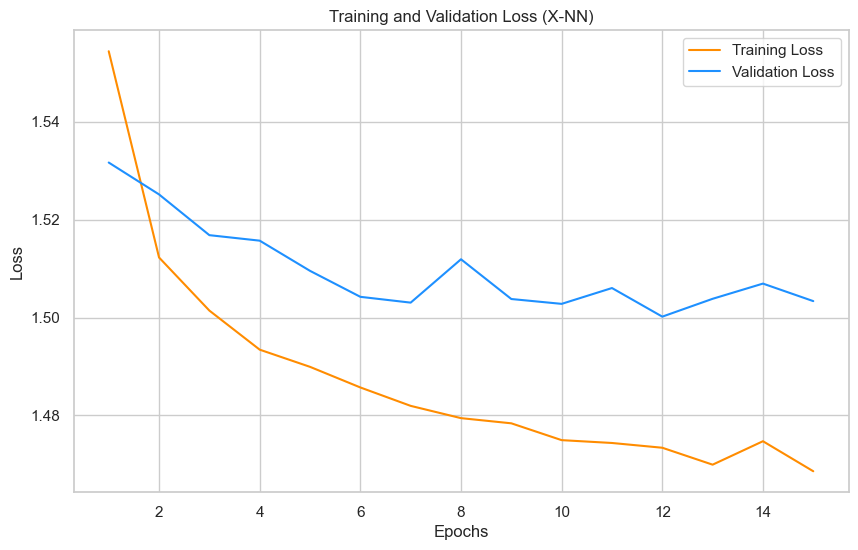

Train Accuracy: 45.33%
File will be saved as: /Users/tristanbrigham/Desktop/Classes/CPSC 471/Final Project/models_save/aug_model_save_k_means_centers_20
File will be saved as: /Users/tristanbrigham/Desktop/Classes/CPSC 471/Final Project/runthroughs/run_1/aug_model_save_k_means_centers.pth


In [180]:

# check if one or the other is not true
if TRAIN_MODEL and not SHOULD_SAVE_OUTPUT:
    raise ValueError("Incorrect truth table for arguments")


# train the model with the mahalanobis distances
if TRAIN_MODEL:
    if USE_BATCHES:
        train_model_with_variance(augmented_model, pca_train_loader, pca_val_loader, variance_criterion, optimizer, all_mahalanobis, k_means_centers_variable, centroid_passes, verbose=0, epochs=30)
    else:
        train_model_with_variance(augmented_model, pca_train_dataset, pca_val_dataset, variance_criterion, optimizer, all_mahalanobis, k_means_centers_variable, centroid_passes, verbose=0, epochs=30)

else:
    # getting the most recently saved file as the model
    rec_model = get_most_recent_file(SAVE_MODEL_PATH)

    path_for_display = rec_model.replace(' ', '\\ ')
    print(f"Loading model in from {path_for_display}")

    # load the model in from the save path
    augmented_model = torch.load(rec_model)

# get the output statistics for the model
accuracy = accuracy_score(all_train_labels, [np.argmax(t_arr) for t_arr in augmented_model(pca_train_features.to(device)).cpu().detach().numpy()])
print("Train Accuracy: {:.2f}%".format(accuracy * 100))


# saving the model if we have trained it
if TRAIN_MODEL:

    # generate a unique file name
    unique_dir = generate_unique_file_dir(SAVE_MODEL_PATH, AUG_SAVE_FILE_NAME.replace(".pth", f"_{clustering_method_name}"))
    os.makedirs(unique_dir, exist_ok=True)

    # save the file
    print("File will be saved as:", unique_dir)
    torch.save(augmented_model, os.path.join(unique_dir, AUG_SAVE_FILE_NAME))

    # save the information about the clusters and the centroids as well
    info_dict = {}

    # save the information in a dictionary
    info_dict['centroid_num'] = CLUSTER_NUM
    info_dict['centroids'] = k_means_centers_variable

    # open and dump the pickle file
    with open(os.path.join(unique_dir, INFO_DICT_NAME), 'wb') as file:
        pickle.dump(info_dict, file)


# check if we should save the model to a runthrough
if SHOULD_SAVE_OUTPUT:

    # generate a unique file name
    # unique_dir = generate_unique_file_dir(SAVE_MODEL_PATH, SAVE_FILE_NAME.replace(".pth", f"_{clustering_method.__name__}"))

    # save the file
    f_save_path = os.path.join(curr_run_dir, AUG_SAVE_FILE_NAME.replace(".pth", f"_{clustering_method_name}.pth"))
    print("File will be saved as:", f_save_path)
    torch.save(augmented_model, f_save_path)

    # save the information about the clusters and the centroids as well
    info_dict = {}

    # save the information in a dictionary
    info_dict['centroid_num'] = CLUSTER_NUM
    info_dict['centroids'] = k_means_centers_variable

    # open and dump the pickle file
    with open(os.path.join(curr_run_dir, INFO_DICT_NAME), 'wb') as file:
        pickle.dump(info_dict, file)


Showing /Users/tristanbrigham/Desktop/Classes/CPSC 471/Final Project/models/generated_images/pca_subplot_1.png


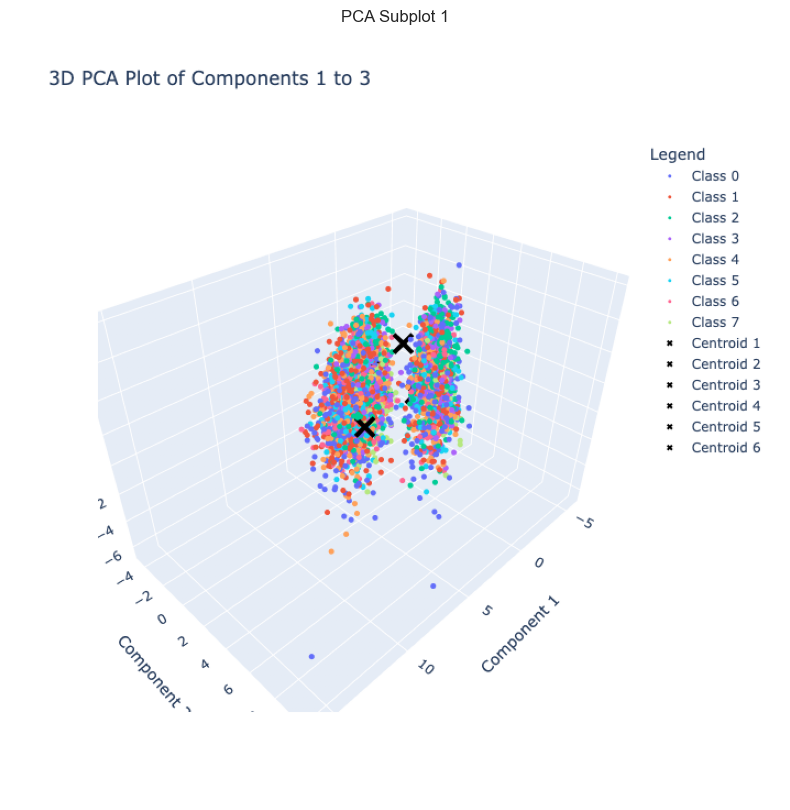

Showing /Users/tristanbrigham/Desktop/Classes/CPSC 471/Final Project/models/generated_images/pca_subplot_2.png


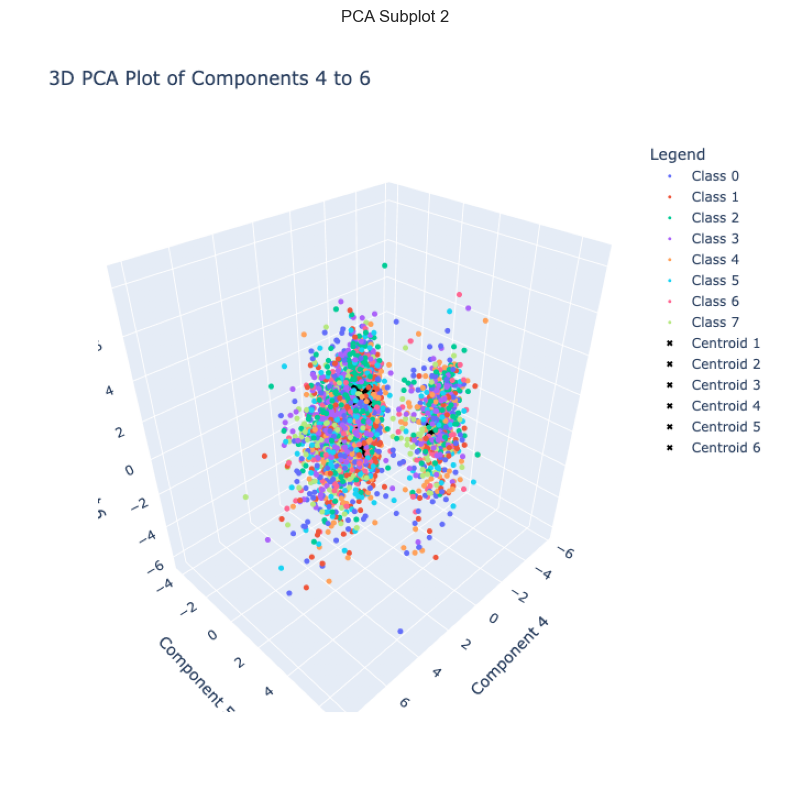

Showing /Users/tristanbrigham/Desktop/Classes/CPSC 471/Final Project/models/generated_images/pca_subplot_3.png


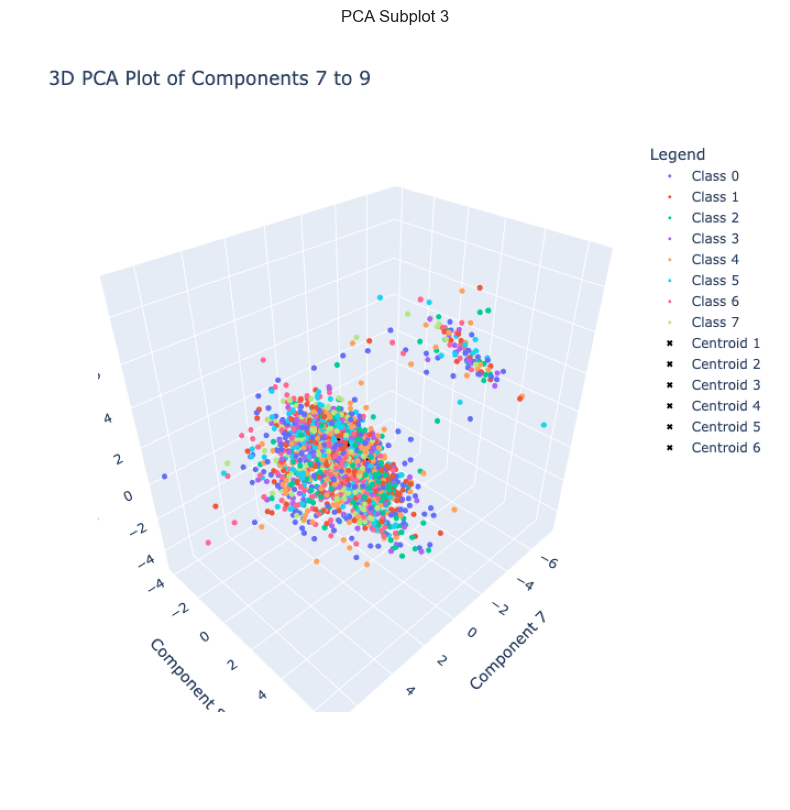

In [181]:
# showing the images for the notebook conversion
for i in range(1, 4):

	plt.figure(figsize=(10, 10))

	# get the path to the image that we should load in
	img_p = os.path.join(HOME_DIR, SUB_DIR, GENERATED_IMAGES_DIR, "generated_images", f"pca_subplot_{i}.png")

	print(f"Showing {img_p}")

	img = mpimg.imread(img_p)

	plt.axis('off')  # turn off axis
	plt.title(f"PCA Subplot {i}")

	imgplot = plt.imshow(img)

	if SHOULD_SAVE_OUTPUT:
		plt.savefig(dpi=300, fname=os.path.join(curr_run_dir, f"pca_subplot_{i}.png"))

	# show the image
	plt.show()


### Augmented Loss Function Neural Network Results

I find that the network with the augmented loss function aiming for explainability increases the loss that is associated with the neural network which is to be expected. With that being said, compared to popular benchmarks for explainability built into the neural network, the neural network above seems to have much better loss. We see average values for each of the statistics we are most interested in below:

| Metric            |   Value    |
|:------------------|:----------:|
| Train Accuracy    |   38.97%   |

As we can see, this is much better than the XGBoost model and slightly below the normal neural network model which was right around 50% (though it is not much behind the normal neural network's accuracy).

# Activation Analysis
Analysis of the explainability power of each of the nodes in the neural network is below. We are looking for co-dependencies between the input data and the activations of the neurons to try to see if the neurons are actually encoding data as a result of the training process. That is, we are looking for neurons that alone encode specific results as an extension of the CAV idea. Methods that we try to visualize and understand the interdependencies of the data along with their explanations are:
 
- Layer-Wise Relevance Propagation
	- This helps us understand how to weight the relative activation relationships that we find. If there is some activation that has a dramatically higher influence on the final output of the model than another, then it makes sense that we should investigate that neuron more closely than the other neurons with less explicit relationships. 
- Feature Activation Regressions
	- This helps us further understand the relationship between the inputs and the activations of neurons. Plotting the coefficients of the regression helps us to understand which combinations of inputs lead to the best explanation of the output of the activation of the neurons that we consider.  We analyze this below.

We also want to make sure that we have not forced the neural network into the lazy neural network regime where the neural network is simply approximating a kernel function or NTK. 

Some other methods that I could try with more time include:
- Neuron Activation Clustering
	- This is going to investigate the activations of the neurons to try to see if there is any relationship between the activations of the neurons in the model that we can attach to the labels that have been given to the input data points by the clustering method. 
	- Part of this method is going to be done with a regression attempting to quantify the relationship between the target layer for the neural network, and part of this method is going to be done with traditional clustering methods that are known. 
- Partial Dependence Plots
	- Shows the effect that some subset of the input features has on the output of the neuron activations. It helps us to understand the relative weighted relationship of the distance to the centroids of the clusters that we computed to the actual neuron activations that we are targeting.

In [182]:
# empty list for features
# features_list = []

# keep track of the max distance
max_mahalanobis = 0

# clear all of the intermediates in the model
global network_layer_outputs
clear_total_run()
# print(f"CURRENT MODEL STORAGE: {network_layer_outputs}")

# move the model
augmented_model = augmented_model.to(device)

# getting all of the training data for correlation analysis
for features, _ in pca_train_loader:

    # move the features to the device
    # features = features.to(device)

    # add it to the features list
    # features_list.append(features)

    # pipe it through the model
    outputs = augmented_model(features.to(device))
    
    # save the current passthrough to the list
    save_and_clear_current_pass_through()

# now get all of the outputs
aug_model_intermediates = network_layer_outputs
# print(f"AFTER MODEL STORAGE: {aug_model_intermediates}")
clear_total_run()

# concatenate all of the inputs that we are going to be using together
# all_features = torch.cat(features_list, dim=0)

# move the covariance matrix to the right device

# # moving the distance covariance matrix to the right device
# mahalanobis_covariance_matrix = mahalanobis_covariance_matrix.to('cpu')

# # array of all of the m distances that we are going to use
# all_mahalanobis = []

# # use tqdm to wrap the outer loop for a progress bar
# for t_feature in tqdm(all_features, desc="Computing Mahalanobis distances"):

#     # temp arr for mahalanobis distances corresponding to the distance from each of the K points from the clustering above
#     t_m_arr = []

#     # append all of the mahalanobis values
#     for t_m_dist in k_means_centers_variable:

#         # get the mahalanobis distance
#         m_dist = compute_mahalanobis(t_m_dist, t_feature, mahalanobis_covariance_matrix)

#         # check whether this is a new max distance or not
#         max_mahalanobis = max(abs(max_mahalanobis), m_dist)

#         t_m_arr.append(m_dist)

#     # store the distances
#     all_mahalanobis.append(t_m_arr) 

In [183]:
# do a forward pass on the model for each of the centroids
for t_center in k_means_centers_variable:
    _ = augmented_model(t_center.to(device))
    save_and_clear_current_pass_through()

# store the outputs of the centroid
centroid_passes = network_layer_outputs

# now perform the correlation analysis

In [184]:
# visualize the neural network that we made above
from torchviz import make_dot

# get the next input and label
inputs, labels = next(iter(pca_train_loader))

# get a passthrough of the augmented_model
y = augmented_model(inputs.to(device))

# make a diagram of the augmented_model
dot = make_dot(y.mean(), params=dict(augmented_model.named_parameters()))

if SHOULD_SAVE_OUTPUT:
	dot.format = 'png'
	dot.render(os.path.join(curr_run_dir, "nn_aug_structure.png"))

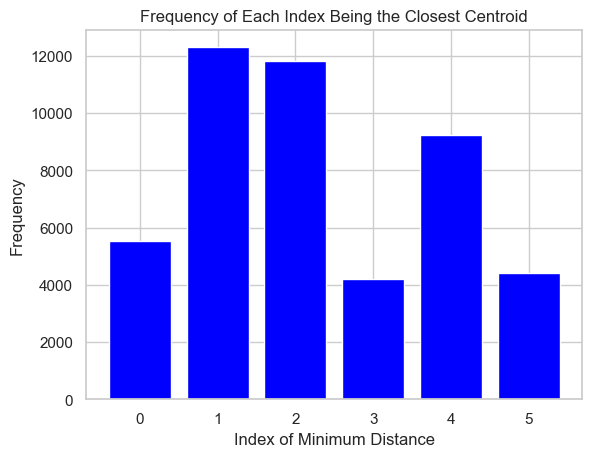

In [185]:
# plot a histogram of when each of the values are closest to one of the centroids

# find the index of the minimum value in each sub-array
min_indices = np.argmin(all_mahalanobis, axis=1)

# count the frequency of each index
index_counts = np.bincount(min_indices, minlength=5)

# plot the histogram
plt.bar(range(len(all_mahalanobis[0])), index_counts, color='blue')
plt.xlabel('Index of Minimum Distance')
plt.ylabel('Frequency')
plt.title('Frequency of Each Index Being the Closest Centroid')
plt.xticks(range(len(all_mahalanobis[0])))

if SHOULD_SAVE_OUTPUT:
	plt.savefig(dpi=300, fname=os.path.join(curr_run_dir, "min_dist_hist.png"))

plt.show()

In [186]:
# start correlation analysis with just a plain node correlation
from sklearn.linear_model import LinearRegression

# layer that we are considering
LAYER_IDX = 2

# the coefficients for the regressions that I am running
coefficients = [] 
lower_bounds = []
upper_bounds = []
max_abs_coefficients = []

# go through each of the intermediate variables in the model and collect them
for i in tqdm(range(len(aug_model_intermediates[0][LAYER_IDX][0])), desc="Creating regression between variables..."):

    # now we are going to get the ith element of the array
    current_node = []

    # adding all of the model intermediate values in 
    for j in range(len(aug_model_intermediates)):
        for t_element in aug_model_intermediates[j][LAYER_IDX][:, i]:
            current_node.append(t_element)

    # perform a regression between this element and the centroid distances

    # initialize a Linear Regression model
    linrg_model = LinearRegression()

    # convert the arrays to np arrays
    all_mahalanobis = np.array(all_mahalanobis)
    current_node = np.array(current_node)

    # print an update
    # print(f"Performing regression {i} between all_mahalanobis and current_node...")
    # print(f"Current Dimensions:\nall_mahalanobis shape{all_mahalanobis.shape}\ncurrent_node shape{current_node.shape}")

    # fit the regression
    linrg_model.fit(all_mahalanobis, current_node)

    # getting the maximum coefficient in the model
    max_abs_coef_index = np.argmax(np.abs(linrg_model.coef_))
    max_abs_model_coefficient = np.abs(linrg_model.coef_[max_abs_coef_index])
    max_abs_coefficients.append(max_abs_model_coefficient)

    # get the residuals and the standard error
    bound_preds = linrg_model.predict(all_mahalanobis)
    resid_vals = np.sum((current_node - bound_preds)**2)
    model_standard_error = np.sqrt(resid_vals / (len(current_node) - 2)) /  np.sqrt(np.sum((all_mahalanobis - np.mean(all_mahalanobis))**2))

    # now compute the 95% confidence bound for the model
    df = len(current_node) - 2
    t_critical = stats.t.ppf(1-0.025, df)

    # append the upper and lower bounds to the arrays that we are using to keep track
    ci_lower = max_abs_model_coefficient - t_critical * model_standard_error
    ci_upper = max_abs_model_coefficient + t_critical * model_standard_error

    lower_bounds.append(ci_lower)
    upper_bounds.append(ci_upper)

        
    # store the coefficient
    coefficients.append(linrg_model.coef_)

Creating regression between variables...: 100%|██████████| 32/32 [00:14<00:00,  2.27it/s]


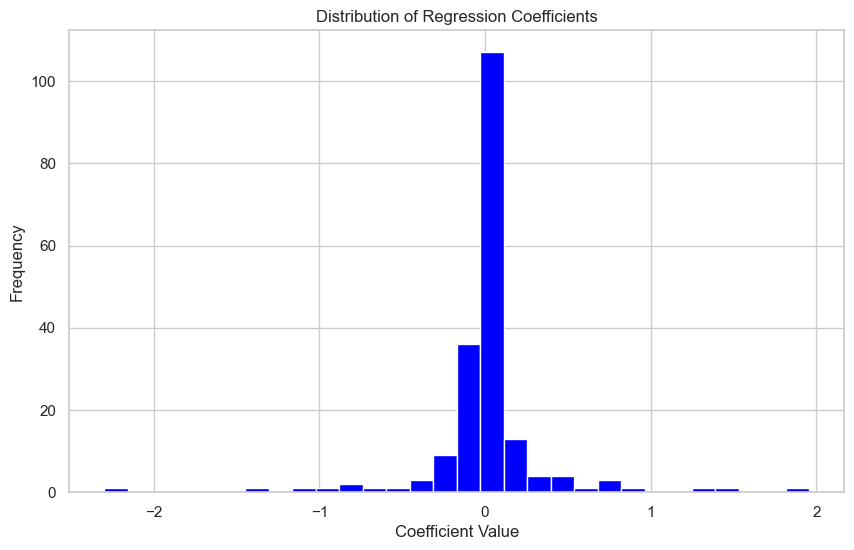

In [187]:
# plot the regression coefficients so that we can see what they are doing in the model
coefficients = np.array(coefficients)  

# flatten the array to get a single visualization
flat_coefficients = coefficients.flatten()

sns.set_theme(style="whitegrid")
sns.set_palette("magma")

# plot the information that we got
plt.figure(figsize=(10, 6))
plt.hist(flat_coefficients, bins=30, color='blue')
plt.title('Distribution of Regression Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Frequency')

if SHOULD_SAVE_OUTPUT:
	os.makedirs(os.path.join(curr_run_dir, "aug_coeff_hist_plots"), exist_ok=True)
	plt.savefig(dpi=300, fname=os.path.join(curr_run_dir, "aug_coeff_hist_plots", "reg_coeff_dist_hist.png"))

plt.show()


Coefficients Shape: (32, 6)


Plotting regression coefficients:  62%|██████▎   | 20/32 [00:05<00:03,  3.48it/s]/var/folders/d2/lsvbp7p92gnc5ql59sc72rx40000gn/T/ipykernel_85285/372043092.py:17: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.

Plotting regression coefficients: 100%|██████████| 32/32 [00:08<00:00,  3.61it/s]


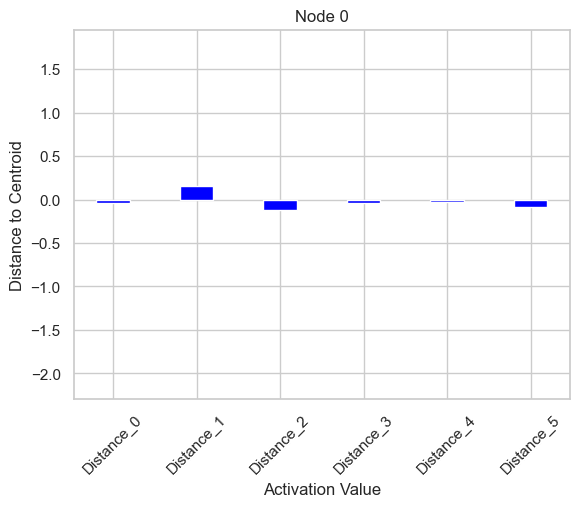

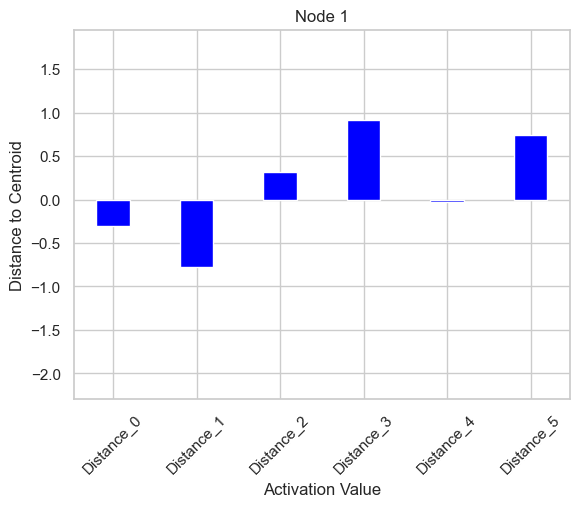

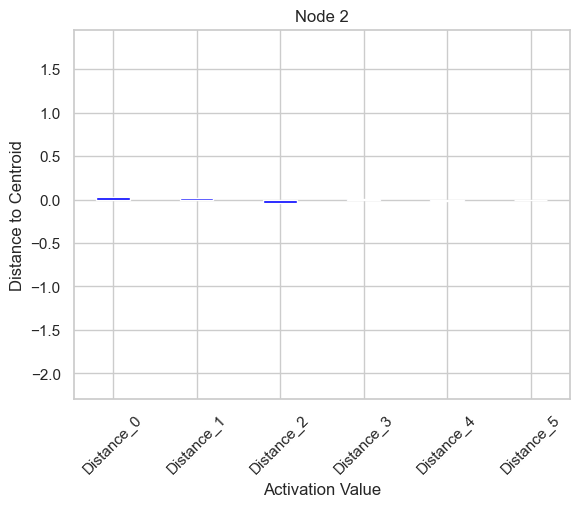

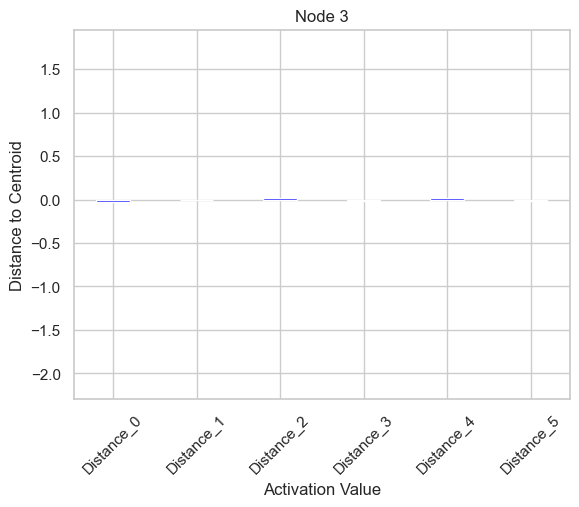

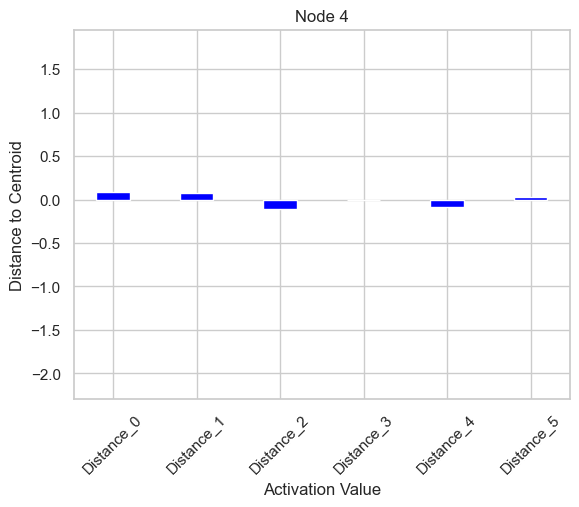

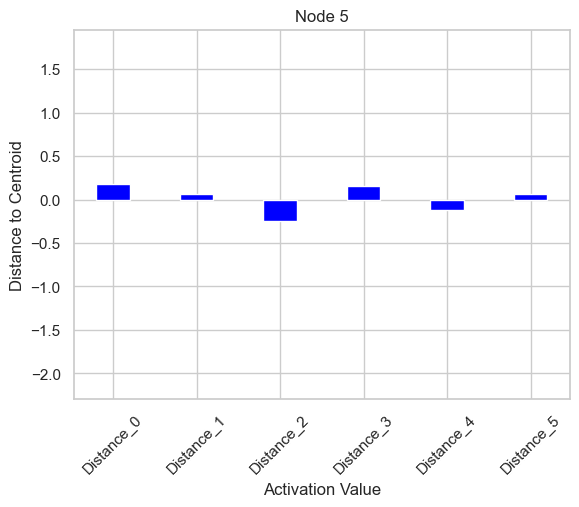

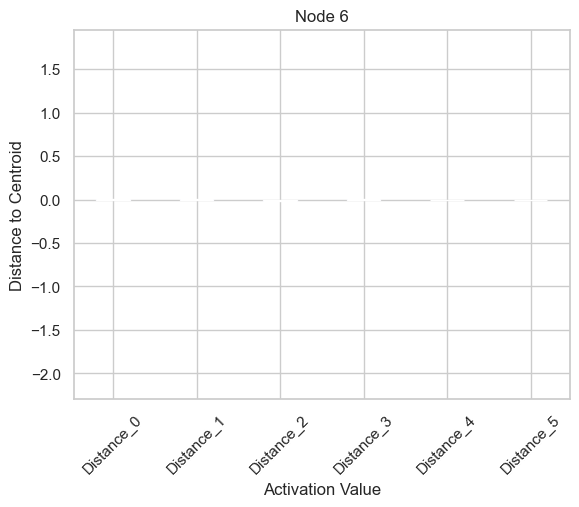

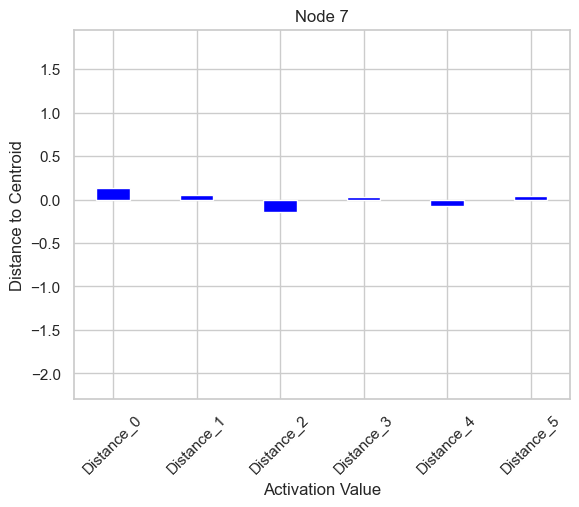

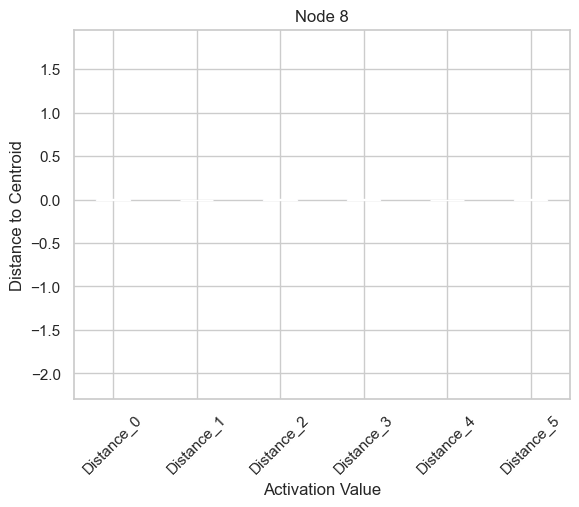

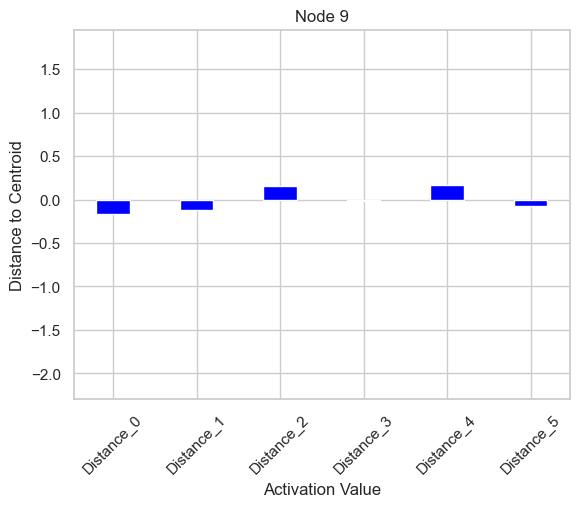

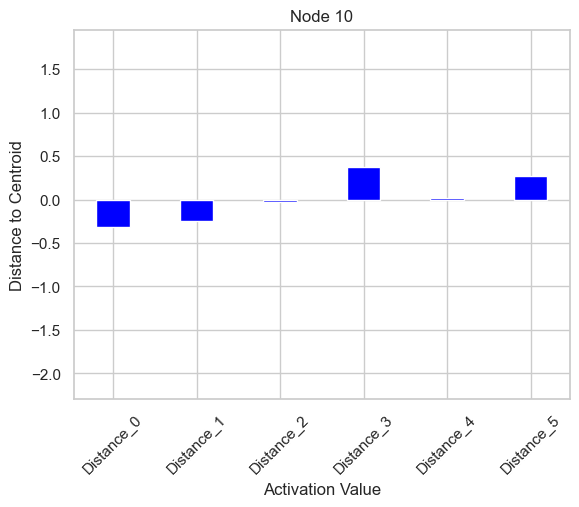

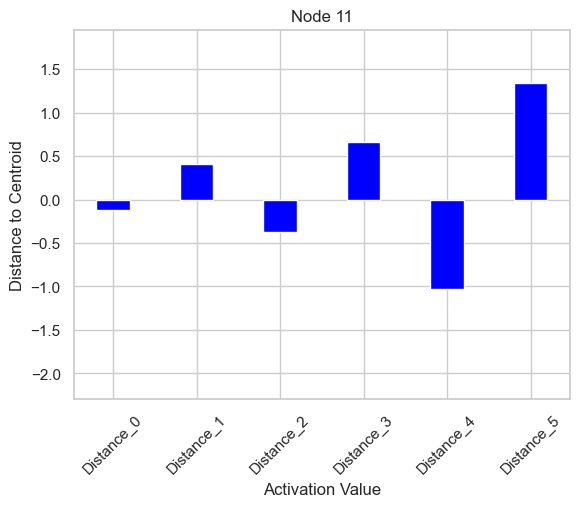

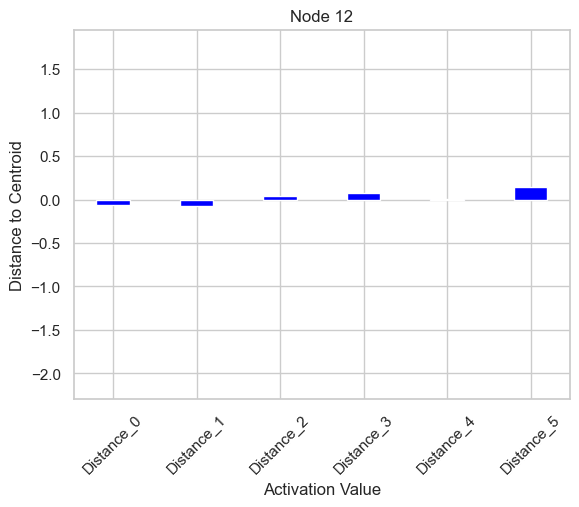

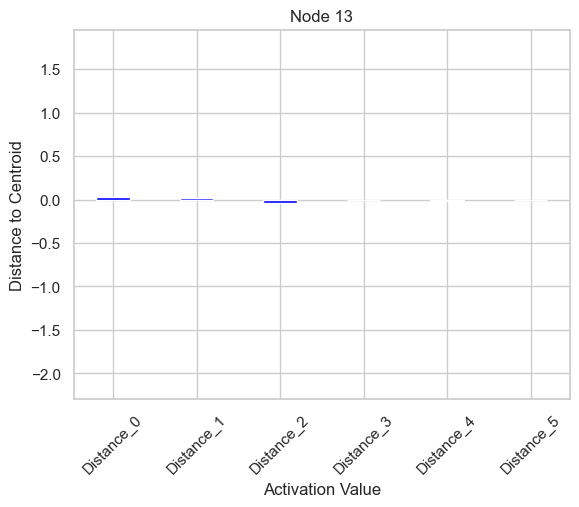

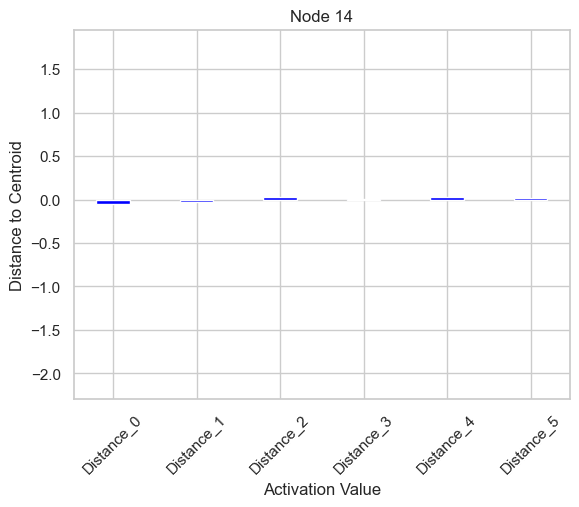

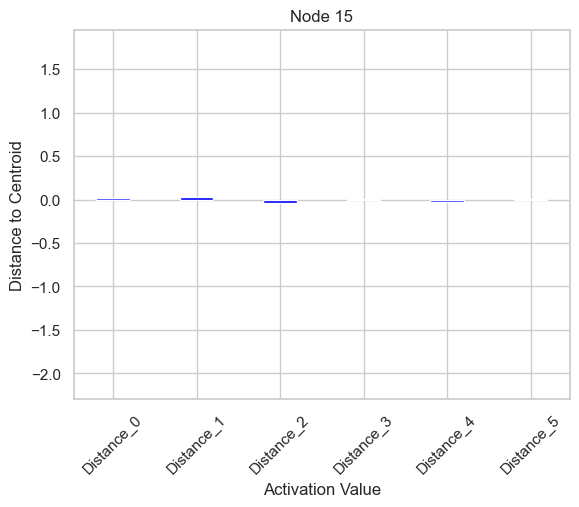

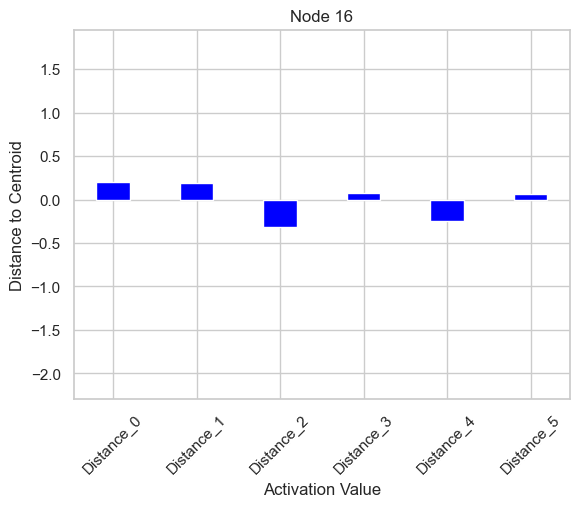

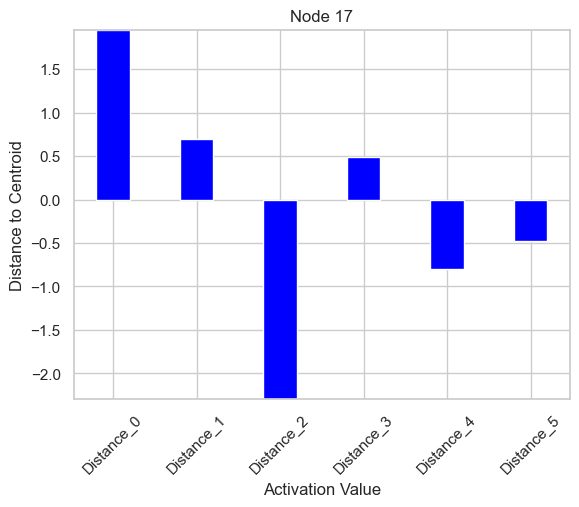

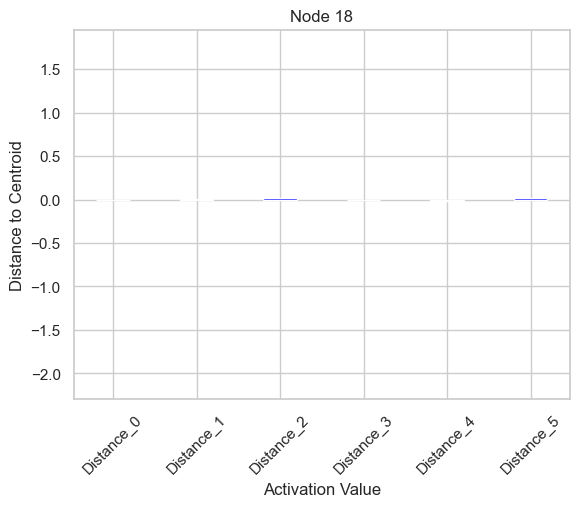

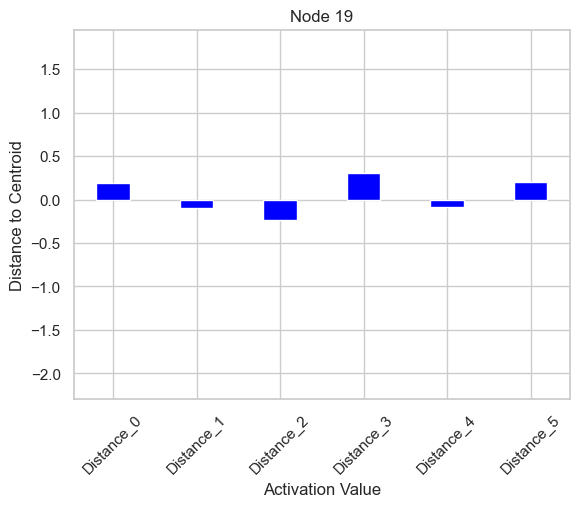

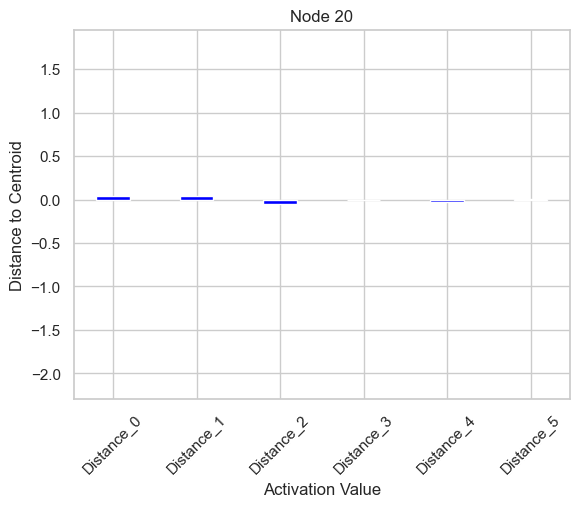

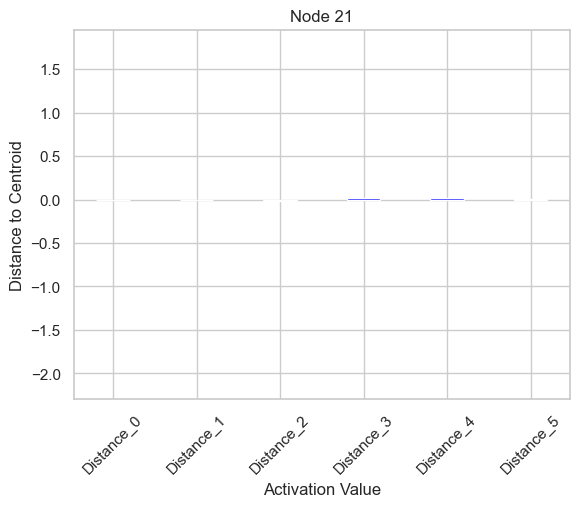

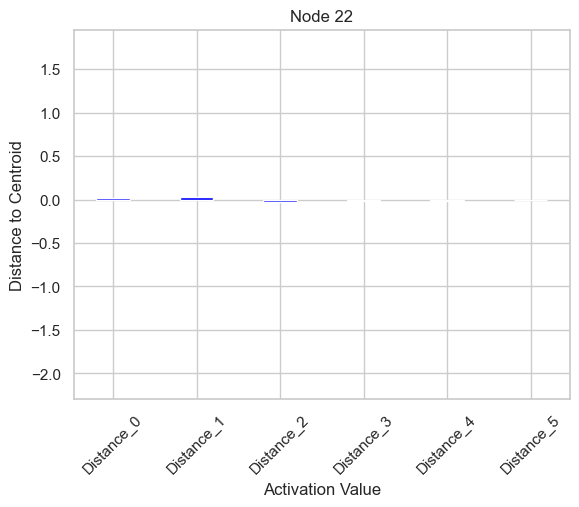

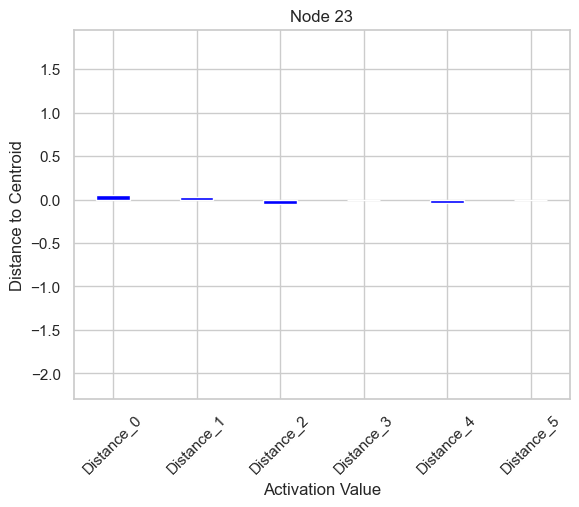

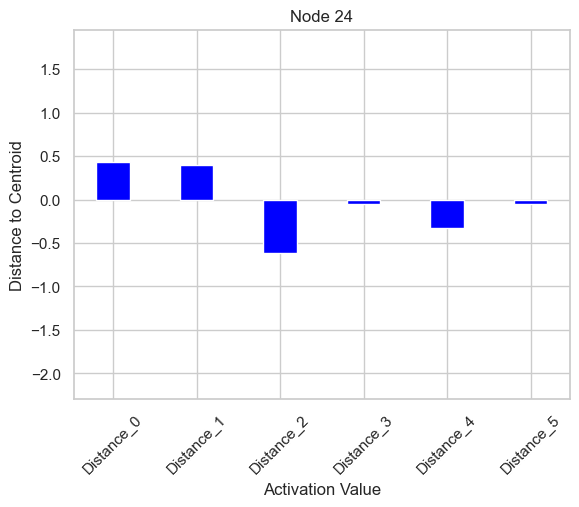

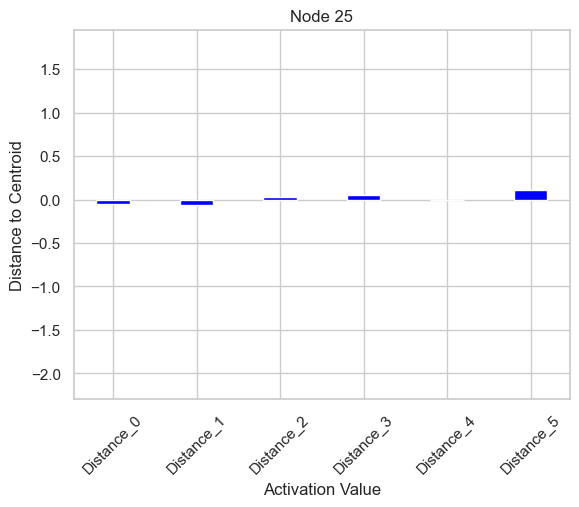

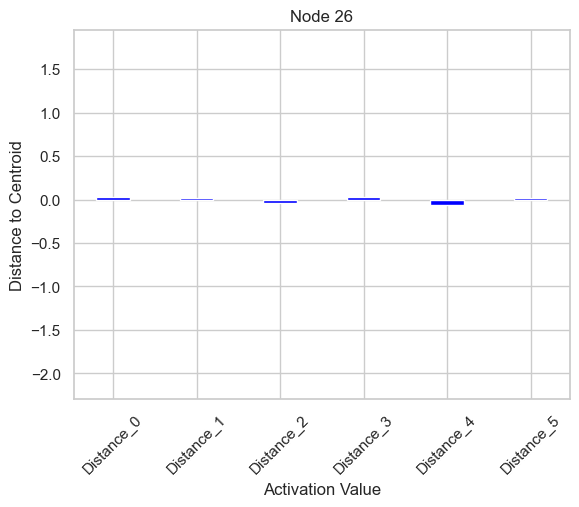

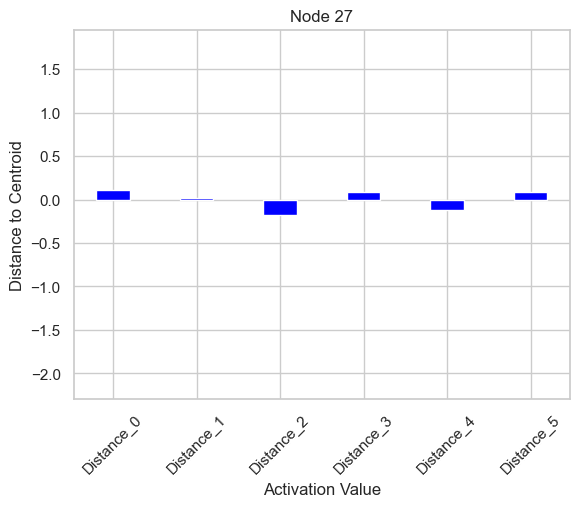

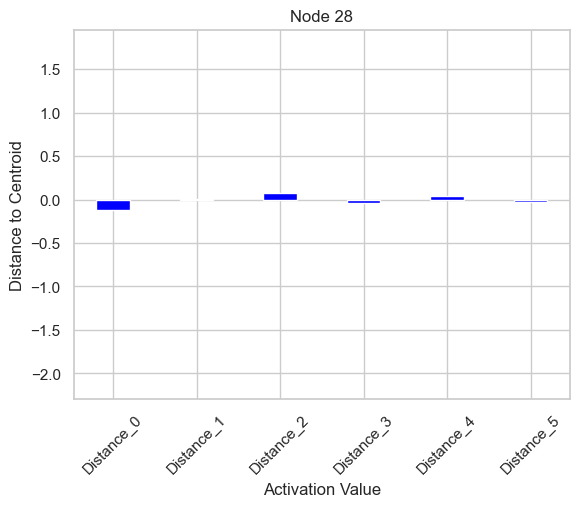

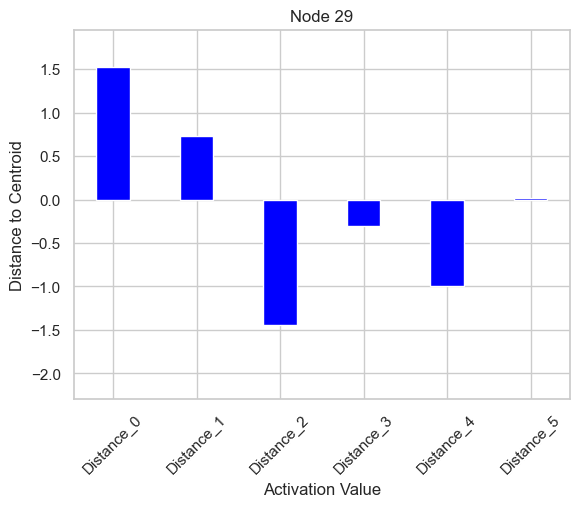

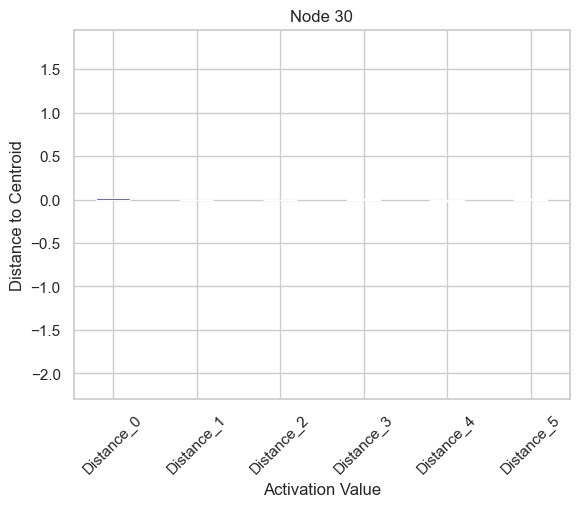

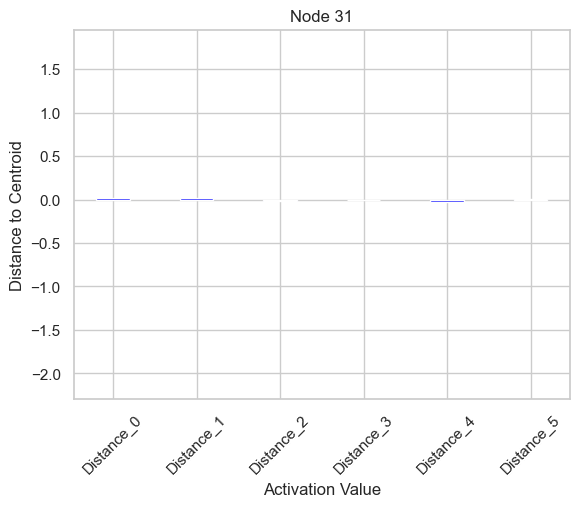

In [188]:
# now go through and make subplots for everything that we are doing
print(f"Coefficients Shape: {coefficients.shape}")

# get the number of coefficients for creating subplots
n_coeffs = coefficients.shape[1]

# labels of the coefficients
coeff_labels = [f"Distance_{x}" for x in range(coefficients.shape[1])]

# getting the minimum and the maximum value of the regressions
ymin = np.min(coefficients)
ymax = np.max(coefficients)

# iterate through each of the possible coefficients that we are going to consider
for coeffs_idx in tqdm(range(coefficients.shape[0]), desc="Plotting regression coefficients"):
    
    plt.figure()

    # get the coefficients for that node in the matrix
    # plot on some subplot
    plt.bar(coeff_labels, coefficients[coeffs_idx], color ='blue', width = 0.4)
    
    # get the labeling information for the graph
    plt.title(f'Node {coeffs_idx}')
    plt.xlabel('Activation Value')
    plt.ylabel('Distance to Centroid')
    plt.xticks(rotation=45)

    # scale the y axis
    plt.ylim(ymin, ymax)

    if SHOULD_SAVE_OUTPUT:
        os.makedirs(os.path.join(curr_run_dir, "aug_coeff_hist_plots"), exist_ok=True)
        plt.savefig(dpi=300, fname=os.path.join(curr_run_dir, "aug_coeff_hist_plots", f"plt_coeff_{coeffs_idx}_node.png"))

    

# show the figure that we constructed
plt.show()



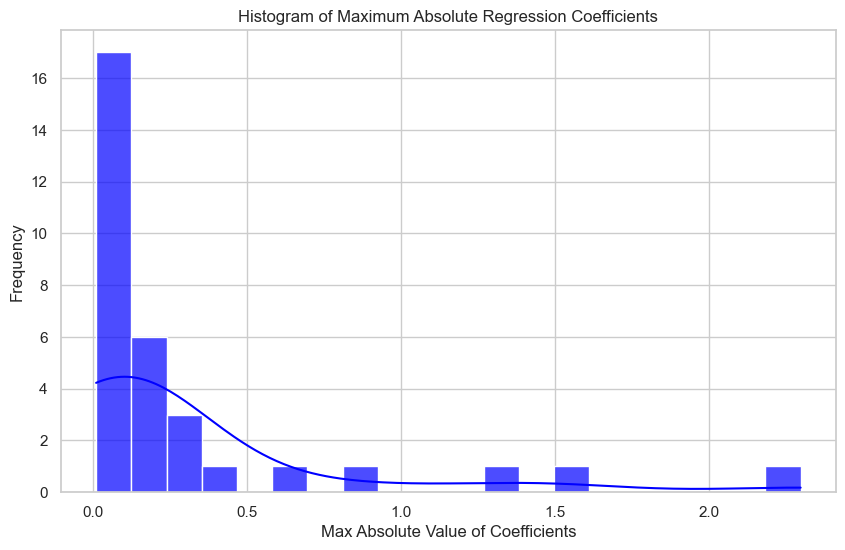

<Figure size 640x480 with 0 Axes>

In [189]:
# now we are going to create the histogram 
# that shows the maximum values of the absolute regression coefficients

# getting the max value for each of the regs
aug_max_abs_values = np.array(max_abs_coefficients)
aug_sorted_indices = np.argsort(-aug_max_abs_values)

# sort the elements on the argument order
aug_sorted_max_abs_values = aug_max_abs_values[aug_sorted_indices]
aug_sorted_lower_bounds = np.array([lower_bounds[i] for i in aug_sorted_indices])
aug_sorted_upper_bounds = np.array([upper_bounds[i] for i in aug_sorted_indices])

# plot the histrogram
plt.figure(figsize=(10, 6))
sns.histplot(aug_max_abs_values, bins=20, kde=True, color='blue', alpha=0.7)
plt.title('Histogram of Maximum Absolute Regression Coefficients')
plt.xlabel('Max Absolute Value of Coefficients')
plt.ylabel('Frequency')  
plt.show()


if SHOULD_SAVE_OUTPUT:
	plt.savefig(dpi=300, fname=os.path.join(curr_run_dir, "aug_coeff_hist_plots", "aug_abs_coeff.png"))

In [190]:
# getting the difference in standard error bar sizes
delta = aug_sorted_upper_bounds - aug_sorted_lower_bounds

print(f"Mean error bar size: {delta.mean()}")

Mean error bar size: 0.12014507573099134


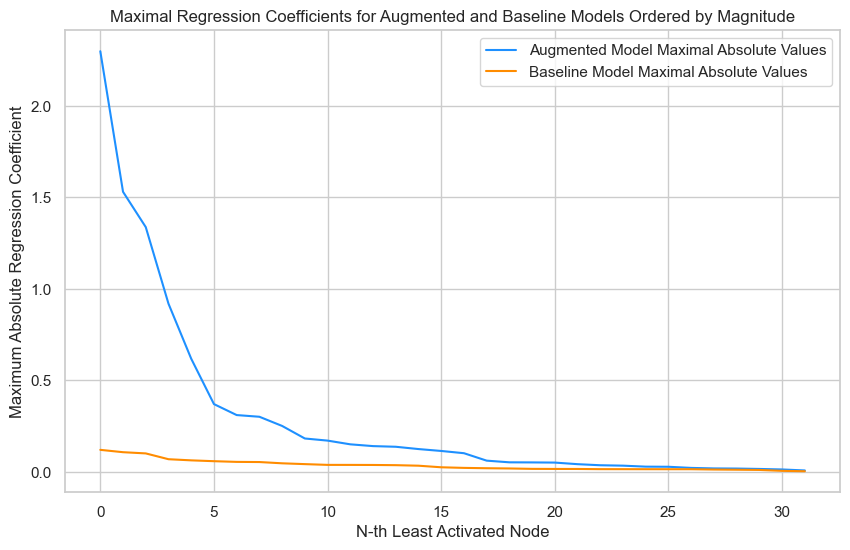

In [191]:
# now get a plot that shows the difference in the max absolute value ofthe coefficients inthe models

plt.figure(figsize=(10, 6))

# Plot both histograms
plt.plot(aug_sorted_max_abs_values, label='Augmented Model Maximal Absolute Values', color=PLOT_COLOR_2)
plt.plot(baseline_sorted_max_abs_values, label='Baseline Model Maximal Absolute Values', color=PLOT_COLOR_1)

plt.xlabel('N-th Least Activated Node')
plt.ylabel('Maximum Absolute Regression Coefficient')
plt.title('Maximal Regression Coefficients for Augmented and Baseline Models Ordered by Magnitude')
plt.legend()


if SHOULD_SAVE_OUTPUT:
	plt.savefig(os.path.join(curr_run_dir, "aug_vs_baseline_regression_coeffs.png"), dpi=300)

plt.show()


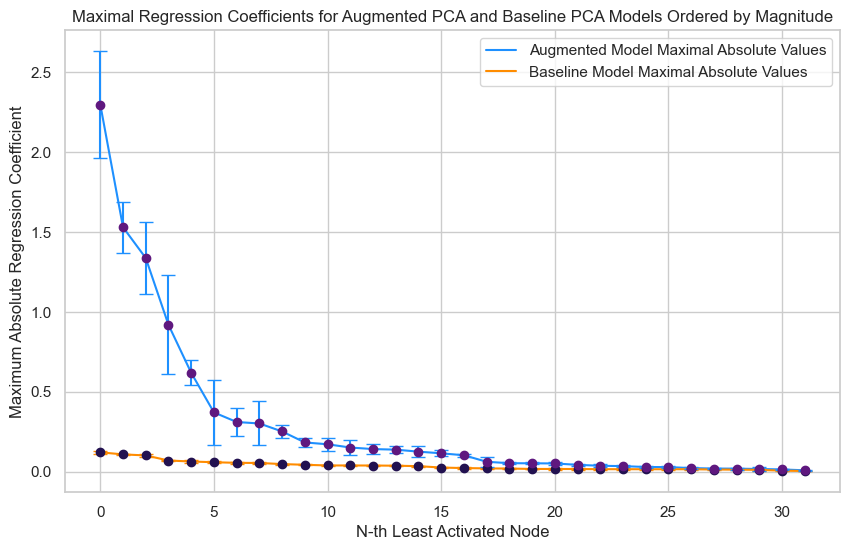

In [223]:
# now get a plot that shows the difference in the max absolute value ofthe coefficients inthe models

plt.figure(figsize=(10, 6))

# Plot both histograms
plt.plot(aug_sorted_max_abs_values, label='Augmented Model Maximal Absolute Values', color=PLOT_COLOR_2)
plt.plot(baseline_sorted_max_abs_values, label='Baseline Model Maximal Absolute Values', color=PLOT_COLOR_1)

plt.xlabel('N-th Least Activated Node')
plt.ylabel('Maximum Absolute Regression Coefficient')
plt.title('Maximal Regression Coefficients for Augmented PCA and Baseline PCA Models Ordered by Magnitude')
plt.legend()

plt.errorbar(x=np.arange(len(baseline_sorted_max_abs_values)), 
             y=baseline_sorted_max_abs_values, 
             yerr=[baseline_sorted_max_abs_values - baseline_sorted_lower_bounds, 
                   baseline_sorted_upper_bounds - baseline_sorted_max_abs_values],
             fmt='o', ecolor=PLOT_COLOR_1, capsize=5, label='95% Confidence Interval')


plt.errorbar(x=np.arange(len(aug_sorted_max_abs_values)), 
             y=aug_sorted_max_abs_values, 
             yerr=[aug_sorted_max_abs_values - aug_sorted_lower_bounds, 
                   aug_sorted_upper_bounds - aug_sorted_max_abs_values],
             fmt='o', ecolor=PLOT_COLOR_2, capsize=5, label='95% Confidence Interval')


if SHOULD_SAVE_OUTPUT:
	plt.savefig(os.path.join(curr_run_dir, "error_bar_aug_vs_baseline_regression_coeffs.png"), dpi=300)

plt.show()


Registering hooks...


Processing data for epoch:   4%|▍         | 45/1188 [00:02<00:56, 20.13it/s]

Processing data for epoch: 100%|██████████| 1188/1188 [01:04<00:00, 18.46it/s]


Epoch 1, Loss: 2.082796895544136, Val Loss: 2.082439159303402


Processing data for epoch: 100%|██████████| 1188/1188 [01:04<00:00, 18.49it/s]


Epoch 2, Loss: 2.08280398929962, Val Loss: 2.0824406307554404


Processing data for epoch: 100%|██████████| 1188/1188 [01:04<00:00, 18.50it/s]


Epoch 3, Loss: 2.0828047097732725, Val Loss: 2.082440813783845


Processing data for epoch: 100%|██████████| 1188/1188 [01:03<00:00, 18.60it/s]


Epoch 4, Loss: 2.0828130020437015, Val Loss: 2.0824372078031805


Processing data for epoch: 100%|██████████| 1188/1188 [01:03<00:00, 18.66it/s]


Epoch 5, Loss: 2.0828001846368065, Val Loss: 2.082440991995712


Processing data for epoch: 100%|██████████| 1188/1188 [01:04<00:00, 18.54it/s]


Epoch 6, Loss: 2.082797342880005, Val Loss: 2.0824427572565045


Processing data for epoch: 100%|██████████| 1188/1188 [01:02<00:00, 18.93it/s]


Epoch 7, Loss: 2.0828068364750254, Val Loss: 2.0824318108735262


Processing data for epoch: 100%|██████████| 1188/1188 [01:00<00:00, 19.59it/s]


Epoch 8, Loss: 2.082804481188456, Val Loss: 2.082437256771306


Processing data for epoch: 100%|██████████| 1188/1188 [01:00<00:00, 19.78it/s]


Epoch 9, Loss: 2.082808548151845, Val Loss: 2.0824381189314205


Processing data for epoch: 100%|██████████| 1188/1188 [01:02<00:00, 18.93it/s]


Stopping early due to increasing validation loss.


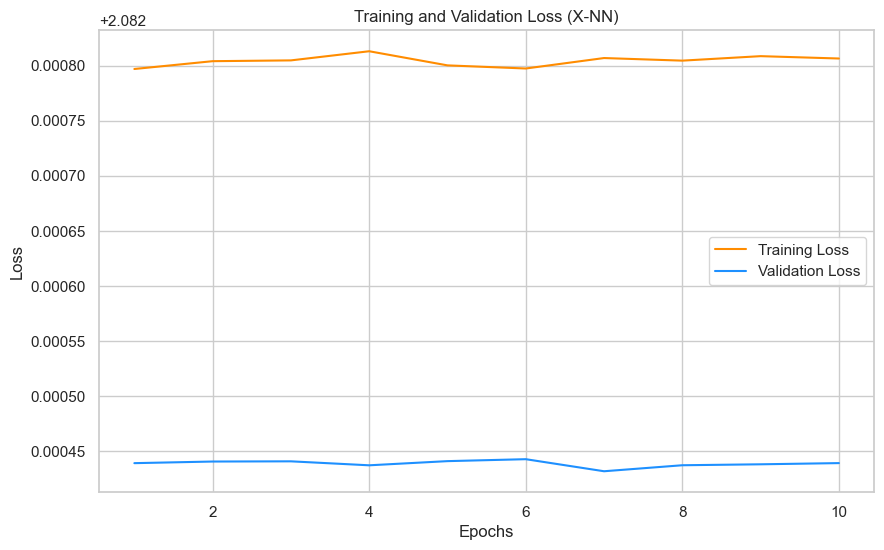

Train Accuracy: 4.41%
Training full input model
File will be saved as: /Users/tristanbrigham/Desktop/Classes/CPSC 471/Final Project/models_save/full_input_aug_model_save_k_means_centers_2
File will be saved as: /Users/tristanbrigham/Desktop/Classes/CPSC 471/Final Project/runthroughs/run_1/full_input_aug_model_save_k_means_centers.pth


In [227]:
# now try the same training with the whole 130 input features but PCA distances as the distance function

# define a neural network that we can customize the inputs and outputs for each layer for
class FullNodeImportanceNN(nn.Module):

    # initialize the insurance neural network item
    def __init__(self):
        super(FullNodeImportanceNN, self).__init__()
        
        # define the layers that we are going to use for the neural network
        self.fc1 = nn.Linear(all_train_features.shape[1], 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, NUM_CLASSES)  

    # go forward through the neural network
    def forward(self, x):

        global current_pass_through
        
        # append the initial input to the pass-through array
        current_pass_through.append(x.cpu().detach())

        # define a dictionary that we are going to be using to keep track of the losses
        # output_dict = {}
        # curr_idx = 0

        x = F.relu(self.fc1(x))
        # output_dict[str(curr_idx)] = x
        # curr_idx += 1

        x = F.relu(self.fc2(x))
        # output_dict[str(curr_idx)] = x
        # curr_idx += 1

        x = self.fc3(x)
        # output_dict[str(curr_idx)] = x
        # curr_idx += 1

        # return the overall loss dictionary with the output
        return x

    # this function returns the probabilities for different classes from the neural network model
    def predict_proba(self, x, device='cpu'):
        
        # set the network to evaluation mode
        self.eval()  
        
        with torch.no_grad():
        
            # pass through the model
            x = x.to(device)
            outputs = self(x)

            # get the probabilities
            out_probs = F.softmax(outputs, dim=1)

            return out_probs

    # defining a fit function to appease the marginal probability regression function
    def fit(self, train_loader, epochs, optimizer, criterion, device='cpu'):
        
        # move everything to devices
        self.to(device)
        self.train()

        # iterate through some amount of epochs to train the model
        for epoch in range(epochs):

            for inputs, labels in train_loader:
            
                # move everything to the right devices
                inputs = inputs.to(device) 
                labels = labels.to(device)

                # reset the optimizer that we are using
                optimizer.zero_grad()
                outputs = self(inputs)

                # calc the loss
                loss = criterion(outputs, labels)
                
                # backprop the loss
                loss.backward()
                optimizer.step()
            
            # print epoch information
            print(f'epoch: {epoch+1}/{epochs} | loss: {loss.item():.4f}')




# initialize the model
total_input_model = FullNodeImportanceNN()

start_new_pass_through()
clear_total_run()

# actually register the hooks on the model
register_hooks(total_input_model)

# save the old cov matrix
# total_mahalanobis_covariance_matrix = mahalanobis_distance_matrix(pca_train_features)
# total_mahalanobis_covariance_matrix = total_mahalanobis_covariance_matrix.to('cpu')


# check if one or the other is not true
if TRAIN_MODEL and not SHOULD_SAVE_OUTPUT:
	raise ValueError("Incorrect truth table for arguments")



# train the model with the mahalanobis distances
if TRAIN_MODEL:
    
    if USE_BATCHES:
        train_model_with_variance(total_input_model, pca_full_train_loader, pca_full_val_loader, variance_criterion, optimizer, all_mahalanobis, k_means_centers_variable, centroid_passes, verbose=0, epochs=30, training_pca_and_full=True, sum_epsilon=0.1)
    else:
        train_model_with_variance(total_input_model, pca_full_train_dataset, pca_full_val_dataset, variance_criterion, optimizer, all_mahalanobis, k_means_centers_variable, centroid_passes, verbose=0, epochs=30, training_pca_and_full=True, sum_epsilon=0.1)

else:

	raise ValueError("Not able to load in untrained model")


# get the output statistics for the model
accuracy = accuracy_score(all_train_labels, [np.argmax(t_arr) for t_arr in total_input_model(all_train_features.to(device)).cpu().detach().numpy()])
print("Train Accuracy: {:.2f}%".format(accuracy * 100))


# saving the model if we have trained it
if TRAIN_MODEL:

	# give the status update that we are training the full model now
	print(f"Training full input model")

	# generate a unique file name
	unique_dir = generate_unique_file_dir(SAVE_MODEL_PATH, FULL_INPUT_AUG_SAVE_FILE_NAME.replace(".pth", f"_{clustering_method_name}"))
	os.makedirs(unique_dir, exist_ok=True)

	# save the file
	print("File will be saved as:", unique_dir)
	torch.save(total_input_model, os.path.join(unique_dir, FULL_INPUT_AUG_SAVE_FILE_NAME))

	# save the information about the clusters and the centroids as well
	info_dict = {}

	# save the information in a dictionary
	info_dict['centroid_num'] = CLUSTER_NUM
	info_dict['centroids'] = k_means_centers_variable

	# open and dump the pickle file
	with open(os.path.join(unique_dir, INFO_DICT_NAME), 'wb') as file:
		pickle.dump(info_dict, file)



# check if we should save the model to a runthrough
if SHOULD_SAVE_OUTPUT:

	# generate a unique file name
	# unique_dir = generate_unique_file_dir(SAVE_MODEL_PATH, SAVE_FILE_NAME.replace(".pth", f"_{clustering_method.__name__}"))

	# save the file
	f_save_path = os.path.join(curr_run_dir, FULL_INPUT_AUG_SAVE_FILE_NAME.replace(".pth", f"_{clustering_method_name}.pth"))
	print("File will be saved as:", f_save_path)
	torch.save(total_input_model, f_save_path)

	# save the information about the clusters and the centroids as well
	info_dict = {}

	# save the information in a dictionary
	info_dict['centroid_num'] = CLUSTER_NUM
	info_dict['centroids'] = k_means_centers_variable

	# open and dump the pickle file
	with open(os.path.join(curr_run_dir, INFO_DICT_NAME), 'wb') as file:
		pickle.dump(info_dict, file)

Creating regression between variables...: 100%|██████████| 32/32 [00:12<00:00,  2.64it/s]


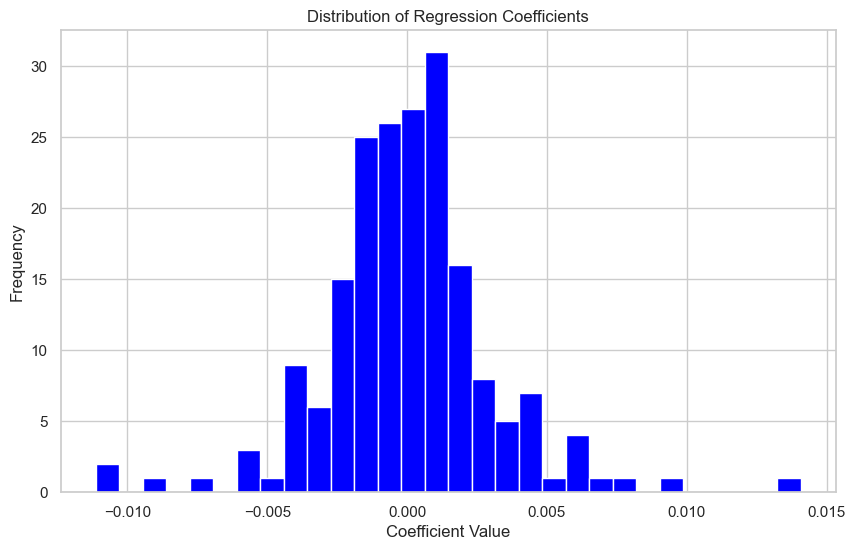

Coefficients Shape: (32, 6)


Plotting regression coefficients:  62%|██████▎   | 20/32 [00:05<00:03,  3.82it/s]/var/folders/d2/lsvbp7p92gnc5ql59sc72rx40000gn/T/ipykernel_85285/3751263056.py:149: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.

Plotting regression coefficients: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


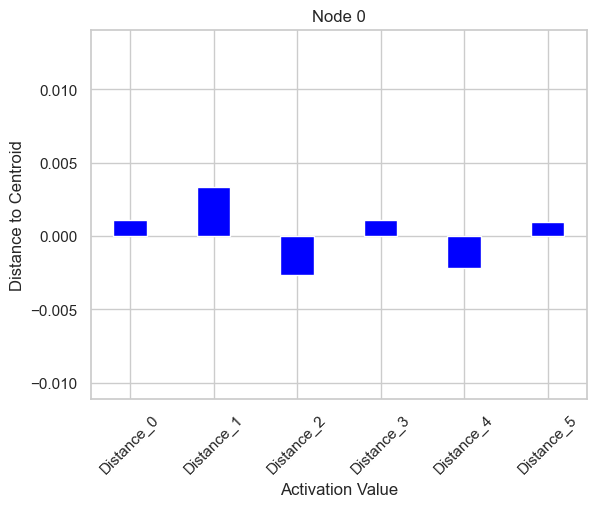

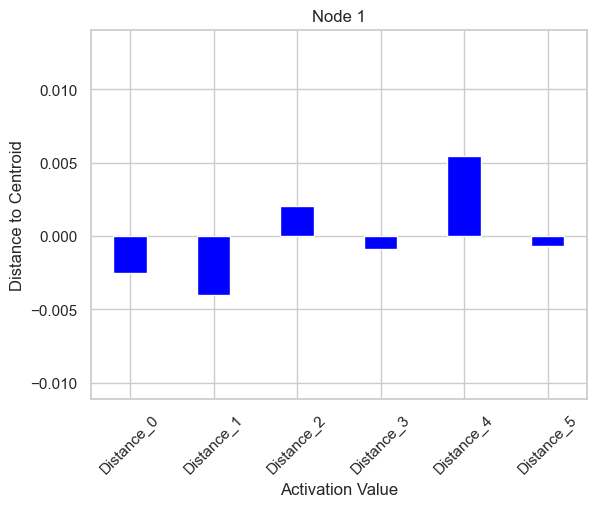

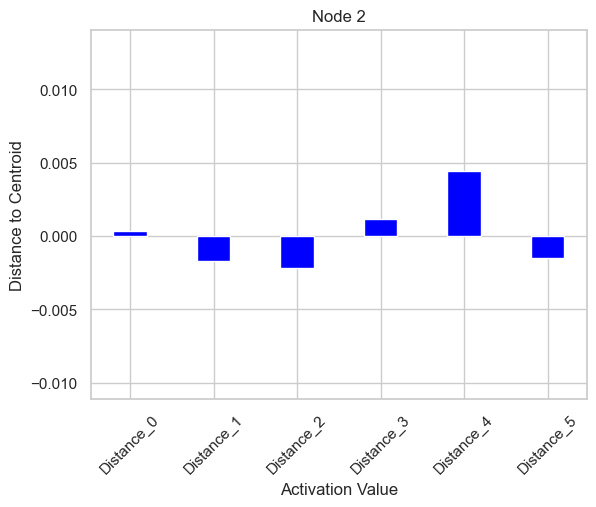

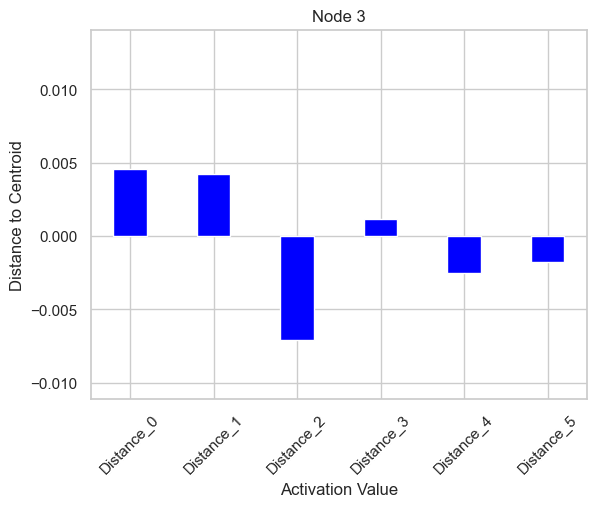

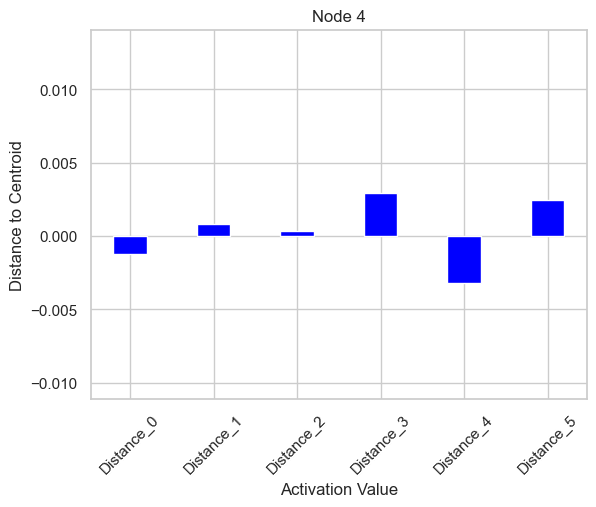

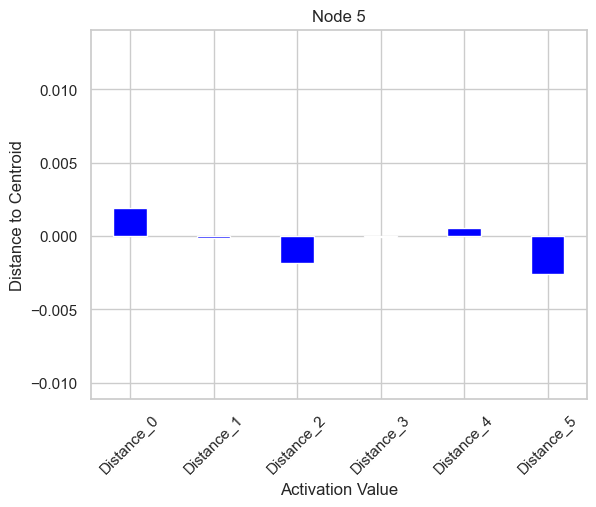

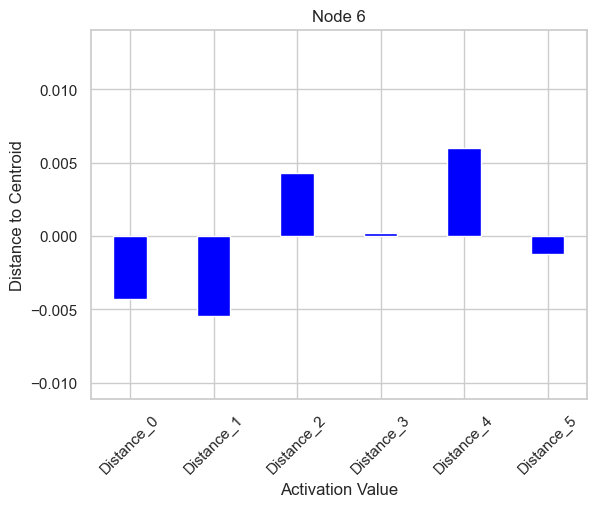

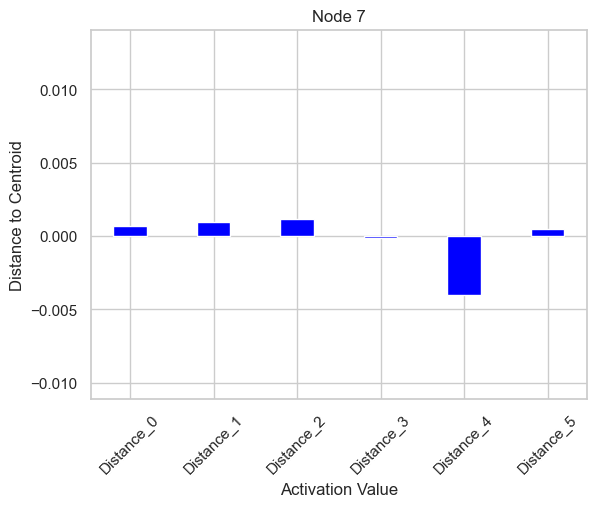

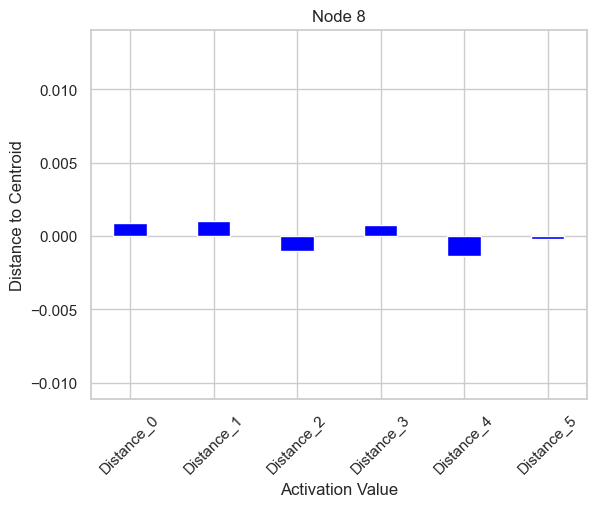

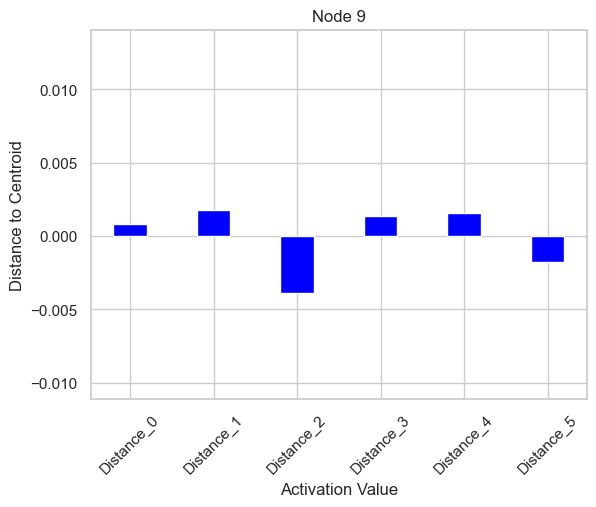

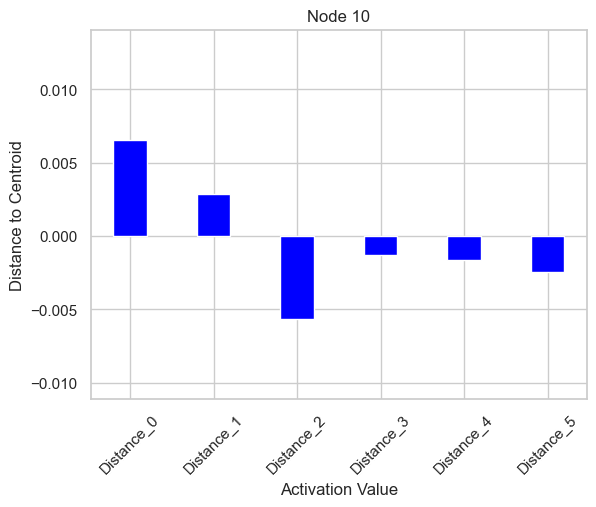

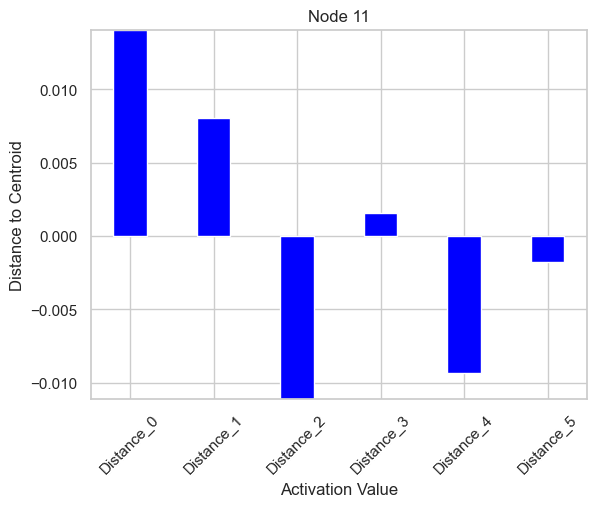

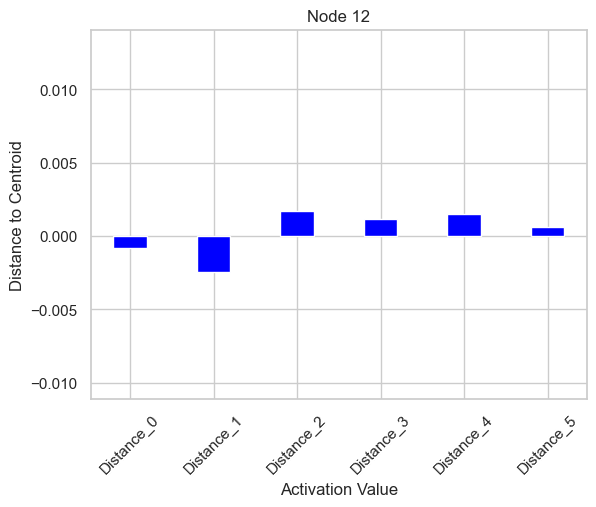

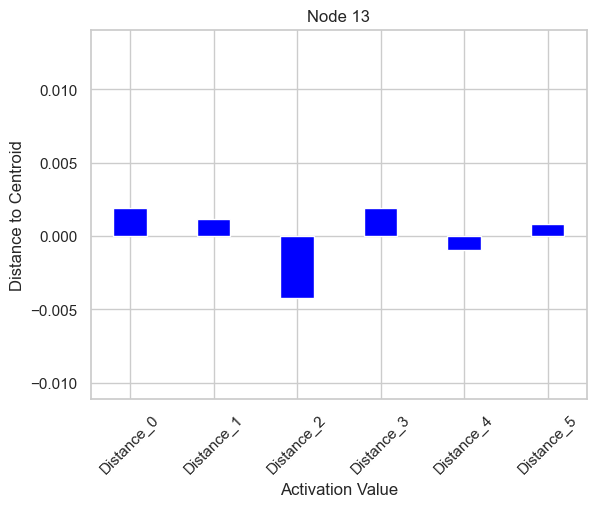

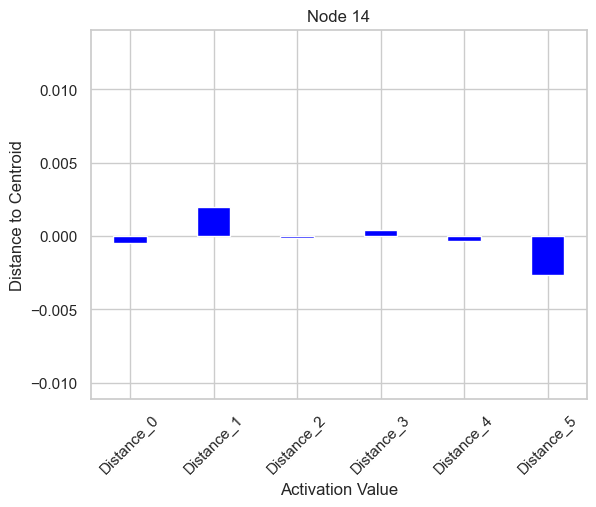

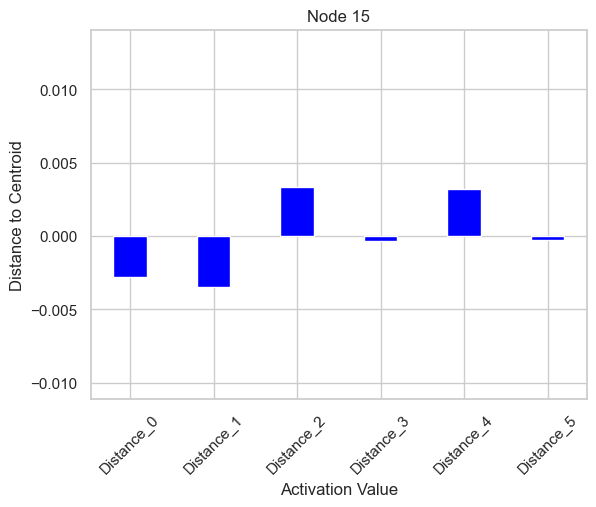

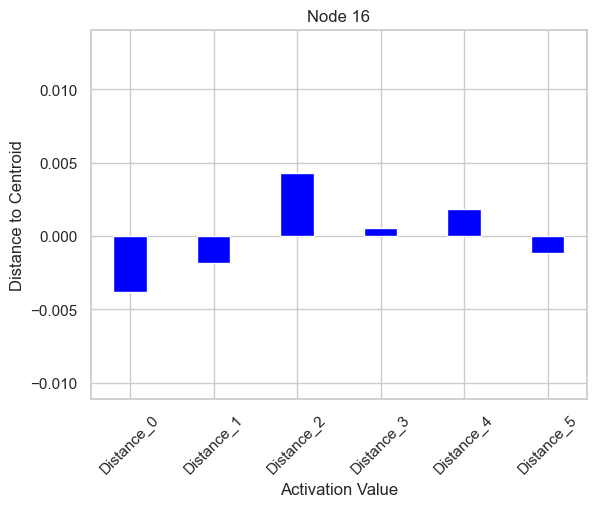

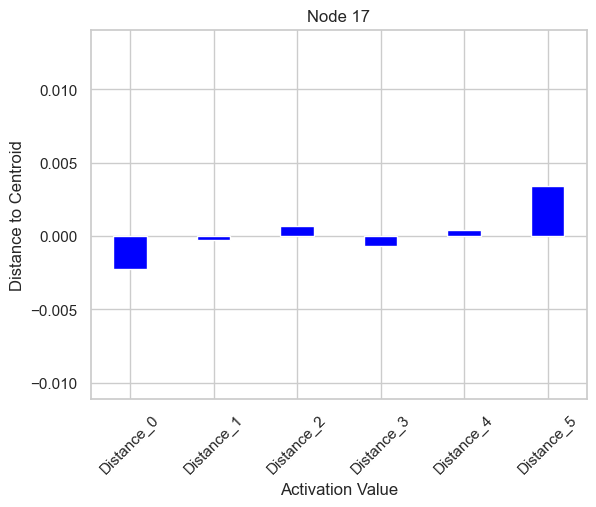

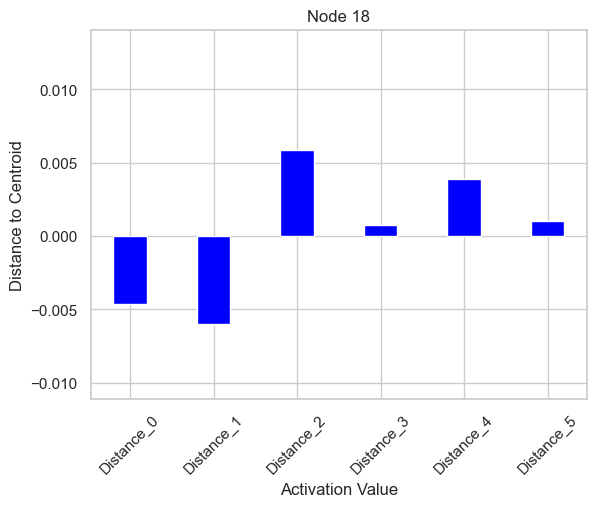

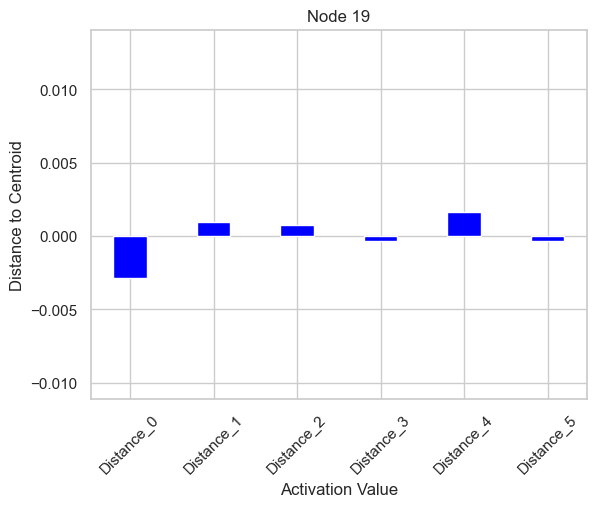

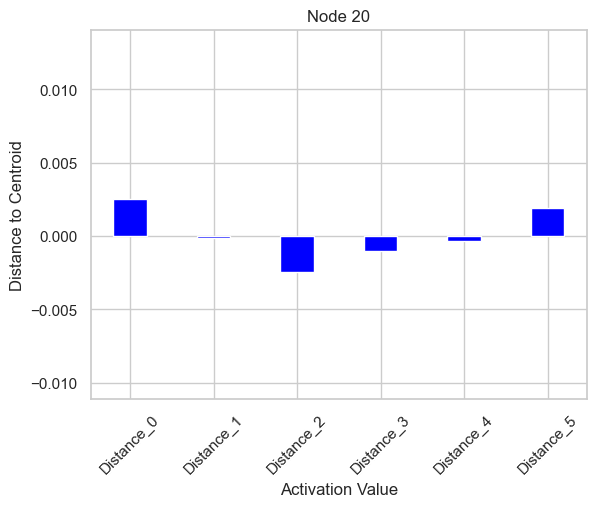

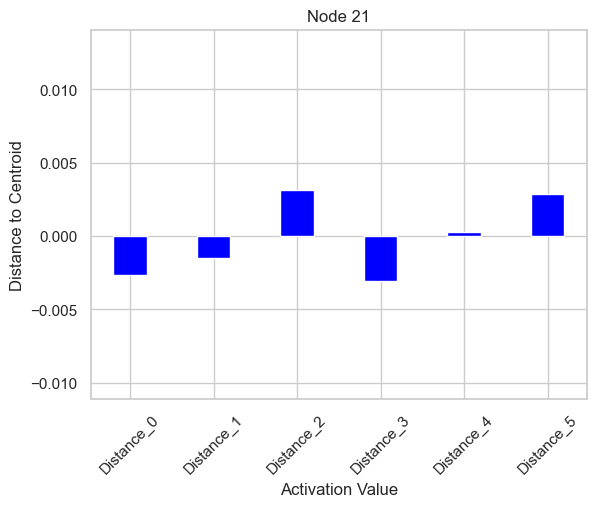

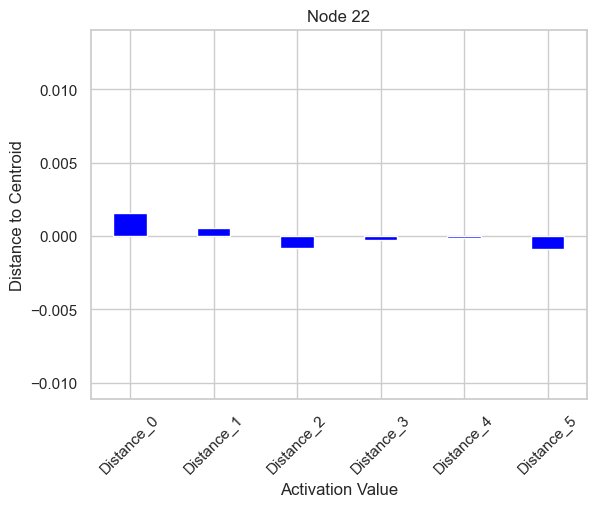

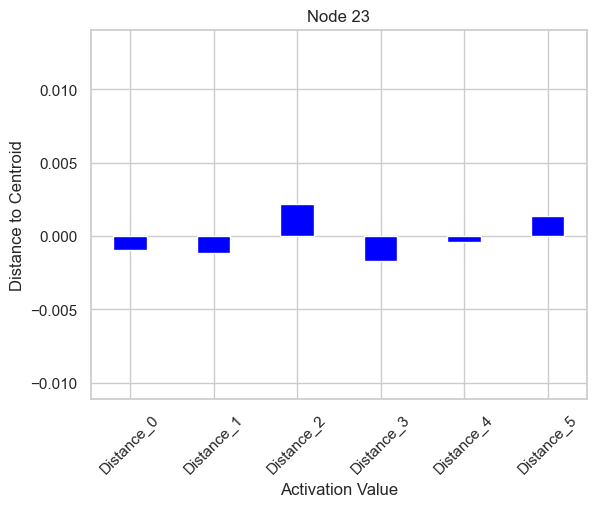

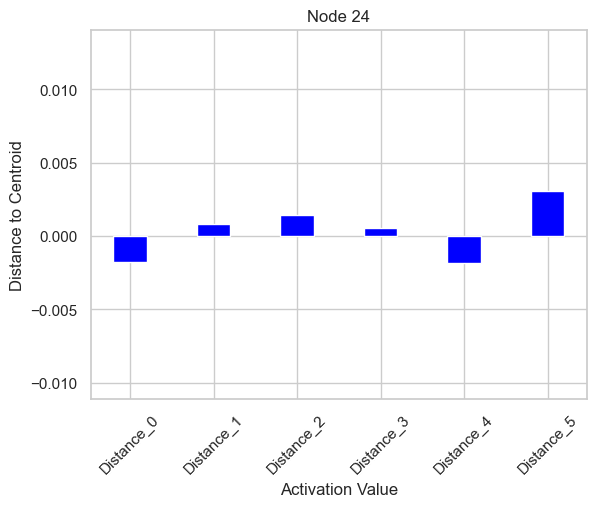

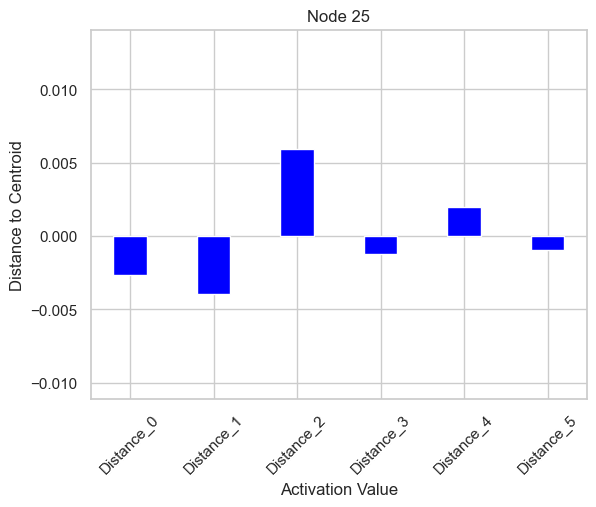

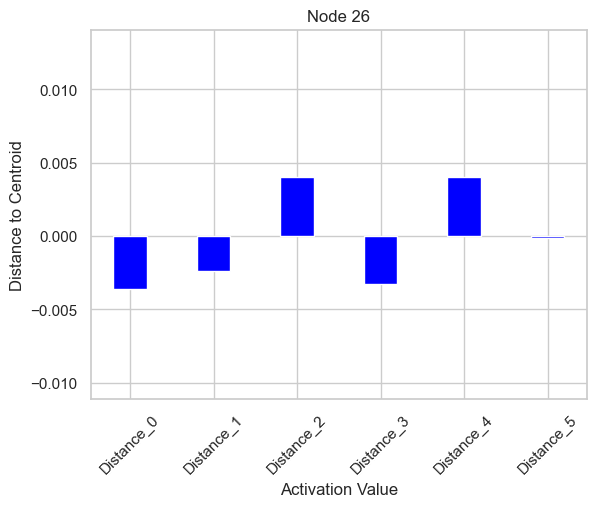

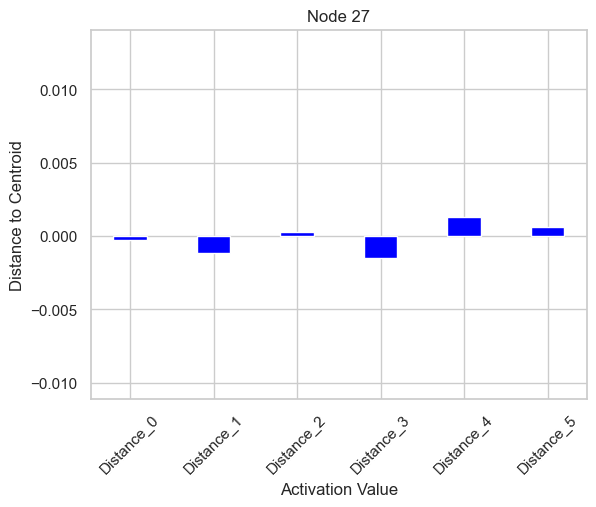

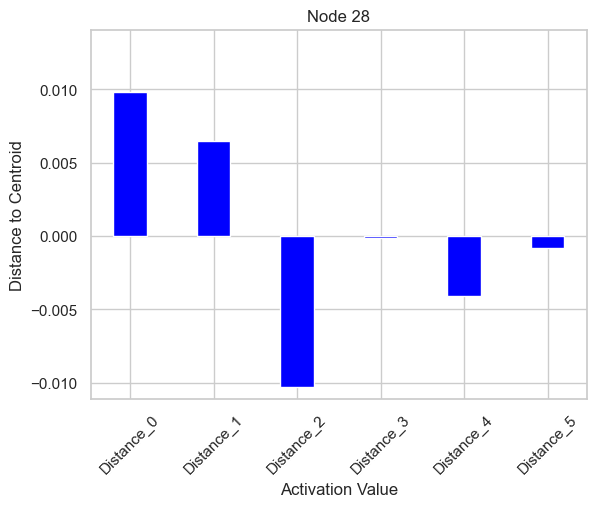

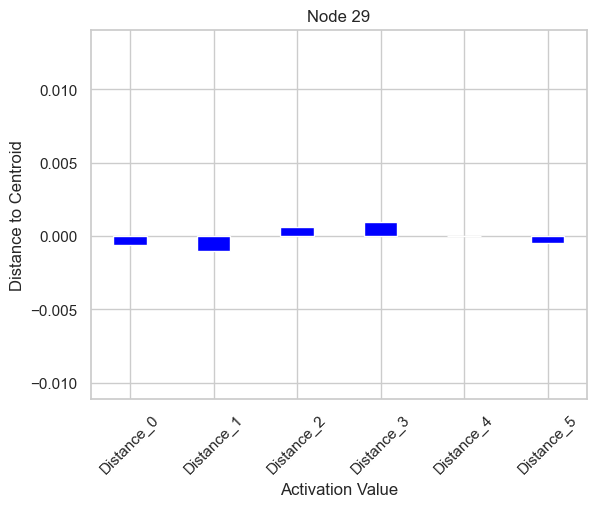

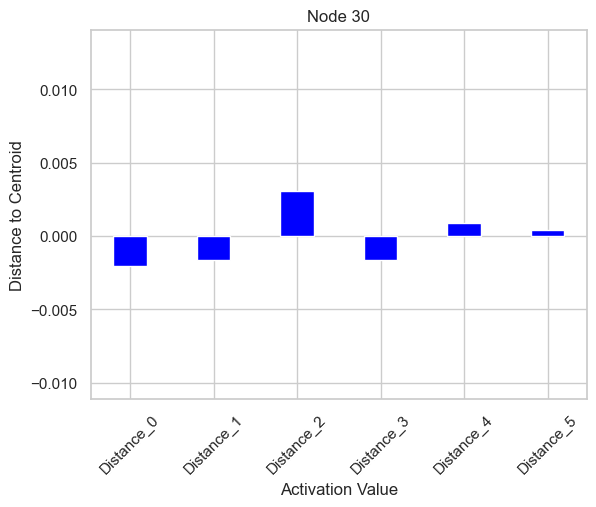

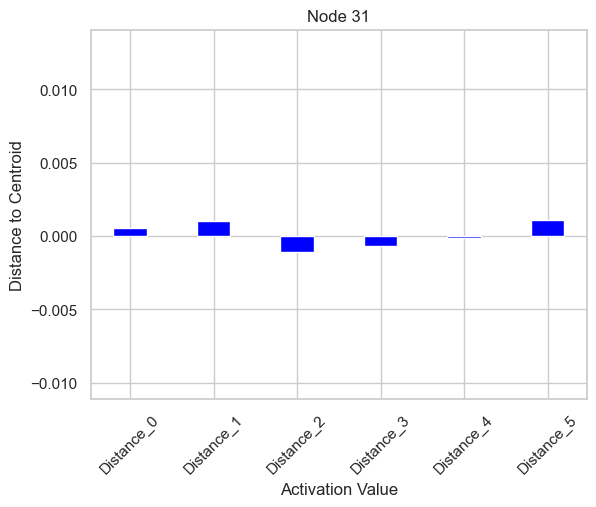

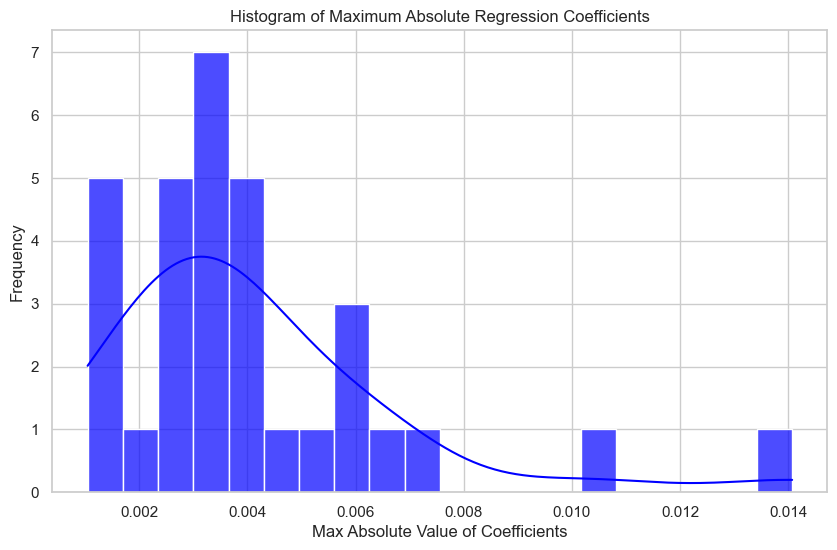

In [228]:


# keep track of the max distance
max_mahalanobis = 0

# move the model
total_input_model = total_input_model.to(device)

features_list = []


global network_layer_outputs
clear_total_run()


# getting all of the training data for correlation analysis
for features, _ in full_train_loader:

    # move the features to the device
    # features = features.to(device)

    # add it to the features list
    features_list.append(features)

    # pipe it through the model
    outputs = total_input_model(features.to(device))
    
    # save the current passthrough to the list
    save_and_clear_current_pass_through()

# now get all of the outputs
full_aug_model_intermediates = network_layer_outputs
clear_total_run()

# the coefficients for the regressions that I am running
coefficients = []  
lower_bounds = []
max_abs_coefficients = []
upper_bounds = []

# go through each of the intermediate variables in the model and collect them
for i in tqdm(range(len(full_aug_model_intermediates[0][LAYER_IDX][0])), desc="Creating regression between variables..."):

    # now we are going to get the ith element of the array
    current_node = []

    # adding all of the model intermediate values in 
    for j in range(len(full_aug_model_intermediates)):
        for t_element in full_aug_model_intermediates[j][LAYER_IDX][:, i]:
            current_node.append(t_element)


    # perform a regression between this element and the centroid distances

    # initialize a Linear Regression model
    linrg_model = LinearRegression()

    # convert the arrays to np arrays
    all_mahalanobis = np.array(all_mahalanobis)
    current_node = np.array(current_node)

    # print an update
    # print(f"Performing regression {i} between all_mahalanobis and current_node...")
    # print(f"Current Dimensions:\nall_mahalanobis shape{all_mahalanobis.shape}\ncurrent_node shape{current_node.shape}")

    # fit the regression
    linrg_model.fit(all_mahalanobis, current_node)


    # getting the maximum coefficient in the model
    max_abs_coef_index = np.argmax(np.abs(linrg_model.coef_))
    max_abs_model_coefficient = np.abs(linrg_model.coef_[max_abs_coef_index])
    max_abs_coefficients.append(max_abs_model_coefficient)
    
    
    # get the residuals and the standard error
    bound_preds = linrg_model.predict(all_mahalanobis)
    resid_vals = np.sum((current_node - bound_preds)**2)
    model_standard_error = np.sqrt(resid_vals / (len(current_node) - 2)) /  np.sqrt(np.sum((all_mahalanobis - np.mean(all_mahalanobis))**2))

    # now compute the 95% confidence bound for the model
    df = len(current_node) - 2
    t_critical = stats.t.ppf(1-0.025, df)

    # append the upper and lower bounds to the arrays that we are using to keep track
    ci_lower = max_abs_model_coefficient - t_critical * model_standard_error
    ci_upper = max_abs_model_coefficient + t_critical * model_standard_error

    lower_bounds.append(ci_lower)
    upper_bounds.append(ci_upper)
        
        
    # store the coefficient
    coefficients.append(linrg_model.coef_)





# plot the regression coefficients so that we can see what they are doing in the model
coefficients = np.array(coefficients)  

# flatten the array to get a single visualization
flat_coefficients = coefficients.flatten()

sns.set_theme(style="whitegrid")
sns.set_palette("magma")

# plot the information that we got
plt.figure(figsize=(10, 6))
plt.hist(flat_coefficients, bins=30, color='blue')
plt.title('Distribution of Regression Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Frequency')

if SHOULD_SAVE_OUTPUT:
    os.makedirs(os.path.join(curr_run_dir, "full_aug_coeff_hist_plots"), exist_ok=True)
    plt.savefig(dpi=300, fname=os.path.join(curr_run_dir, "full_aug_coeff_hist_plots", "reg_coeff_dist_hist.png"))

plt.show()


# now go through and make subplots for everything that we are doing
print(f"Coefficients Shape: {coefficients.shape}")

# get the number of coefficients for creating subplots
n_coeffs = coefficients.shape[1]

# labels of the coefficients
coeff_labels = [f"Distance_{x}" for x in range(coefficients.shape[1])]

# getting the minimum and the maximum value of the regressions
ymin = np.min(coefficients)
ymax = np.max(coefficients)

# create arrays that have the maximum absolute value coefficien tfrom each of them
# sort the arrays on the max vals now
full_aug_max_abs_values = np.array(max_abs_coefficients)
full_aug_sorted_indices = np.argsort(-full_aug_max_abs_values)


# sort the elements on the argument order
full_aug_sorted_max_abs_values = full_aug_max_abs_values[full_aug_sorted_indices]
full_aug_sorted_lower_bounds = np.array([lower_bounds[i] for i in full_aug_sorted_indices])
full_aug_sorted_upper_bounds = np.array([upper_bounds[i] for i in full_aug_sorted_indices])


# iterate through each of the possible coefficients that we are going to consider
for coeffs_idx in tqdm(range(coefficients.shape[0]), desc="Plotting regression coefficients"):
    
    plt.figure()

    # get the coefficients for that node in the matrix
    # plot on some subplot
    plt.bar(coeff_labels, coefficients[coeffs_idx], color ='blue', width = 0.4)
    
    # get the labeling information for the graph
    plt.title(f'Node {coeffs_idx}')
    plt.xlabel('Activation Value')
    plt.ylabel('Distance to Centroid')
    plt.xticks(rotation=45)

    # scale the y axis
    plt.ylim(ymin, ymax)

    if SHOULD_SAVE_OUTPUT:
        os.makedirs(os.path.join(curr_run_dir, "full_aug_coeff_hist_plots"), exist_ok=True)
        plt.savefig(dpi=300, fname=os.path.join(curr_run_dir, "full_aug_coeff_hist_plots", f"plt_coeff_{coeffs_idx}_node.png"))

    

# show the figure that we constructed
plt.show()


# plot the histrogram
plt.figure(figsize=(10, 6))
sns.histplot(full_aug_sorted_max_abs_values, bins=20, kde=True, color='blue', alpha=0.7)
plt.title('Histogram of Maximum Absolute Regression Coefficients')
plt.xlabel('Max Absolute Value of Coefficients')
plt.ylabel('Frequency')  

if SHOULD_SAVE_OUTPUT:
	plt.savefig(dpi=300, fname=os.path.join(curr_run_dir, "full_aug_coeff_hist_plots", "full_aug_abs_coeff.png"))
     
plt.show()


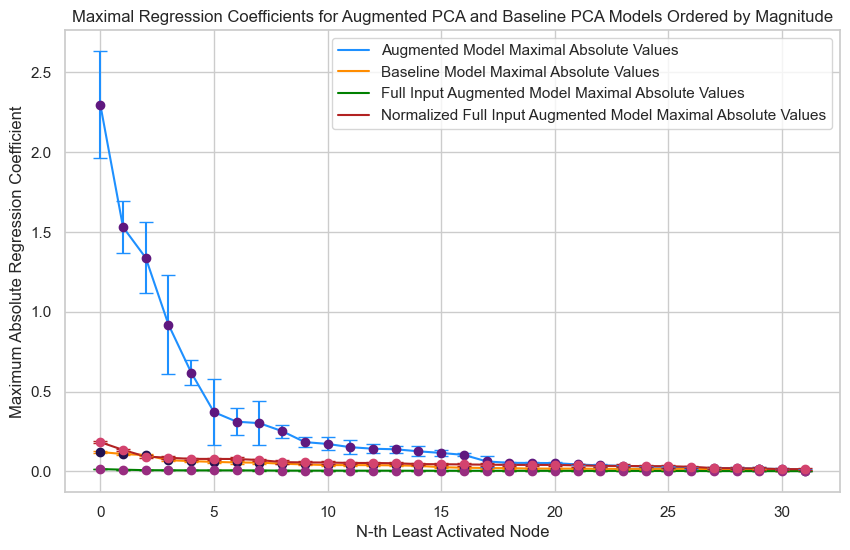

In [229]:
# now get a plot that shows the difference in the max absolute value ofthe coefficients inthe models

full_norm = (all_train_features.shape[1] / pca_train_features.shape[1])

plt.figure(figsize=(10, 6))

# Plot both histograms
plt.plot(aug_sorted_max_abs_values, label='Augmented Model Maximal Absolute Values', color=PLOT_COLOR_2)
plt.plot(baseline_sorted_max_abs_values, label='Baseline Model Maximal Absolute Values', color=PLOT_COLOR_1)
plt.plot(full_aug_sorted_max_abs_values, label='Full Input Augmented Model Maximal Absolute Values', color=PLOT_COLOR_3)
plt.plot(full_aug_sorted_max_abs_values * full_norm, label='Normalized Full Input Augmented Model Maximal Absolute Values', color=PLOT_COLOR_4)

plt.xlabel('N-th Least Activated Node')
plt.ylabel('Maximum Absolute Regression Coefficient')
plt.title('Maximal Regression Coefficients for Augmented PCA and Baseline PCA Models Ordered by Magnitude')
plt.legend()

plt.errorbar(x=np.arange(len(baseline_sorted_max_abs_values)), 
             y=baseline_sorted_max_abs_values, 
             yerr=[baseline_sorted_max_abs_values - baseline_sorted_lower_bounds, 
                   baseline_sorted_upper_bounds - baseline_sorted_max_abs_values],
             fmt='o', ecolor=PLOT_COLOR_1, capsize=5, label='95% Confidence Interval')


plt.errorbar(x=np.arange(len(aug_sorted_max_abs_values)), 
             y=aug_sorted_max_abs_values, 
             yerr=[aug_sorted_max_abs_values - aug_sorted_lower_bounds, 
                   aug_sorted_upper_bounds - aug_sorted_max_abs_values],
             fmt='o', ecolor=PLOT_COLOR_2, capsize=5, label='95% Confidence Interval')

plt.errorbar(x=np.arange(len(full_aug_sorted_max_abs_values)), 
             y=full_aug_sorted_max_abs_values, 
             yerr=[full_aug_sorted_max_abs_values - full_aug_sorted_lower_bounds, 
                   full_aug_sorted_upper_bounds - full_aug_sorted_max_abs_values],
             fmt='o', ecolor=PLOT_COLOR_3, capsize=5, label='95% Confidence Interval')

plt.errorbar(x=np.arange(len(full_aug_sorted_max_abs_values)), 
             y=full_aug_sorted_max_abs_values*full_norm, 
             yerr=[full_aug_sorted_max_abs_values * full_norm - full_aug_sorted_lower_bounds * full_norm, 
                   full_aug_sorted_upper_bounds * full_norm - full_aug_sorted_max_abs_values * full_norm],
             fmt='o', ecolor=PLOT_COLOR_4, capsize=5, label='95% Confidence Interval')


if SHOULD_SAVE_OUTPUT:
	plt.savefig(os.path.join(curr_run_dir, "full_error_bar_aug_vs_baseline_regression_coeffs.png"), dpi=300)

plt.show()


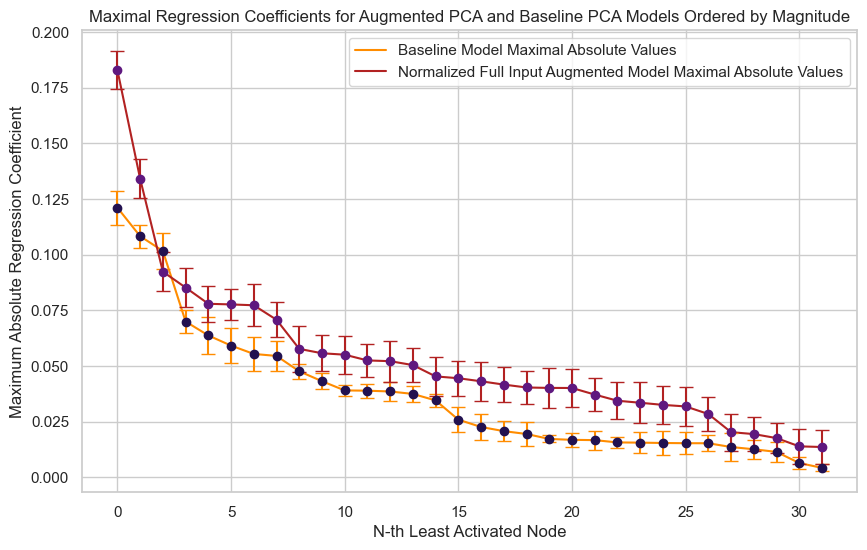

In [230]:
# now get a plot that shows the difference in the max absolute value ofthe coefficients inthe models

full_norm = (all_train_features.shape[1] / pca_train_features.shape[1])

plt.figure(figsize=(10, 6))

# Plot both histograms
# plt.plot(aug_sorted_max_abs_values, label='Augmented Model Maximal Absolute Values', color=PLOT_COLOR_2)
# plt.plot(full_aug_sorted_max_abs_values, label='Full Input Augmented Model Maximal Absolute Values', color=PLOT_COLOR_3)
plt.plot(baseline_sorted_max_abs_values, label='Baseline Model Maximal Absolute Values', color=PLOT_COLOR_1)
plt.plot(full_aug_sorted_max_abs_values * full_norm, label='Normalized Full Input Augmented Model Maximal Absolute Values', color=PLOT_COLOR_4)

plt.xlabel('N-th Least Activated Node')
plt.ylabel('Maximum Absolute Regression Coefficient')
plt.title('Maximal Regression Coefficients for Augmented PCA and Baseline PCA Models Ordered by Magnitude')
plt.legend()

plt.errorbar(x=np.arange(len(baseline_sorted_max_abs_values)), 
             y=baseline_sorted_max_abs_values, 
             yerr=[baseline_sorted_max_abs_values - baseline_sorted_lower_bounds, 
                   baseline_sorted_upper_bounds - baseline_sorted_max_abs_values],
             fmt='o', ecolor=PLOT_COLOR_1, capsize=5, label='95% Confidence Interval')


# plt.errorbar(x=np.arange(len(aug_sorted_max_abs_values)), 
#              y=aug_sorted_max_abs_values, 
#              yerr=[aug_sorted_max_abs_values - aug_sorted_lower_bounds, 
#                    aug_sorted_upper_bounds - aug_sorted_max_abs_values],
#              fmt='o', ecolor=PLOT_COLOR_2, capsize=5, label='95% Confidence Interval')

# plt.errorbar(x=np.arange(len(full_aug_sorted_max_abs_values)), 
#              y=full_aug_sorted_max_abs_values, 
#              yerr=[full_aug_sorted_max_abs_values - full_aug_sorted_lower_bounds, 
#                    full_aug_sorted_upper_bounds - full_aug_sorted_max_abs_values],
#              fmt='o', ecolor=PLOT_COLOR_3, capsize=5, label='95% Confidence Interval')

plt.errorbar(x=np.arange(len(full_aug_sorted_max_abs_values)), 
             y=full_aug_sorted_max_abs_values*full_norm, 
             yerr=[full_aug_sorted_max_abs_values * full_norm - full_aug_sorted_lower_bounds * full_norm, 
                   full_aug_sorted_upper_bounds * full_norm - full_aug_sorted_max_abs_values * full_norm],
             fmt='o', ecolor=PLOT_COLOR_4, capsize=5, label='95% Confidence Interval')


if SHOULD_SAVE_OUTPUT:
	plt.savefig(os.path.join(curr_run_dir, "baseline_full_regression_coeffs.png"), dpi=300)

plt.show()


In [231]:
# # # perform a partial dependence plot for the activations of the nodes and the inputs to the neural network

# # iterate over each input to the model
# num_features = data.shape[1] 
# for feature_index in range(num_features):


# feature_range = np.linspace(data[:, feature_index].min(), data[:, feature_index].max(), 100)
# fixed_data = np.repeat(data.mean(axis=0)[np.newaxis, :], len(feature_range), axis=0)
# fixed_data[:, feature_index] = feature_range

# predictions = model.predict(fixed_data)  # Make sure your model's predict method can handle this

# plt.plot(feature_range, predictions)
# plt.xlabel('Feature Value')
# plt.ylabel('Predicted Output')
# plt.title('Partial Dependence Plot')
# plt.show()


# Testing the Influencing of Only a Single Layer in the Neural network

In this section, we are going to test the impact of only running this scheme of upweighting and downweighting on a single network layer and attempt to measure the effect of it

In [232]:
if TESTING_SINGLE_lAYER:


    # initialize the model
    single_layer_model = NodeImportanceNN()

    # actually register the hooks on the model
    register_hooks(single_layer_model)



    # check if one or the other is not true
    if TRAIN_MODEL and not SHOULD_SAVE_OUTPUT:
        raise ValueError("Incorrect truth table for arguments")



    # train the model with the mahalanobis distances
    if TRAIN_MODEL:
        if USE_BATCHES:
            train_model_with_variance(single_layer_model, pca_train_loader, pca_val_loader, variance_criterion, optimizer, all_mahalanobis, k_means_centers_variable, centroid_passes, verbose=0, epochs=30, limit_layers=True)
        else:
            train_model_with_variance(single_layer_model, pca_train_dataset, pca_val_dataset, variance_criterion, optimizer, all_mahalanobis, k_means_centers_variable, centroid_passes, verbose=0, epochs=30, limit_layers=True)

    else:
        # getting the most recently saved file as the model
        rec_model = get_most_recent_file(SAVE_MODEL_PATH)

        path_for_display = rec_model.replace(' ', '\\ ')
        print(f"Loading model in from {path_for_display}")

        # load the model in from the save path
        single_layer_model = torch.load(rec_model)

    # get the output statistics for the model
    accuracy = accuracy_score(all_train_labels, [np.argmax(t_arr) for t_arr in single_layer_model(pca_train_features.to(device)).cpu().detach().numpy()])
    print("Train Accuracy: {:.2f}%".format(accuracy * 100))


    # saving the model if we have trained it
    if TRAIN_MODEL:

        # generate a unique file name
        unique_dir = generate_unique_file_dir(SAVE_MODEL_PATH, SINGLE_SAVE_FILE_NAME.replace(".pth", f"_{clustering_method_name}"))
        os.makedirs(unique_dir, exist_ok=True)

        # save the file
        print("File will be saved as:", unique_dir)
        torch.save(single_layer_model, os.path.join(unique_dir, SINGLE_SAVE_FILE_NAME))

        # save the information about the clusters and the centroids as well
        info_dict = {}

        # save the information in a dictionary
        info_dict['centroid_num'] = CLUSTER_NUM
        info_dict['centroids'] = k_means_centers_variable

        # open and dump the pickle file
        with open(os.path.join(unique_dir, INFO_DICT_NAME), 'wb') as file:
            pickle.dump(info_dict, file)


    # check if we should save the model to a runthrough
    if SHOULD_SAVE_OUTPUT:

        # generate a unique file name
        # unique_dir = generate_unique_file_dir(SAVE_MODEL_PATH, SAVE_FILE_NAME.replace(".pth", f"_{clustering_method.__name__}"))

        # save the file
        f_save_path = os.path.join(curr_run_dir, SINGLE_SAVE_FILE_NAME.replace(".pth", f"_{clustering_method_name}.pth"))
        print("File will be saved as:", f_save_path)
        torch.save(single_layer_model, f_save_path)

        # save the information about the clusters and the centroids as well
        info_dict = {}

        # save the information in a dictionary
        info_dict['centroid_num'] = CLUSTER_NUM
        info_dict['centroids'] = k_means_centers_variable

        # open and dump the pickle file
        with open(os.path.join(curr_run_dir, INFO_DICT_NAME), 'wb') as file:
            pickle.dump(info_dict, file)



# Start of Importance Reduction Formula

This is the start of the development of the importance reduction equation which will lower the importance of certain inputs to the network. We are going to try a series of analyses to try to understand how to optimally remove the influence of a single input on the neural network that we are considering. We are going to try to find how long each of the methods that we detail takes along with the degradation in accuracy compared to baseline. Some methods that we plan to explore are below, but there likely will not be enough time to explore all of the method:

- simple retraining: this is going to serve as the baseline that we compare the rest of the methdos that we try against. We are going to remove one of the inputs from the model, and train the model to see how the model does along with how long it takes. 
- stochastic fine-tuning: this method takes the original dataset and fine-tunes the model where the input feature that we are trying to mask has a stochastic value in place of the real value for each instance that we process in the dataset.
- inversion fine-tuning: similar to the stochastic method, this method takes the input tensors that we used to originally train the model but changes the feature that we are trying to remove to an inverted version of the original data point. That is, given the original datapoint feature $x$ and the mean of the feature over the entire dataset $x'$, we fine-tune the model using the save input data but with x changed to $x = x - 2 \cdot (x - x')$. We explore whether using the mean is the optimal configuration as well. 
- amplitude-influence reduction: in this method, we actually manipulate the weights of the model to try to approximate the original output of the model while enforcing all weights coming out of the node that we target in the model remain equal to 0. If the node hthat we are tring to limit the influence of is an inut node, then we can fine-tune the model after to ensure that the output is approximated as closely as possible. Otherwise, we simply have to keep the model as is after the weight manipulation or the concept could become dispersed through other nodes and flow to a later layer. 
- amplitude-influence reduction (extended): an extension of this method would be to use the covariance of the individual activations from layer $i-1$ to supplement the removal of a single node in layer $i-1$ totally. In order to do this, I find the covariance of all of the outputs of the layer and greedily add influenece from the nodes that have the highest magnitude covariance on all of the outputs that have lost the influence of the selected node. I adjust the bias in the process if possible as well. 

In [233]:
# finally, a weight-influenced correlation analysis with the nodes

### Optimal Input Activation Analysis

We perform activation analysis for each of the nodes that are later in the network to understand what their chief activations are.

In [234]:
# import torch
# import torch.optim as optim
# from torchvision.models import vgg16  # example model

# # load a pre-trained model (for demonstration)
# model = vgg16(pretrained=True)
# model.eval()  # set the model to evaluation mode

# # choose a layer and a specific node within that layer
# layer = model.features[10]  # example layer
# node_index = 5  # index of the node in the chosen layer

# # define a hook to capture the activations of the target layer
# activations = []
# def hook_fn(module, input, output):
#     activations.append(output)

# # register the hook
# hook = layer.register_forward_hook(hook_fn)

# # initialize a random image (input) with gradients enabled
# input_img = torch.randn(1, 3, 224, 224, requires_grad=True)

# # define optimizer for the input image
# optimizer = optim.Adam([input_img], lr=0.1)

# # optimization loop
# for iteration in range(30):  # number of iterations
#     optimizer.zero_grad()  # zero-out gradients
#     model(input_img)  # forward pass
    
#     # target the activation of the specific node
#     target_activation = activations[-1][0, node_index].mean()
    
#     # negative loss because we want to maximize activation
#     loss = -target_activation
#     loss.backward()  # compute gradients
#     optimizer.step()  # update the input image based on gradients

#     # clear activations after each iteration
#     activations.clear()

# # remove the hook to clean up
# hook.remove()

# # at this point, input_img is optimized to maximize the activation of the target node


# # detach the optimized input from the current computational graph and move it to cpu
# optimized_input = input_img.detach().cpu()

# # optionally, convert the tensor to a pil image for visualization
# # this step might require normalization depending on the input range your model expects
# from torchvision.transforms.functional import to_pil_image

# # assuming the model expects input in the range [0, 1] or has been normalized appropriately
# optimized_image = to_pil_image(optimized_input.squeeze())  # remove batch dimension
# optimized_image.show()


# Compressing the Pytorch Model That We Trained

Here we are going to save the model that we have trained in an encrypted file so that it is not able to be tampered with. Additionally, we are able to hash the model to figure out whether it has been trained beyond some verifiable state of unbiased nature.

This ensures that the model is not changed down the line by potentially adversarial players. The code in the following cell is inspired by the work of [Geeks2Geeks](https://www.geeksforgeeks.org/how-to-encrypt-and-decrypt-strings-in-python/)

In [236]:
# print out the directory that we are operating in
print(f"curr_run_dir: {curr_run_dir}")

curr_run_dir: /Users/tristanbrigham/Desktop/Classes/CPSC 471/Final Project/runthroughs/run_1


In [235]:

# generate the keys that we are going to be using in order to 
# encrypt and decrypt the model
def generate_keys():

    private_key_path = os.path.join(curr_run_dir, "private_key.pem")
    public_key_path = os.path.join(curr_run_dir, "public_key.pem")

    # check if we have already done this
    if os.path.exists(private_key_path) and os.path.exists(public_key_path):
        return
    
    # private/public key pair
    private_key = rsa.generate_private_key(
        public_exponent=65537,
        key_size=2048,
        backend=default_backend()
    )

    # get the public key from the result
    public_key = private_key.public_key()

    # save the private key into a file
    with open(private_key_path, "wb") as f:
        f.write(private_key.private_bytes(
            encoding=serialization.Encoding.PEM,
            format=serialization.PrivateFormat.PKCS8,
            encryption_algorithm=serialization.NoEncryption()
        ))

    # save the public key to a file
    with open(public_key_path, "wb") as f:
        f.write(public_key.public_bytes(
            encoding=serialization.Encoding.PEM,
            format=serialization.PublicFormat.SubjectPublicKeyInfo
        ))


# reading the encrypted key and model details
# from the file that we give it
def load_encrypted_data(filename):
    with open(filename, "rb") as f:
        encrypted_key = f.read(256)  # we read 256 since that is the length of the encrypting string that we used 
        encrypted_data = f.read()  
    return encrypted_key, encrypted_data


# getting a moedl that we can use for predictions from the decrypted data that we get
def load_model_from_bytes(decrypted_decompressed_data):
   
    # get the data
    model_state_dict = pickle.loads(decrypted_decompressed_data)
    model = NodeImportanceNN()

    # load in the state of the model
    model.load_state_dict(model_state_dict)

    return model


# this function compresses and encrypts the machine learning model that we feed it
# using an extra Fernet key
def encrypt_and_compress(data):
    
    # gen key for AES encryption
    key = Fernet.generate_key()
    cipher = Fernet(key)

    # compress the data and encrypt it
    compressed_data = zlib.compress(data)
    encrypted_data = cipher.encrypt(compressed_data)

    # load in the public key
    with open(os.path.join(curr_run_dir, "public_key.pem"), "rb") as key_file:
        public_key = serialization.load_pem_public_key(key_file.read(), backend=default_backend())

    # encrypt thedata with the AES key using strong standard
    encrypted_key = public_key.encrypt(key, padding.OAEP(mgf=padding.MGF1(algorithm=hashes.SHA256()), algorithm=hashes.SHA256(), label=None))

    # return the key and the model data
    return encrypted_key, encrypted_data


# decrypt the data and decompress it
def decrypt_and_decompress(encrypted_key, encrypted_data):
    
    # load the private key for decryption
    with open(os.path.join(curr_run_dir, "private_key.pem"), "rb") as key_file:
        private_key = serialization.load_pem_private_key(
            key_file.read(), password=None, backend=default_backend()
        )

    # decrypt data using the same decryption algorithm as we defined above
    decrypted_key = private_key.decrypt(
        encrypted_key,
        padding.OAEP(
            mgf=padding.MGF1(algorithm=hashes.SHA256()),
            algorithm=hashes.SHA256(),
            label=None
        )
    )

    # get the decrypted data from the hash
    cipher = Fernet(decrypted_key)
    decrypted_compressed_data = cipher.decrypt(encrypted_data)

    # decompress the decrypted data
    decompressed_data = zlib.decompress(decrypted_compressed_data)

    # return the decompressed data
    return decompressed_data



# define a hash function that hashes all of the model weights
# so that we can keep track of when the model training changes
# and are able to alert if our model is not verifiably trained anymore
def hash_model_weights(model):
    hash_obj = hashlib.sha256()
    for param in model.parameters():
        hash_obj.update(param.data.cpu().numpy())
    return hash_obj.hexdigest()


# compressing the model and saving it to the output file
# that we specify
def save_and_compress_model(model, filename="encrypted_model.match"):
    
    # clear gradients
    for param in model.parameters():
        param.grad = None

    # hash the model weights
    model_hash = hash_model_weights(model)
    print("Model hash:", model_hash)

    # serialize model state dictionary
    model_state_dict = model.state_dict()
    model_bytes = pickle.dumps(model_state_dict)

    # encrypt and compress
    # encrypted_compressed_data = encrypt_and_compress(model_bytes)
    encrypted_key, encrypted_compressed_data = encrypt_and_compress(model_bytes)

    # save to custom .match format
    with open(os.path.join(curr_run_dir, filename), "wb") as f:
        f.write(encrypted_key)
        f.write(encrypted_compressed_data)


# generate keys that we are going to be using 
# only run this once (it checks if the keys already exist though)
generate_keys()

# use the function with your model
save_and_compress_model(augmented_model, "augmented_model.match")
save_and_compress_model(baseline_model, "baseline_model.match")
save_and_compress_model(total_input_model, "total_input_model.match")

# the code below should decompress the model
# after checking that the hashes match
encrypted_key, encrypted_data = load_encrypted_data(os.path.join(curr_run_dir, "augmented_model.match"))
new_augmented_model = load_model_from_bytes(decrypt_and_decompress(encrypted_key, encrypted_data))


Model hash: 0789eda18b1c31f8b79fa6d206180f0a653aee0f12cca227ea616a62227b9581


NameError: name 'single_layer_model' is not defined